## Exercise: Using DCGAN to Generate Handwritten Digits (Paper Reference)

In [10]:
import os, tensorflow as tf
print(tf.__version__)

2.10.1


In [11]:
import os, random, numpy as np
from numpy import expand_dims, vstack, zeros, ones
from numpy.random import randn, randint
import tensorflow as tf
from tensorflow.keras.initializers import RandomNormal
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Reshape, Flatten, Conv2D
from keras.layers import Conv2DTranspose, ReLU, LeakyReLU, Dropout
from keras.layers import UpSampling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [12]:
def set_seed(seed_value=1234):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

seed_value = 1234
set_seed(seed_value)

### Load Images

In [13]:
# load the images into memory
(train_images, train_labels), (_, _) = load_data()

# summarize the shape of the dataset
print('Size', train_images.shape, train_labels.shape)

Size (60000, 28, 28) (60000,)


### Preprocessing

In [14]:
# Reshape data and also convert the data type to 'float32'
print(train_images.shape)
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
print(train_images.shape)

# Normalize the images to [-1, 1] which is the range of the tanh activation
train_images = (train_images - 127.5) / 127.5

(60000, 28, 28)
(60000, 28, 28, 1)


## The generator model

the generator model is responsible for generating new synthetic data samples that resemble the training data. It is a deep convolutional neural network (CNN) architecture that takes random noise as input and produces output that resembles the original data distribution.

In [15]:
def build_generator(latent_size=100, alpha=0.2):
    weight_init = RandomNormal(mean=0.0, stddev=0.02)
    model = Sequential(name='generator')

    model.add(Dense(7 * 7 * 128, input_dim=latent_size, kernel_initializer=weight_init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha))
    model.add(Reshape((7, 7, 128)))

    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same',
                              kernel_initializer=weight_init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha))

    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same',
                              kernel_initializer=weight_init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha))

    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same',
                              activation='tanh', kernel_initializer=weight_init))
    return model

## The discriminator model

The discriminator model takes an input image and processes it through a series of convolutional layers, followed by activation functions such as LeakyReLU, and pooling layers. This helps extract features and learn representations from the input image. The final output of the discriminator is a probability score indicating the likelihood that the input image is real or fake.

In [16]:
def build_discriminator(input_shape=(28, 28, 1), alpha=0.2):
    weight_init = RandomNormal(mean=0.0, stddev=0.02)
    model = Sequential(name='discriminator')

    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                     input_shape=input_shape, kernel_initializer=weight_init))
    model.add(LeakyReLU(alpha))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same',
                     kernel_initializer=weight_init))
    model.add(LeakyReLU(alpha))

    model.add(Flatten())
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    return model

## Train the DCGAN model

In [17]:
latent_size = 100

# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(learning_rate=0.0002, beta_1=0.5),
                      metrics=['accuracy'])

# Build the generator
generator = build_generator(latent_size)

# Build and compile the GAN
discriminator.trainable = False  # Freeze the discriminator's weights when training the generator
gan_input = Input(shape=(latent_size,))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))

gan.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 generator (Sequential)      (None, 28, 28, 1)         1275521   
                                                                 
 discriminator (Sequential)  (None, 1)                 212865    
                                                                 
Total params: 1,488,386
Trainable params: 1,262,593
Non-trainable params: 225,793
_________________________________________________________________


Epoch 1/100
Step 0/938 [D loss: 0.6917, acc.: 50.00%] [G loss: 0.6790]
Step 100/938 [D loss: 0.2483, acc.: 100.00%] [G loss: 0.0358]
Step 200/938 [D loss: 0.1750, acc.: 100.00%] [G loss: 0.0468]
Step 300/938 [D loss: 0.6135, acc.: 74.22%] [G loss: 1.7228]
Step 400/938 [D loss: 0.6727, acc.: 70.31%] [G loss: 0.8852]
Step 500/938 [D loss: 0.6837, acc.: 67.19%] [G loss: 0.8669]
Step 600/938 [D loss: 0.7443, acc.: 53.12%] [G loss: 0.9345]
Step 700/938 [D loss: 0.7149, acc.: 59.38%] [G loss: 0.8832]
Step 800/938 [D loss: 0.6923, acc.: 59.38%] [G loss: 0.8408]
Step 900/938 [D loss: 0.6789, acc.: 62.50%] [G loss: 0.8555]
1/1 [==============================] - 0s 106ms/step


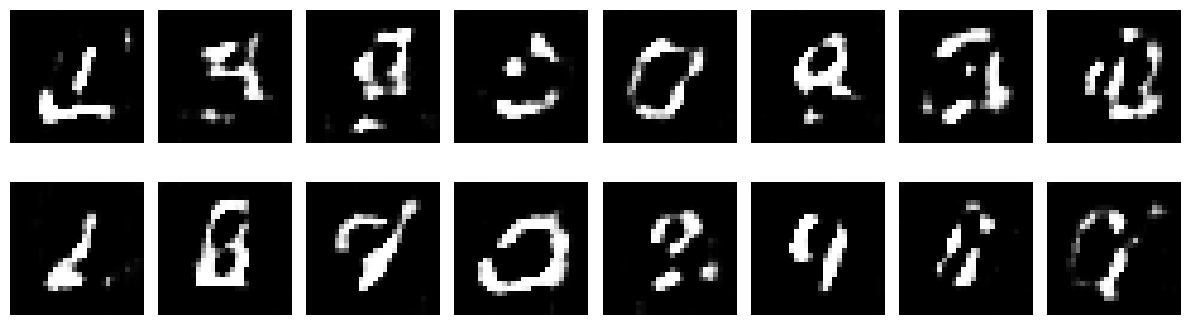

Epoch 2/100
Step 0/938 [D loss: 0.6837, acc.: 55.47%] [G loss: 0.8997]
Step 100/938 [D loss: 0.7116, acc.: 57.81%] [G loss: 0.8077]
Step 200/938 [D loss: 0.6777, acc.: 64.84%] [G loss: 0.8861]
Step 300/938 [D loss: 0.7239, acc.: 53.12%] [G loss: 0.8232]
Step 400/938 [D loss: 0.6921, acc.: 67.19%] [G loss: 0.8911]
Step 500/938 [D loss: 0.6772, acc.: 67.19%] [G loss: 0.8583]
Step 600/938 [D loss: 0.7000, acc.: 60.16%] [G loss: 0.8378]
Step 700/938 [D loss: 0.6823, acc.: 57.81%] [G loss: 0.9084]
Step 800/938 [D loss: 0.6734, acc.: 53.91%] [G loss: 0.8849]
Step 900/938 [D loss: 0.7066, acc.: 64.84%] [G loss: 0.7959]
1/1 [==============================] - 0s 31ms/step


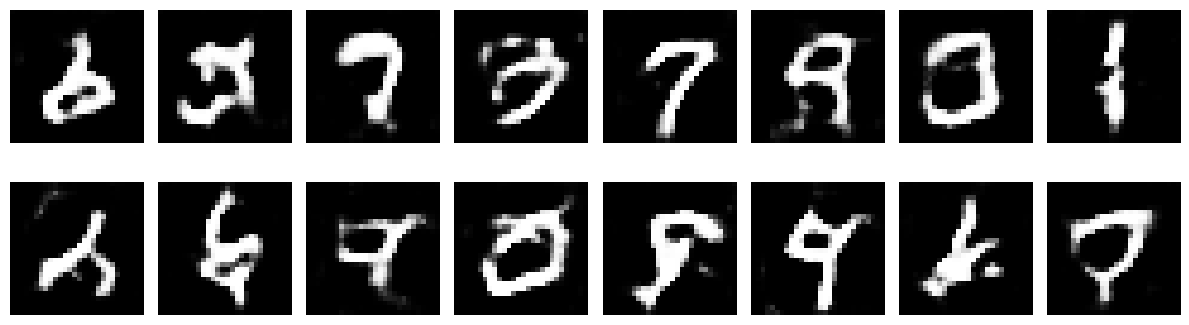

Epoch 3/100
Step 0/938 [D loss: 0.7170, acc.: 58.59%] [G loss: 0.7684]
Step 100/938 [D loss: 0.6255, acc.: 67.19%] [G loss: 0.9358]
Step 200/938 [D loss: 0.6782, acc.: 60.16%] [G loss: 0.8790]
Step 300/938 [D loss: 0.6885, acc.: 58.59%] [G loss: 0.8846]
Step 400/938 [D loss: 0.6623, acc.: 60.16%] [G loss: 0.9306]
Step 500/938 [D loss: 0.6899, acc.: 54.69%] [G loss: 0.8578]
Step 600/938 [D loss: 0.6821, acc.: 55.47%] [G loss: 0.8727]
Step 700/938 [D loss: 0.6773, acc.: 64.84%] [G loss: 0.8529]
Step 800/938 [D loss: 0.6635, acc.: 61.72%] [G loss: 0.8518]
Step 900/938 [D loss: 0.7086, acc.: 56.25%] [G loss: 0.8193]
1/1 [==============================] - 0s 29ms/step


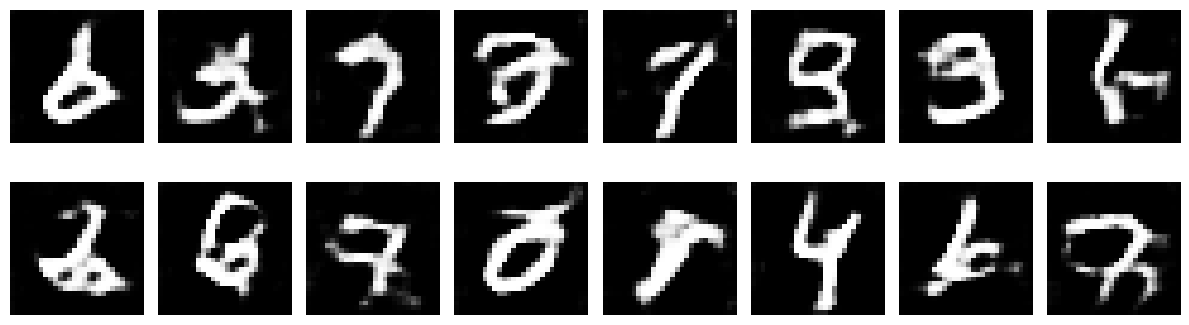

Epoch 4/100
Step 0/938 [D loss: 0.6667, acc.: 57.03%] [G loss: 0.9501]
Step 100/938 [D loss: 0.6632, acc.: 64.84%] [G loss: 0.8942]
Step 200/938 [D loss: 0.6754, acc.: 57.81%] [G loss: 0.8615]
Step 300/938 [D loss: 0.6774, acc.: 60.94%] [G loss: 0.8437]
Step 400/938 [D loss: 0.6709, acc.: 56.25%] [G loss: 0.8098]
Step 500/938 [D loss: 0.6661, acc.: 59.38%] [G loss: 0.9148]
Step 600/938 [D loss: 0.6788, acc.: 57.03%] [G loss: 0.8670]
Step 700/938 [D loss: 0.6869, acc.: 57.03%] [G loss: 0.8455]
Step 800/938 [D loss: 0.6728, acc.: 57.03%] [G loss: 0.9069]
Step 900/938 [D loss: 0.6599, acc.: 65.62%] [G loss: 0.9211]
1/1 [==============================] - 0s 26ms/step


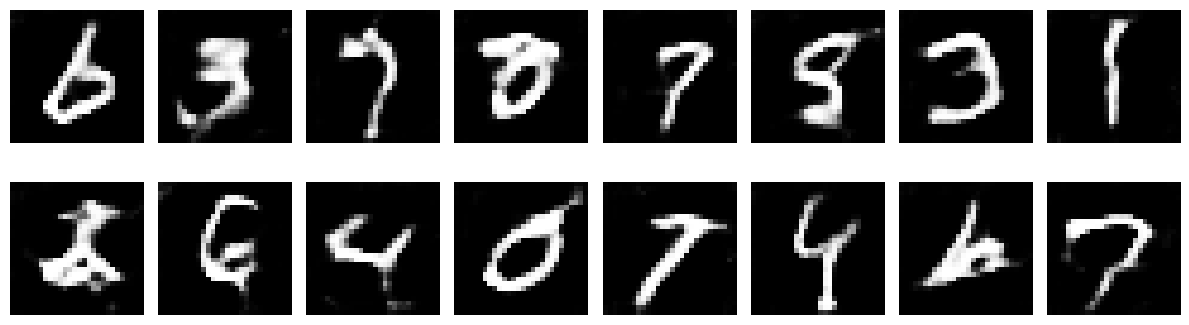

Epoch 5/100
Step 0/938 [D loss: 0.6787, acc.: 57.03%] [G loss: 0.8869]
Step 100/938 [D loss: 0.6733, acc.: 60.16%] [G loss: 0.9202]
Step 200/938 [D loss: 0.7087, acc.: 59.38%] [G loss: 0.8544]
Step 300/938 [D loss: 0.6649, acc.: 68.75%] [G loss: 0.8576]
Step 400/938 [D loss: 0.6443, acc.: 70.31%] [G loss: 1.0245]
Step 500/938 [D loss: 0.6594, acc.: 63.28%] [G loss: 0.9078]
Step 600/938 [D loss: 0.6614, acc.: 64.06%] [G loss: 0.9943]
Step 700/938 [D loss: 0.6365, acc.: 67.19%] [G loss: 1.0157]
Step 800/938 [D loss: 0.6725, acc.: 63.28%] [G loss: 0.9007]
Step 900/938 [D loss: 0.6728, acc.: 64.06%] [G loss: 0.9301]
1/1 [==============================] - 0s 26ms/step


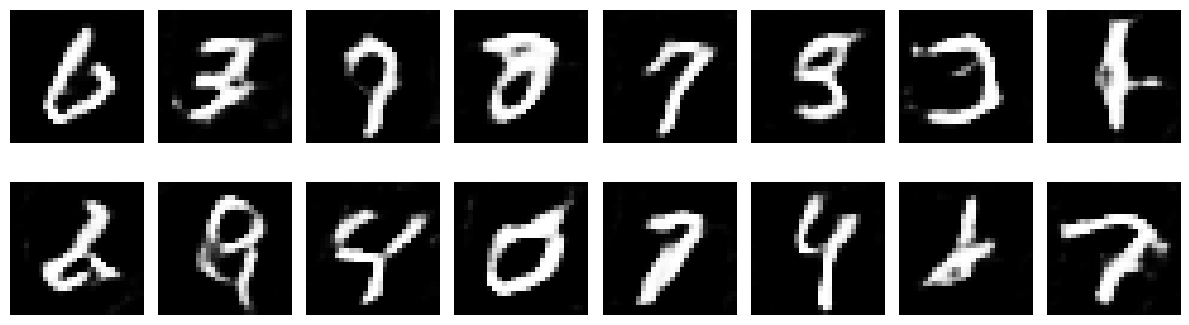

Epoch 6/100
Step 0/938 [D loss: 0.6632, acc.: 67.97%] [G loss: 0.9480]
Step 100/938 [D loss: 0.6660, acc.: 64.84%] [G loss: 0.8830]
Step 200/938 [D loss: 0.7108, acc.: 67.19%] [G loss: 0.9116]
Step 300/938 [D loss: 0.6466, acc.: 67.19%] [G loss: 0.9212]
Step 400/938 [D loss: 0.6737, acc.: 69.53%] [G loss: 0.8824]
Step 500/938 [D loss: 0.6427, acc.: 64.84%] [G loss: 0.9403]
Step 600/938 [D loss: 0.6928, acc.: 62.50%] [G loss: 0.9131]
Step 700/938 [D loss: 0.6433, acc.: 65.62%] [G loss: 0.9849]
Step 800/938 [D loss: 0.6690, acc.: 65.62%] [G loss: 0.9003]
Step 900/938 [D loss: 0.6550, acc.: 64.06%] [G loss: 0.9434]
1/1 [==============================] - 0s 23ms/step


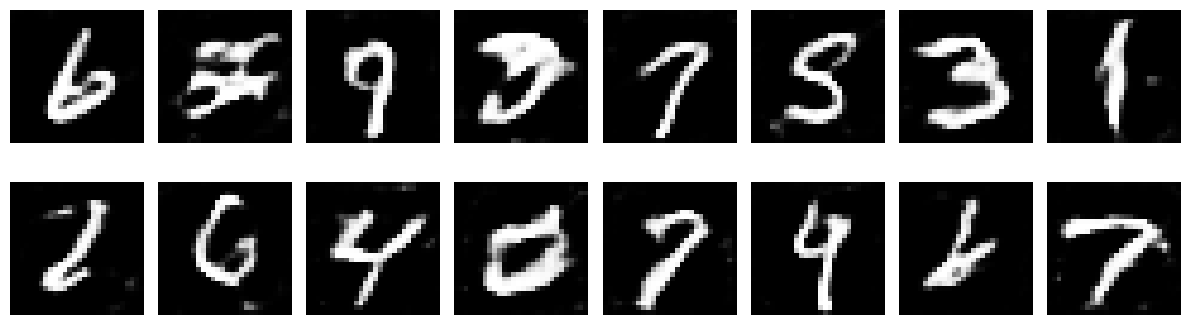

Epoch 7/100
Step 0/938 [D loss: 0.6838, acc.: 63.28%] [G loss: 0.9303]
Step 100/938 [D loss: 0.6602, acc.: 67.19%] [G loss: 0.9853]
Step 200/938 [D loss: 0.6782, acc.: 57.81%] [G loss: 0.9245]
Step 300/938 [D loss: 0.6717, acc.: 64.06%] [G loss: 0.8964]
Step 400/938 [D loss: 0.6656, acc.: 64.84%] [G loss: 0.8978]
Step 500/938 [D loss: 0.6800, acc.: 63.28%] [G loss: 0.9099]
Step 600/938 [D loss: 0.6647, acc.: 64.84%] [G loss: 0.9675]
Step 700/938 [D loss: 0.6611, acc.: 61.72%] [G loss: 0.9246]
Step 800/938 [D loss: 0.6829, acc.: 61.72%] [G loss: 0.9272]
Step 900/938 [D loss: 0.6451, acc.: 67.19%] [G loss: 0.9095]
1/1 [==============================] - 0s 24ms/step


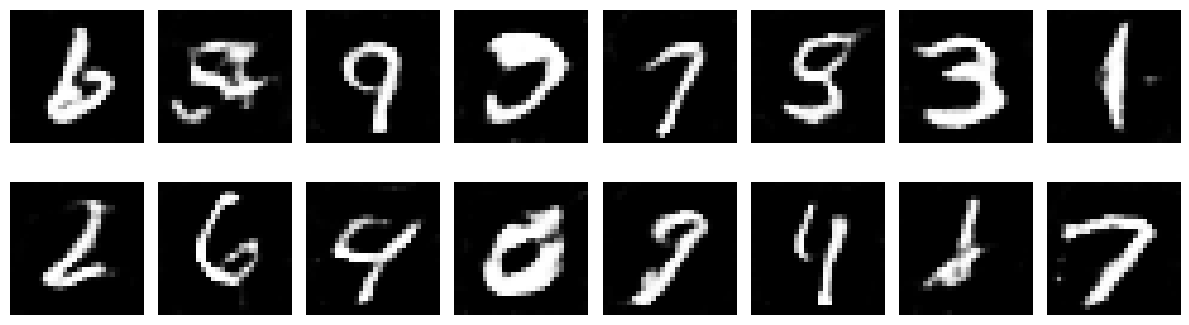

Epoch 8/100
Step 0/938 [D loss: 0.6479, acc.: 64.06%] [G loss: 0.8857]
Step 100/938 [D loss: 0.6599, acc.: 67.19%] [G loss: 0.8858]
Step 200/938 [D loss: 0.6854, acc.: 64.84%] [G loss: 0.9233]
Step 300/938 [D loss: 0.6568, acc.: 61.72%] [G loss: 0.9263]
Step 400/938 [D loss: 0.6724, acc.: 62.50%] [G loss: 0.9387]
Step 500/938 [D loss: 0.6636, acc.: 66.41%] [G loss: 0.9287]
Step 600/938 [D loss: 0.6546, acc.: 67.19%] [G loss: 0.9149]
Step 700/938 [D loss: 0.6657, acc.: 64.06%] [G loss: 0.9263]
Step 800/938 [D loss: 0.6764, acc.: 57.81%] [G loss: 0.8920]
Step 900/938 [D loss: 0.6837, acc.: 60.94%] [G loss: 0.8984]
1/1 [==============================] - 0s 25ms/step


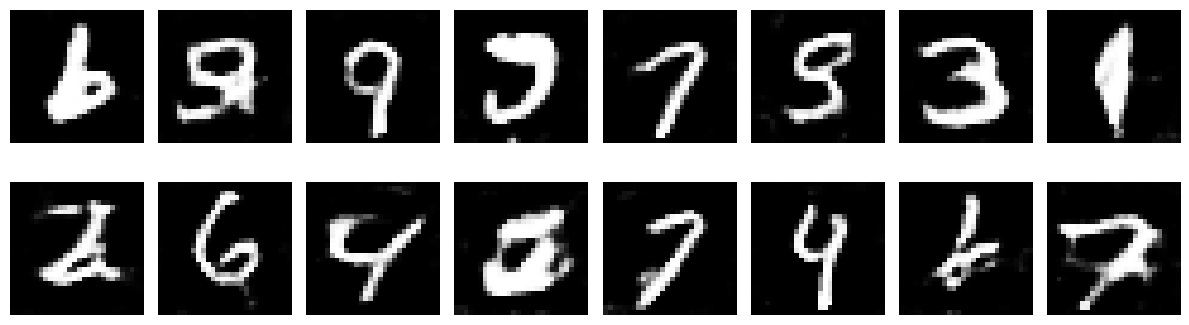

Epoch 9/100
Step 0/938 [D loss: 0.6528, acc.: 71.09%] [G loss: 0.9405]
Step 100/938 [D loss: 0.6437, acc.: 63.28%] [G loss: 1.0325]
Step 200/938 [D loss: 0.6478, acc.: 67.19%] [G loss: 0.8954]
Step 300/938 [D loss: 0.6535, acc.: 68.75%] [G loss: 0.9601]
Step 400/938 [D loss: 0.6502, acc.: 69.53%] [G loss: 0.9189]
Step 500/938 [D loss: 0.6493, acc.: 64.06%] [G loss: 0.9446]
Step 600/938 [D loss: 0.6460, acc.: 67.19%] [G loss: 1.0120]
Step 700/938 [D loss: 0.6876, acc.: 63.28%] [G loss: 0.8547]
Step 800/938 [D loss: 0.6745, acc.: 66.41%] [G loss: 0.8818]
Step 900/938 [D loss: 0.6903, acc.: 60.94%] [G loss: 0.9038]
1/1 [==============================] - 0s 27ms/step


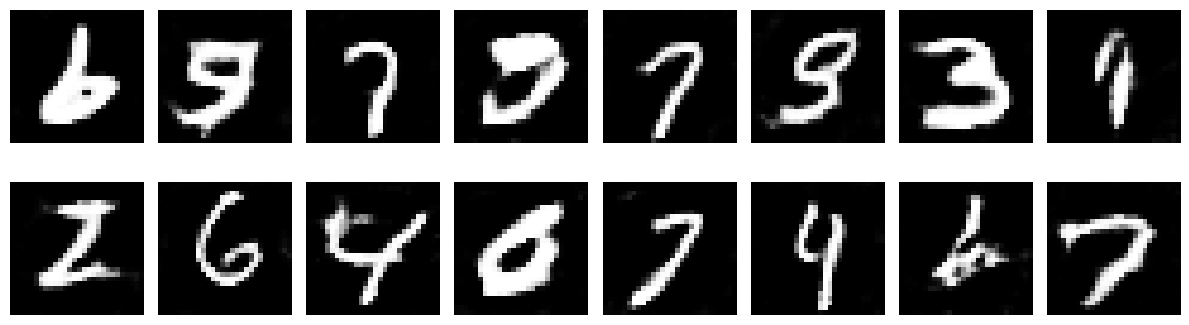

Epoch 10/100
Step 0/938 [D loss: 0.7196, acc.: 66.41%] [G loss: 0.8859]
Step 100/938 [D loss: 0.7054, acc.: 57.81%] [G loss: 0.8785]
Step 200/938 [D loss: 0.6672, acc.: 67.19%] [G loss: 0.9257]
Step 300/938 [D loss: 0.6942, acc.: 59.38%] [G loss: 0.9245]
Step 400/938 [D loss: 0.6574, acc.: 64.84%] [G loss: 0.9784]
Step 500/938 [D loss: 0.7006, acc.: 58.59%] [G loss: 0.8354]
Step 600/938 [D loss: 0.6628, acc.: 69.53%] [G loss: 0.9202]
Step 700/938 [D loss: 0.6441, acc.: 68.75%] [G loss: 0.8678]
Step 800/938 [D loss: 0.6561, acc.: 68.75%] [G loss: 0.9536]
Step 900/938 [D loss: 0.6771, acc.: 71.09%] [G loss: 0.9730]
1/1 [==============================] - 0s 25ms/step


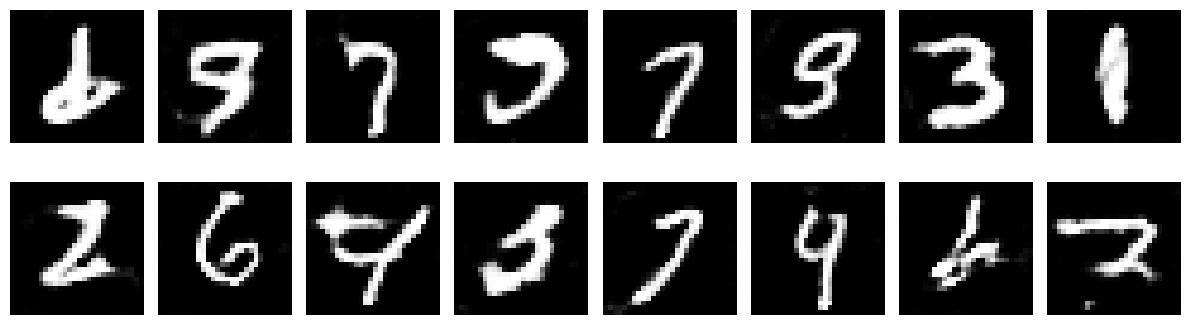

Epoch 11/100
Step 0/938 [D loss: 0.6771, acc.: 66.41%] [G loss: 0.8636]
Step 100/938 [D loss: 0.6881, acc.: 62.50%] [G loss: 0.8789]
Step 200/938 [D loss: 0.6606, acc.: 67.97%] [G loss: 0.9533]
Step 300/938 [D loss: 0.6660, acc.: 65.62%] [G loss: 0.9684]
Step 400/938 [D loss: 0.6412, acc.: 67.97%] [G loss: 1.0002]
Step 500/938 [D loss: 0.6896, acc.: 68.75%] [G loss: 0.8989]
Step 600/938 [D loss: 0.6468, acc.: 70.31%] [G loss: 0.9461]
Step 700/938 [D loss: 0.6772, acc.: 64.06%] [G loss: 0.9116]
Step 800/938 [D loss: 0.6913, acc.: 64.84%] [G loss: 0.9136]
Step 900/938 [D loss: 0.6615, acc.: 64.84%] [G loss: 0.9175]
1/1 [==============================] - 0s 26ms/step


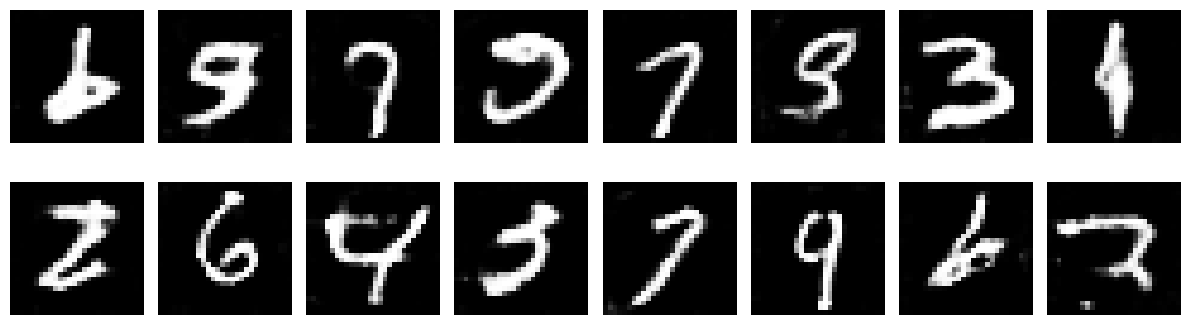

Epoch 12/100
Step 0/938 [D loss: 0.6586, acc.: 63.28%] [G loss: 0.9771]
Step 100/938 [D loss: 0.6634, acc.: 66.41%] [G loss: 0.9450]
Step 200/938 [D loss: 0.6641, acc.: 61.72%] [G loss: 0.9407]
Step 300/938 [D loss: 0.6733, acc.: 65.62%] [G loss: 0.9355]
Step 400/938 [D loss: 0.6773, acc.: 62.50%] [G loss: 0.9408]
Step 500/938 [D loss: 0.6773, acc.: 60.94%] [G loss: 1.0073]
Step 600/938 [D loss: 0.6831, acc.: 68.75%] [G loss: 0.8965]
Step 700/938 [D loss: 0.6367, acc.: 68.75%] [G loss: 0.9333]
Step 800/938 [D loss: 0.6703, acc.: 59.38%] [G loss: 0.9199]
Step 900/938 [D loss: 0.6592, acc.: 62.50%] [G loss: 0.9197]
1/1 [==============================] - 0s 25ms/step


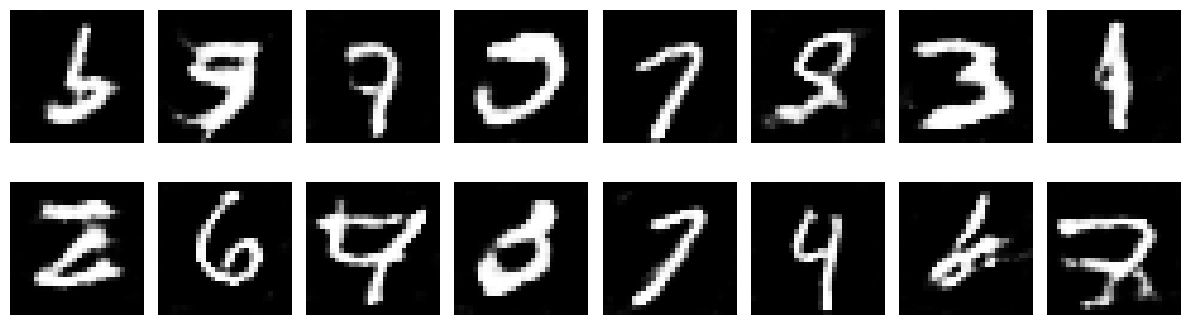

Epoch 13/100
Step 0/938 [D loss: 0.6383, acc.: 65.62%] [G loss: 0.9229]
Step 100/938 [D loss: 0.6631, acc.: 63.28%] [G loss: 0.9132]
Step 200/938 [D loss: 0.6712, acc.: 61.72%] [G loss: 0.8645]
Step 300/938 [D loss: 0.6581, acc.: 66.41%] [G loss: 0.9007]
Step 400/938 [D loss: 0.6727, acc.: 67.19%] [G loss: 0.9251]
Step 500/938 [D loss: 0.6534, acc.: 65.62%] [G loss: 0.9052]
Step 600/938 [D loss: 0.6578, acc.: 73.44%] [G loss: 0.9820]
Step 700/938 [D loss: 0.6439, acc.: 68.75%] [G loss: 0.9377]
Step 800/938 [D loss: 0.6512, acc.: 67.97%] [G loss: 0.8964]
Step 900/938 [D loss: 0.6616, acc.: 67.19%] [G loss: 0.9391]
1/1 [==============================] - 0s 27ms/step


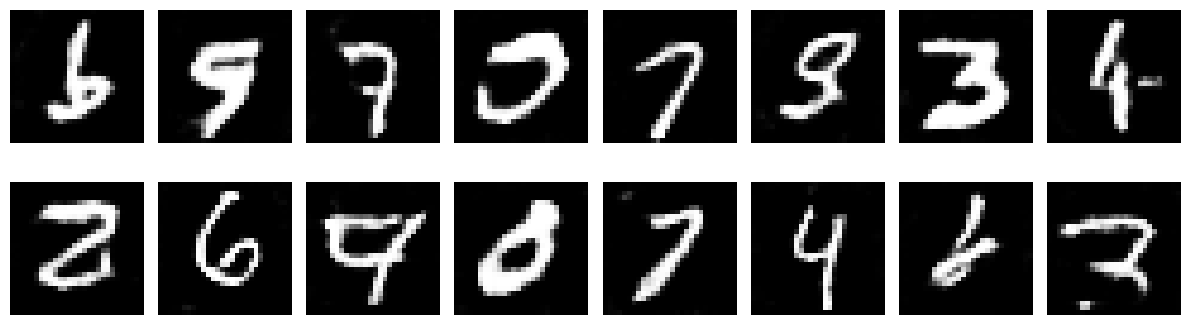

Epoch 14/100
Step 0/938 [D loss: 0.6742, acc.: 64.84%] [G loss: 0.9252]
Step 100/938 [D loss: 0.6957, acc.: 64.06%] [G loss: 0.8717]
Step 200/938 [D loss: 0.6835, acc.: 60.94%] [G loss: 0.9888]
Step 300/938 [D loss: 0.6674, acc.: 64.06%] [G loss: 0.9646]
Step 400/938 [D loss: 0.6662, acc.: 63.28%] [G loss: 0.9821]
Step 500/938 [D loss: 0.6830, acc.: 64.84%] [G loss: 0.9658]
Step 600/938 [D loss: 0.6652, acc.: 60.16%] [G loss: 0.9466]
Step 700/938 [D loss: 0.6568, acc.: 67.19%] [G loss: 0.9532]
Step 800/938 [D loss: 0.6499, acc.: 66.41%] [G loss: 0.9522]
Step 900/938 [D loss: 0.6853, acc.: 65.62%] [G loss: 0.9857]
1/1 [==============================] - 0s 25ms/step


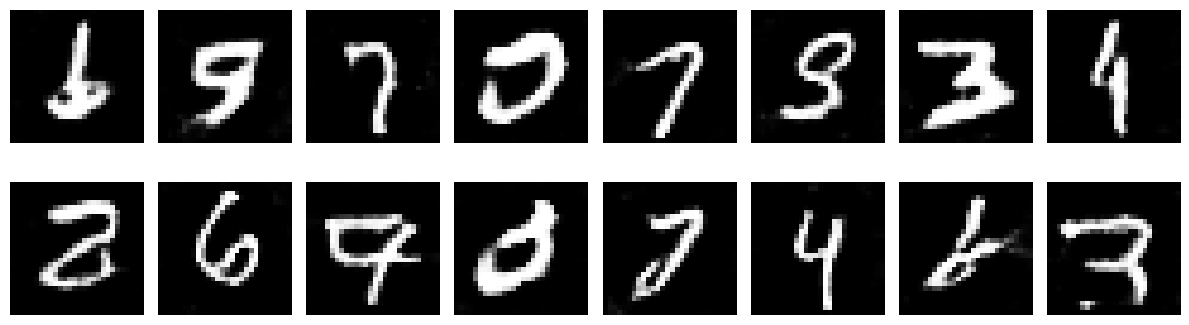

Epoch 15/100
Step 0/938 [D loss: 0.6757, acc.: 64.06%] [G loss: 0.8752]
Step 100/938 [D loss: 0.6838, acc.: 65.62%] [G loss: 0.9211]
Step 200/938 [D loss: 0.6428, acc.: 73.44%] [G loss: 0.8965]
Step 300/938 [D loss: 0.6746, acc.: 68.75%] [G loss: 0.8643]
Step 400/938 [D loss: 0.6738, acc.: 68.75%] [G loss: 0.9344]
Step 500/938 [D loss: 0.6506, acc.: 63.28%] [G loss: 0.9131]
Step 600/938 [D loss: 0.6615, acc.: 65.62%] [G loss: 0.9157]
Step 700/938 [D loss: 0.6598, acc.: 64.06%] [G loss: 0.9608]
Step 800/938 [D loss: 0.6638, acc.: 71.88%] [G loss: 0.9808]
Step 900/938 [D loss: 0.6382, acc.: 66.41%] [G loss: 0.9554]
1/1 [==============================] - 0s 24ms/step


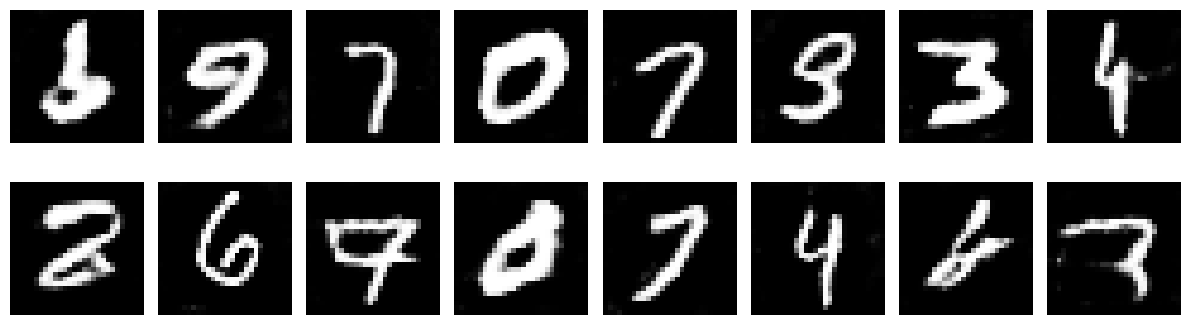

Epoch 16/100
Step 0/938 [D loss: 0.6309, acc.: 77.34%] [G loss: 0.9363]
Step 100/938 [D loss: 0.6770, acc.: 64.84%] [G loss: 0.9576]
Step 200/938 [D loss: 0.6717, acc.: 67.97%] [G loss: 0.9810]
Step 300/938 [D loss: 0.6788, acc.: 64.84%] [G loss: 0.9042]
Step 400/938 [D loss: 0.6506, acc.: 71.88%] [G loss: 0.9601]
Step 500/938 [D loss: 0.6436, acc.: 71.09%] [G loss: 0.9059]
Step 600/938 [D loss: 0.6597, acc.: 67.19%] [G loss: 0.9294]
Step 700/938 [D loss: 0.6720, acc.: 63.28%] [G loss: 1.0073]
Step 800/938 [D loss: 0.6684, acc.: 67.19%] [G loss: 0.9221]
Step 900/938 [D loss: 0.6509, acc.: 68.75%] [G loss: 0.9684]
1/1 [==============================] - 0s 28ms/step


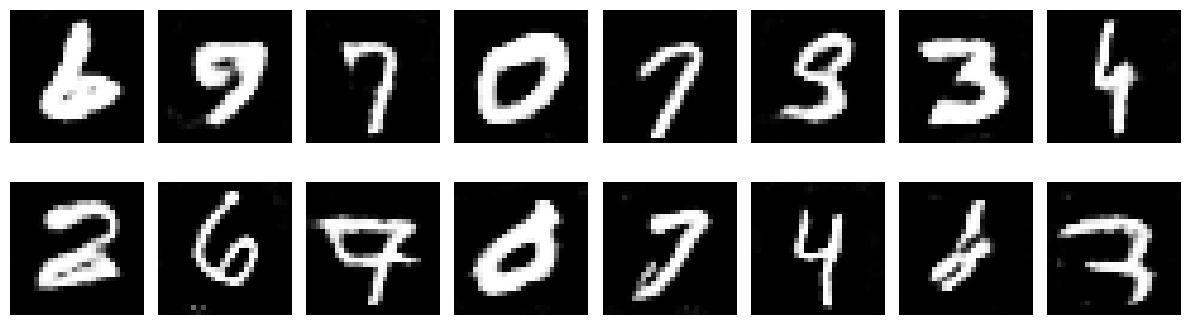

Epoch 17/100
Step 0/938 [D loss: 0.6597, acc.: 69.53%] [G loss: 1.0768]
Step 100/938 [D loss: 0.6811, acc.: 63.28%] [G loss: 0.9170]
Step 200/938 [D loss: 0.6613, acc.: 64.84%] [G loss: 0.9366]
Step 300/938 [D loss: 0.6712, acc.: 58.59%] [G loss: 0.9336]
Step 400/938 [D loss: 0.6554, acc.: 66.41%] [G loss: 0.9647]
Step 500/938 [D loss: 0.6678, acc.: 63.28%] [G loss: 0.9481]
Step 600/938 [D loss: 0.6683, acc.: 68.75%] [G loss: 0.9137]
Step 700/938 [D loss: 0.6488, acc.: 66.41%] [G loss: 0.9441]
Step 800/938 [D loss: 0.6227, acc.: 69.53%] [G loss: 0.9696]
Step 900/938 [D loss: 0.6673, acc.: 69.53%] [G loss: 0.9820]
1/1 [==============================] - 0s 26ms/step


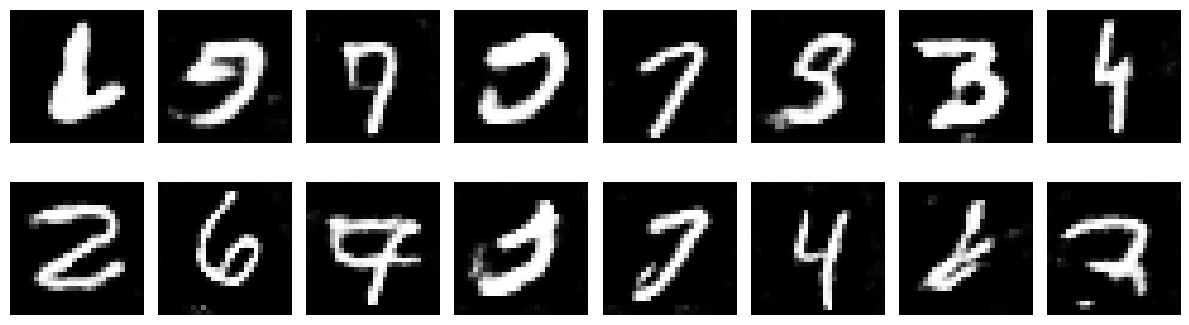

Epoch 18/100
Step 0/938 [D loss: 0.6794, acc.: 62.50%] [G loss: 0.9694]
Step 100/938 [D loss: 0.6722, acc.: 71.88%] [G loss: 0.9302]
Step 200/938 [D loss: 0.6484, acc.: 67.19%] [G loss: 0.9413]
Step 300/938 [D loss: 0.6824, acc.: 64.06%] [G loss: 0.9735]
Step 400/938 [D loss: 0.6405, acc.: 64.84%] [G loss: 0.9225]
Step 500/938 [D loss: 0.6911, acc.: 68.75%] [G loss: 0.9075]
Step 600/938 [D loss: 0.6700, acc.: 64.84%] [G loss: 0.9787]
Step 700/938 [D loss: 0.7195, acc.: 61.72%] [G loss: 0.9742]
Step 800/938 [D loss: 0.6570, acc.: 66.41%] [G loss: 0.9248]
Step 900/938 [D loss: 0.6311, acc.: 71.09%] [G loss: 0.9814]
1/1 [==============================] - 0s 35ms/step


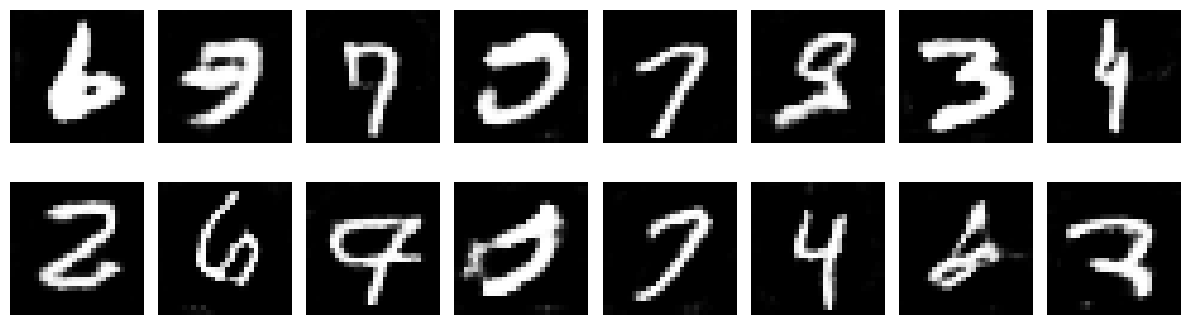

Epoch 19/100
Step 0/938 [D loss: 0.6835, acc.: 62.50%] [G loss: 0.9092]
Step 100/938 [D loss: 0.6697, acc.: 65.62%] [G loss: 0.9200]
Step 200/938 [D loss: 0.6678, acc.: 68.75%] [G loss: 0.9764]
Step 300/938 [D loss: 0.6514, acc.: 62.50%] [G loss: 0.9699]
Step 400/938 [D loss: 0.6568, acc.: 69.53%] [G loss: 0.9185]
Step 500/938 [D loss: 0.6567, acc.: 67.97%] [G loss: 0.9875]
Step 600/938 [D loss: 0.6572, acc.: 68.75%] [G loss: 0.9386]
Step 700/938 [D loss: 0.6811, acc.: 67.19%] [G loss: 0.9235]
Step 800/938 [D loss: 0.6768, acc.: 63.28%] [G loss: 0.9669]
Step 900/938 [D loss: 0.6692, acc.: 62.50%] [G loss: 0.9517]
1/1 [==============================] - 0s 29ms/step


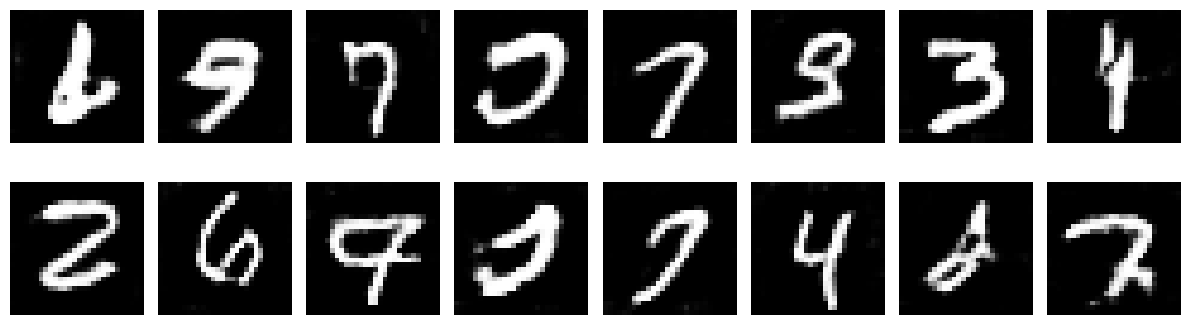

Epoch 20/100
Step 0/938 [D loss: 0.6513, acc.: 66.41%] [G loss: 0.9809]
Step 100/938 [D loss: 0.6557, acc.: 65.62%] [G loss: 0.9640]
Step 200/938 [D loss: 0.6635, acc.: 72.66%] [G loss: 0.9221]
Step 300/938 [D loss: 0.6636, acc.: 66.41%] [G loss: 0.9435]
Step 400/938 [D loss: 0.6918, acc.: 65.62%] [G loss: 0.9959]
Step 500/938 [D loss: 0.6609, acc.: 69.53%] [G loss: 0.9627]
Step 600/938 [D loss: 0.7014, acc.: 67.19%] [G loss: 0.9598]
Step 700/938 [D loss: 0.6445, acc.: 61.72%] [G loss: 0.9870]
Step 800/938 [D loss: 0.6601, acc.: 67.19%] [G loss: 0.8708]
Step 900/938 [D loss: 0.6584, acc.: 66.41%] [G loss: 1.0151]
1/1 [==============================] - 0s 23ms/step


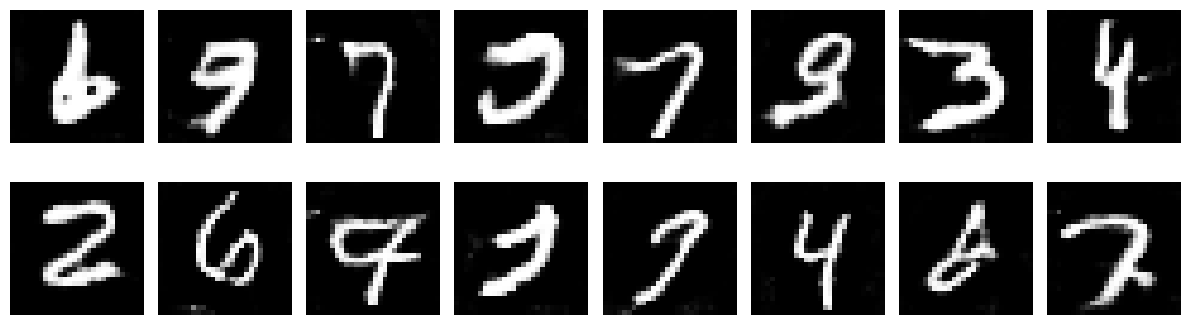

Epoch 21/100
Step 0/938 [D loss: 0.6408, acc.: 69.53%] [G loss: 1.0396]
Step 100/938 [D loss: 0.6604, acc.: 69.53%] [G loss: 0.9580]
Step 200/938 [D loss: 0.6764, acc.: 60.94%] [G loss: 0.9606]
Step 300/938 [D loss: 0.6639, acc.: 64.06%] [G loss: 0.9606]
Step 400/938 [D loss: 0.6474, acc.: 67.19%] [G loss: 0.9255]
Step 500/938 [D loss: 0.6665, acc.: 69.53%] [G loss: 1.0096]
Step 600/938 [D loss: 0.6730, acc.: 70.31%] [G loss: 0.9169]
Step 700/938 [D loss: 0.6675, acc.: 64.06%] [G loss: 0.9528]
Step 800/938 [D loss: 0.6756, acc.: 64.06%] [G loss: 0.9708]
Step 900/938 [D loss: 0.6496, acc.: 67.97%] [G loss: 0.9722]
1/1 [==============================] - 0s 25ms/step


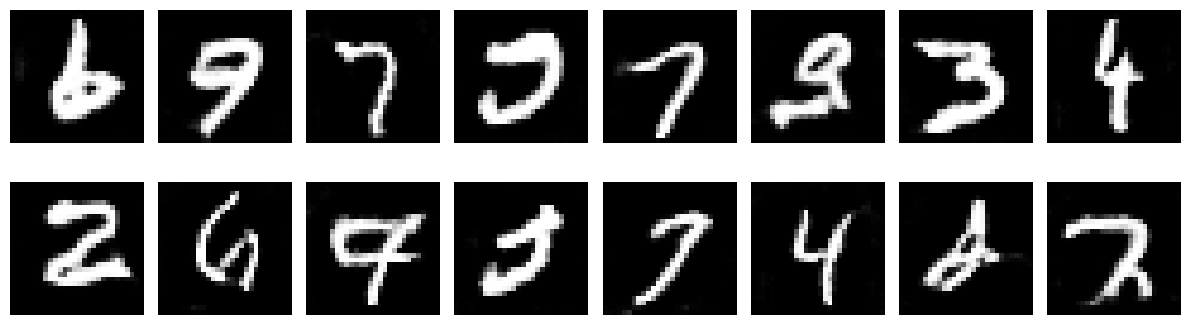

Epoch 22/100
Step 0/938 [D loss: 0.6809, acc.: 68.75%] [G loss: 0.9198]
Step 100/938 [D loss: 0.6506, acc.: 67.19%] [G loss: 0.9065]
Step 200/938 [D loss: 0.6786, acc.: 67.19%] [G loss: 0.9442]
Step 300/938 [D loss: 0.6481, acc.: 70.31%] [G loss: 0.9729]
Step 400/938 [D loss: 0.6824, acc.: 67.19%] [G loss: 0.9274]
Step 500/938 [D loss: 0.6465, acc.: 71.09%] [G loss: 1.0023]
Step 600/938 [D loss: 0.6464, acc.: 67.97%] [G loss: 1.0434]
Step 700/938 [D loss: 0.6497, acc.: 67.19%] [G loss: 0.9894]
Step 800/938 [D loss: 0.6577, acc.: 71.88%] [G loss: 0.8821]
Step 900/938 [D loss: 0.6827, acc.: 67.97%] [G loss: 0.9381]
1/1 [==============================] - 0s 25ms/step


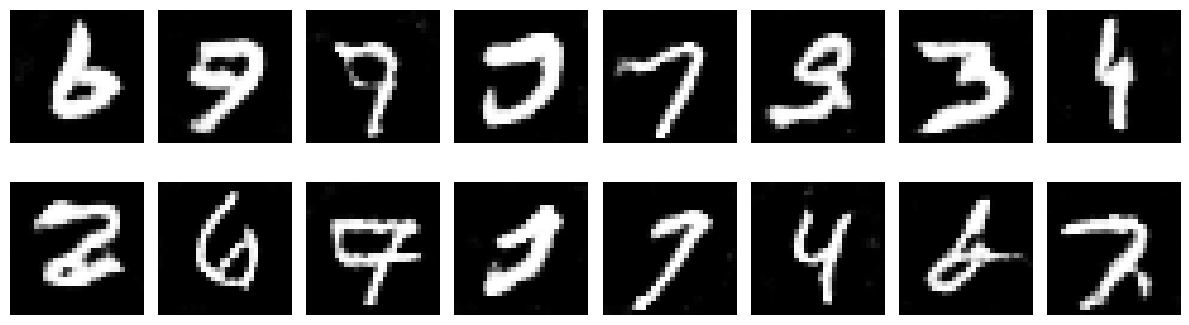

Epoch 23/100
Step 0/938 [D loss: 0.6781, acc.: 61.72%] [G loss: 0.9781]
Step 100/938 [D loss: 0.6824, acc.: 67.97%] [G loss: 1.0370]
Step 200/938 [D loss: 0.6565, acc.: 66.41%] [G loss: 0.9287]
Step 300/938 [D loss: 0.6321, acc.: 70.31%] [G loss: 0.9075]
Step 400/938 [D loss: 0.6428, acc.: 67.97%] [G loss: 0.9704]
Step 500/938 [D loss: 0.6697, acc.: 65.62%] [G loss: 0.9484]
Step 600/938 [D loss: 0.6434, acc.: 67.97%] [G loss: 0.9658]
Step 700/938 [D loss: 0.6656, acc.: 68.75%] [G loss: 0.9239]
Step 800/938 [D loss: 0.6606, acc.: 67.97%] [G loss: 0.9649]
Step 900/938 [D loss: 0.6834, acc.: 62.50%] [G loss: 0.9518]
1/1 [==============================] - 0s 24ms/step


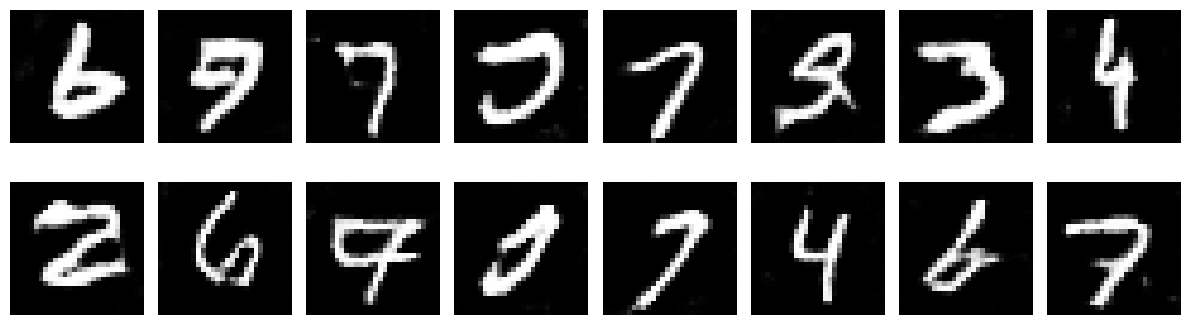

Epoch 24/100
Step 0/938 [D loss: 0.6542, acc.: 63.28%] [G loss: 0.9484]
Step 100/938 [D loss: 0.6790, acc.: 67.19%] [G loss: 0.9909]
Step 200/938 [D loss: 0.6721, acc.: 65.62%] [G loss: 1.0034]
Step 300/938 [D loss: 0.6666, acc.: 63.28%] [G loss: 0.9563]
Step 400/938 [D loss: 0.6884, acc.: 71.88%] [G loss: 0.9836]
Step 500/938 [D loss: 0.6560, acc.: 74.22%] [G loss: 0.9799]
Step 600/938 [D loss: 0.6612, acc.: 70.31%] [G loss: 0.9824]
Step 700/938 [D loss: 0.6896, acc.: 64.84%] [G loss: 0.9962]
Step 800/938 [D loss: 0.6746, acc.: 64.84%] [G loss: 0.9276]
Step 900/938 [D loss: 0.6845, acc.: 67.97%] [G loss: 0.9182]
1/1 [==============================] - 0s 26ms/step


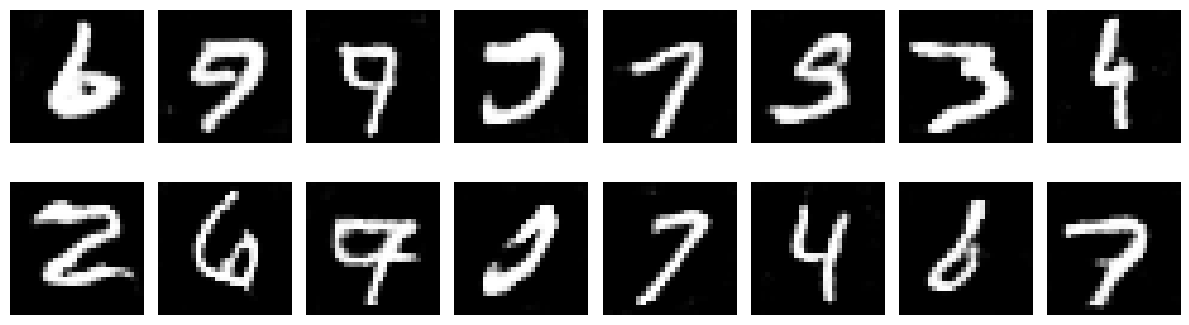

Epoch 25/100
Step 0/938 [D loss: 0.6664, acc.: 60.94%] [G loss: 0.9532]
Step 100/938 [D loss: 0.6519, acc.: 70.31%] [G loss: 0.9515]
Step 200/938 [D loss: 0.6597, acc.: 69.53%] [G loss: 0.9799]
Step 300/938 [D loss: 0.6648, acc.: 71.88%] [G loss: 0.9483]
Step 400/938 [D loss: 0.6350, acc.: 68.75%] [G loss: 0.9313]
Step 500/938 [D loss: 0.6773, acc.: 67.19%] [G loss: 0.9744]
Step 600/938 [D loss: 0.6727, acc.: 67.19%] [G loss: 0.9935]
Step 700/938 [D loss: 0.7054, acc.: 67.97%] [G loss: 0.9210]
Step 800/938 [D loss: 0.6777, acc.: 68.75%] [G loss: 0.9814]
Step 900/938 [D loss: 0.6632, acc.: 70.31%] [G loss: 0.9663]
1/1 [==============================] - 0s 23ms/step


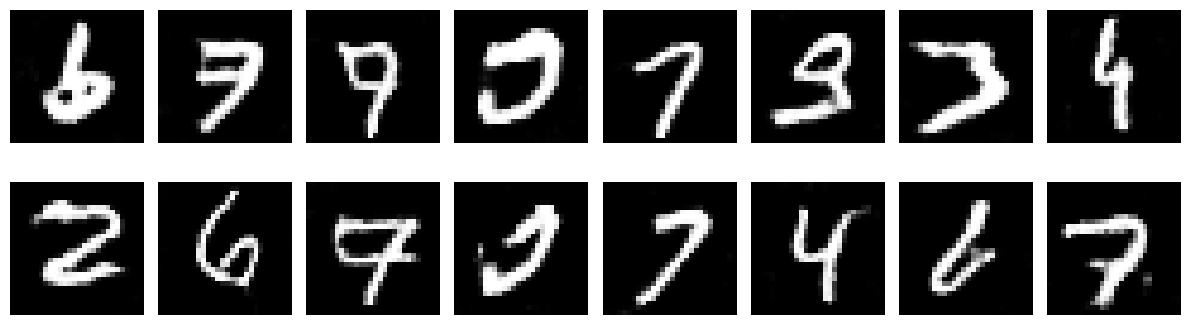

Epoch 26/100
Step 0/938 [D loss: 0.6447, acc.: 74.22%] [G loss: 0.9908]
Step 100/938 [D loss: 0.6474, acc.: 69.53%] [G loss: 0.9273]
Step 200/938 [D loss: 0.6796, acc.: 65.62%] [G loss: 0.9497]
Step 300/938 [D loss: 0.6450, acc.: 67.19%] [G loss: 1.0378]
Step 400/938 [D loss: 0.6554, acc.: 66.41%] [G loss: 0.9253]
Step 500/938 [D loss: 0.6810, acc.: 67.97%] [G loss: 0.9687]
Step 600/938 [D loss: 0.6625, acc.: 67.19%] [G loss: 0.9738]
Step 700/938 [D loss: 0.6802, acc.: 61.72%] [G loss: 0.9738]
Step 800/938 [D loss: 0.6368, acc.: 70.31%] [G loss: 0.9858]
Step 900/938 [D loss: 0.6718, acc.: 70.31%] [G loss: 0.9905]
1/1 [==============================] - 0s 25ms/step


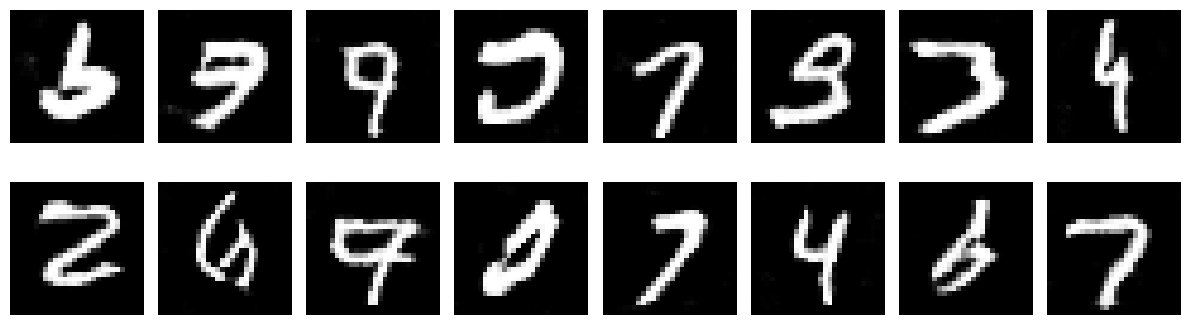

Epoch 27/100
Step 0/938 [D loss: 0.6698, acc.: 64.84%] [G loss: 0.9834]
Step 100/938 [D loss: 0.6635, acc.: 64.06%] [G loss: 1.0216]
Step 200/938 [D loss: 0.6609, acc.: 67.97%] [G loss: 1.0096]
Step 300/938 [D loss: 0.6616, acc.: 67.97%] [G loss: 1.0303]
Step 400/938 [D loss: 0.6756, acc.: 67.97%] [G loss: 0.9584]
Step 500/938 [D loss: 0.6607, acc.: 64.84%] [G loss: 0.9599]
Step 600/938 [D loss: 0.6274, acc.: 73.44%] [G loss: 0.9965]
Step 700/938 [D loss: 0.6688, acc.: 65.62%] [G loss: 0.9708]
Step 800/938 [D loss: 0.6629, acc.: 64.84%] [G loss: 0.9799]
Step 900/938 [D loss: 0.6228, acc.: 72.66%] [G loss: 0.9928]
1/1 [==============================] - 0s 25ms/step


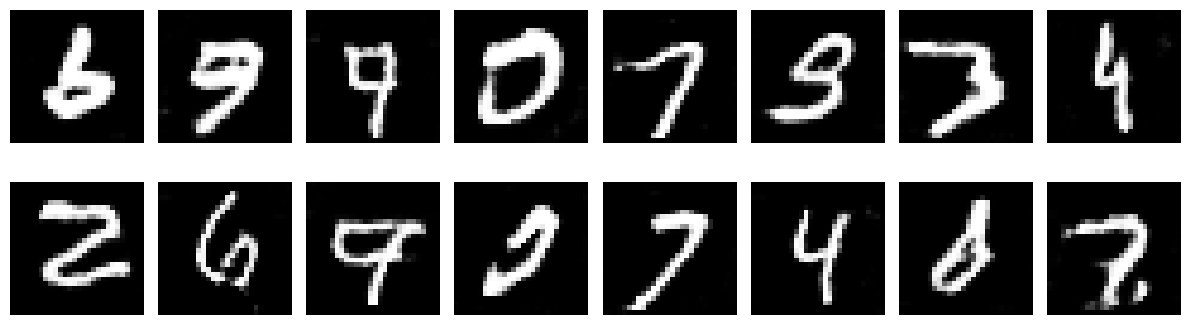

Epoch 28/100
Step 0/938 [D loss: 0.6443, acc.: 69.53%] [G loss: 0.9765]
Step 100/938 [D loss: 0.6730, acc.: 64.06%] [G loss: 0.9626]
Step 200/938 [D loss: 0.6609, acc.: 71.88%] [G loss: 0.9814]
Step 300/938 [D loss: 0.6760, acc.: 65.62%] [G loss: 0.9652]
Step 400/938 [D loss: 0.6603, acc.: 66.41%] [G loss: 1.0092]
Step 500/938 [D loss: 0.6375, acc.: 70.31%] [G loss: 0.9889]
Step 600/938 [D loss: 0.6565, acc.: 67.19%] [G loss: 0.9861]
Step 700/938 [D loss: 0.6579, acc.: 66.41%] [G loss: 0.9524]
Step 800/938 [D loss: 0.6534, acc.: 72.66%] [G loss: 0.9568]
Step 900/938 [D loss: 0.6938, acc.: 64.06%] [G loss: 1.0241]
1/1 [==============================] - 0s 27ms/step


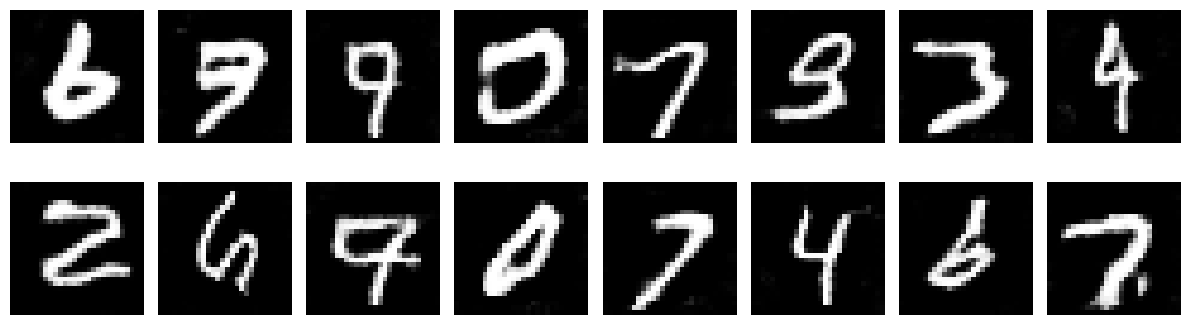

Epoch 29/100
Step 0/938 [D loss: 0.6430, acc.: 73.44%] [G loss: 0.9706]
Step 100/938 [D loss: 0.6746, acc.: 73.44%] [G loss: 0.9573]
Step 200/938 [D loss: 0.6830, acc.: 63.28%] [G loss: 0.9806]
Step 300/938 [D loss: 0.6170, acc.: 71.09%] [G loss: 0.9881]
Step 400/938 [D loss: 0.6587, acc.: 66.41%] [G loss: 0.9676]
Step 500/938 [D loss: 0.6447, acc.: 73.44%] [G loss: 0.9852]
Step 600/938 [D loss: 0.6444, acc.: 60.94%] [G loss: 0.9490]
Step 700/938 [D loss: 0.6856, acc.: 69.53%] [G loss: 0.9350]
Step 800/938 [D loss: 0.6649, acc.: 70.31%] [G loss: 0.9841]
Step 900/938 [D loss: 0.6692, acc.: 64.84%] [G loss: 1.0021]
1/1 [==============================] - 0s 25ms/step


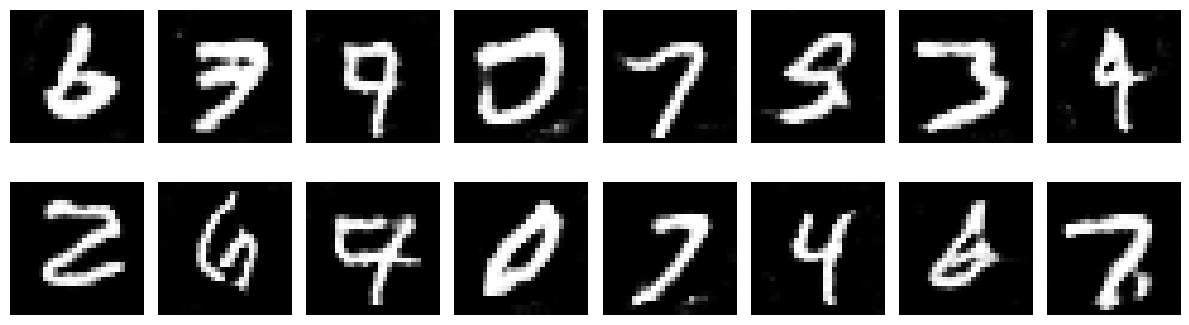

Epoch 30/100
Step 0/938 [D loss: 0.6920, acc.: 65.62%] [G loss: 0.9455]
Step 100/938 [D loss: 0.6481, acc.: 73.44%] [G loss: 0.9788]
Step 200/938 [D loss: 0.6495, acc.: 74.22%] [G loss: 1.0005]
Step 300/938 [D loss: 0.6728, acc.: 65.62%] [G loss: 0.9727]
Step 400/938 [D loss: 0.6263, acc.: 71.09%] [G loss: 0.9993]
Step 500/938 [D loss: 0.6451, acc.: 70.31%] [G loss: 1.0168]
Step 600/938 [D loss: 0.6633, acc.: 67.97%] [G loss: 0.9950]
Step 700/938 [D loss: 0.6611, acc.: 62.50%] [G loss: 0.9517]
Step 800/938 [D loss: 0.6492, acc.: 64.84%] [G loss: 0.9586]
Step 900/938 [D loss: 0.6376, acc.: 69.53%] [G loss: 1.0252]
1/1 [==============================] - 0s 33ms/step


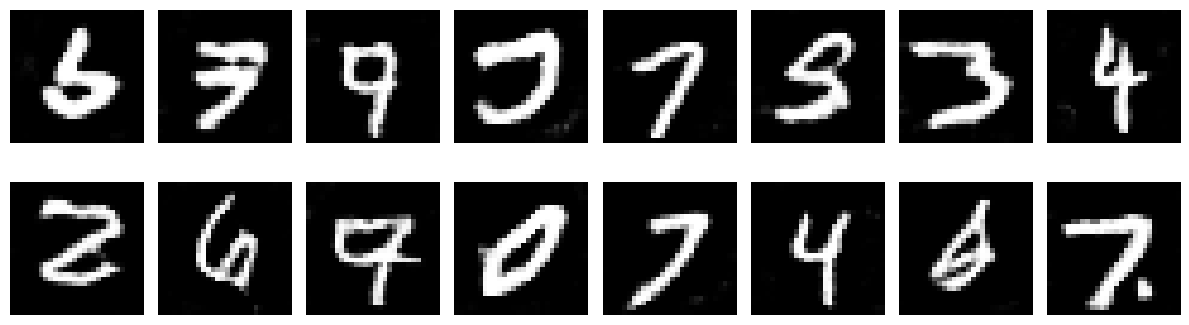

Epoch 31/100
Step 0/938 [D loss: 0.6456, acc.: 68.75%] [G loss: 1.0150]
Step 100/938 [D loss: 0.6541, acc.: 67.19%] [G loss: 0.9895]
Step 200/938 [D loss: 0.6609, acc.: 71.09%] [G loss: 0.9749]
Step 300/938 [D loss: 0.6459, acc.: 69.53%] [G loss: 1.0273]
Step 400/938 [D loss: 0.6403, acc.: 71.88%] [G loss: 0.9863]
Step 500/938 [D loss: 0.6651, acc.: 67.19%] [G loss: 0.9357]
Step 600/938 [D loss: 0.6635, acc.: 60.94%] [G loss: 0.9564]
Step 700/938 [D loss: 0.6658, acc.: 69.53%] [G loss: 0.9757]
Step 800/938 [D loss: 0.6433, acc.: 68.75%] [G loss: 1.0300]
Step 900/938 [D loss: 0.6142, acc.: 75.78%] [G loss: 0.9776]
1/1 [==============================] - 0s 28ms/step


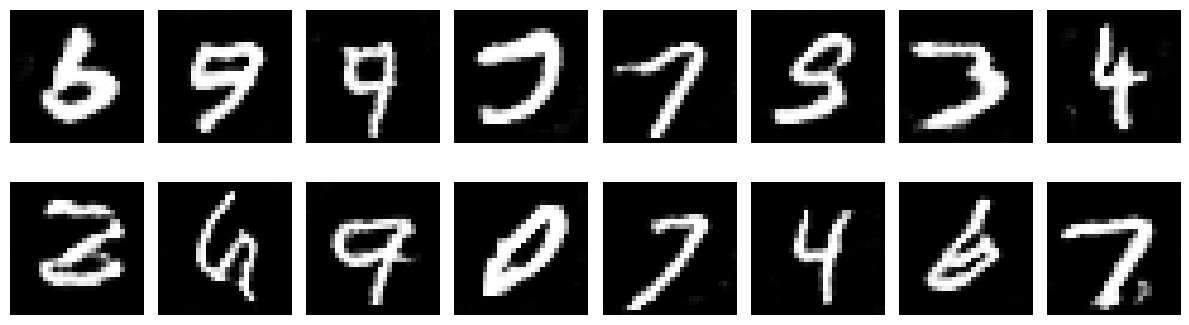

Epoch 32/100
Step 0/938 [D loss: 0.6745, acc.: 74.22%] [G loss: 0.9726]
Step 100/938 [D loss: 0.6405, acc.: 66.41%] [G loss: 1.0058]
Step 200/938 [D loss: 0.6525, acc.: 67.97%] [G loss: 0.9678]
Step 300/938 [D loss: 0.6154, acc.: 70.31%] [G loss: 0.9816]
Step 400/938 [D loss: 0.6693, acc.: 67.19%] [G loss: 0.9469]
Step 500/938 [D loss: 0.6763, acc.: 61.72%] [G loss: 0.9836]
Step 600/938 [D loss: 0.6279, acc.: 71.88%] [G loss: 1.0186]
Step 700/938 [D loss: 0.6420, acc.: 71.88%] [G loss: 0.9807]
Step 800/938 [D loss: 0.6659, acc.: 71.88%] [G loss: 0.9137]
Step 900/938 [D loss: 0.6429, acc.: 72.66%] [G loss: 0.9701]
1/1 [==============================] - 0s 29ms/step


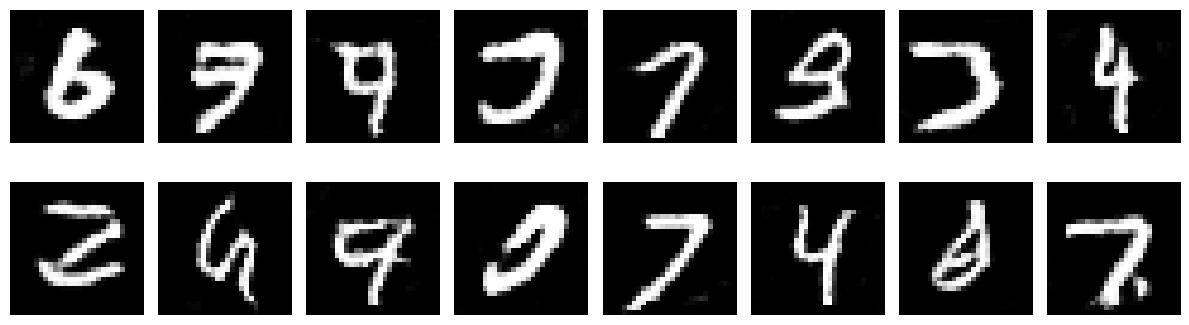

Epoch 33/100
Step 0/938 [D loss: 0.6471, acc.: 71.88%] [G loss: 0.9644]
Step 100/938 [D loss: 0.6703, acc.: 64.06%] [G loss: 0.9695]
Step 200/938 [D loss: 0.6781, acc.: 64.84%] [G loss: 0.9982]
Step 300/938 [D loss: 0.6413, acc.: 71.88%] [G loss: 0.9723]
Step 400/938 [D loss: 0.6897, acc.: 67.97%] [G loss: 0.9789]
Step 500/938 [D loss: 0.6671, acc.: 69.53%] [G loss: 0.9977]
Step 600/938 [D loss: 0.6711, acc.: 67.97%] [G loss: 0.9869]
Step 700/938 [D loss: 0.6687, acc.: 67.19%] [G loss: 1.0129]
Step 800/938 [D loss: 0.6520, acc.: 72.66%] [G loss: 0.9533]
Step 900/938 [D loss: 0.6831, acc.: 67.97%] [G loss: 0.9887]
1/1 [==============================] - 0s 26ms/step


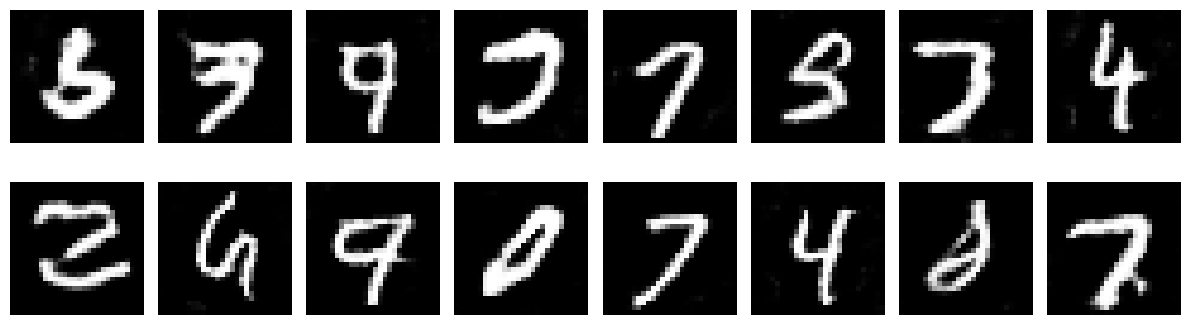

Epoch 34/100
Step 0/938 [D loss: 0.6874, acc.: 70.31%] [G loss: 1.0721]
Step 100/938 [D loss: 0.6265, acc.: 75.78%] [G loss: 1.0562]
Step 200/938 [D loss: 0.6963, acc.: 61.72%] [G loss: 0.9838]
Step 300/938 [D loss: 0.6501, acc.: 71.09%] [G loss: 0.9811]
Step 400/938 [D loss: 0.6616, acc.: 67.19%] [G loss: 0.9861]
Step 500/938 [D loss: 0.6389, acc.: 71.09%] [G loss: 1.0285]
Step 600/938 [D loss: 0.6509, acc.: 69.53%] [G loss: 0.9641]
Step 700/938 [D loss: 0.6591, acc.: 67.19%] [G loss: 0.9893]
Step 800/938 [D loss: 0.6973, acc.: 68.75%] [G loss: 1.0175]
Step 900/938 [D loss: 0.6601, acc.: 68.75%] [G loss: 0.9821]
1/1 [==============================] - 0s 25ms/step


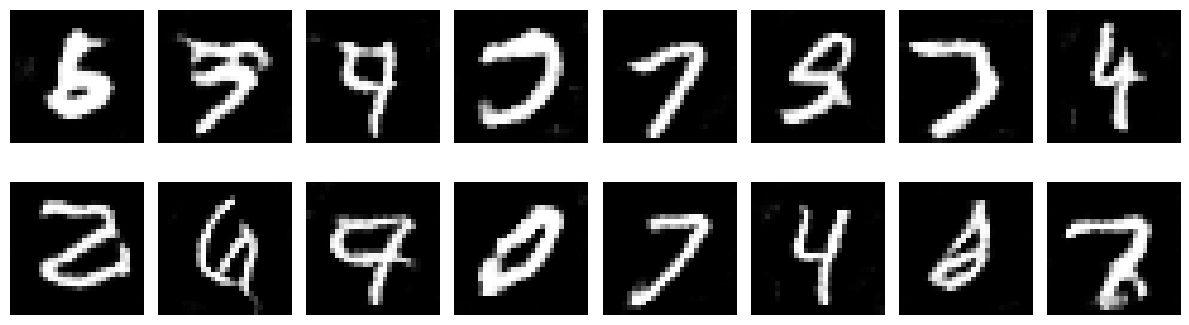

Epoch 35/100
Step 0/938 [D loss: 0.6498, acc.: 68.75%] [G loss: 0.9589]
Step 100/938 [D loss: 0.7129, acc.: 62.50%] [G loss: 1.0027]
Step 200/938 [D loss: 0.6538, acc.: 71.09%] [G loss: 0.9864]
Step 300/938 [D loss: 0.6618, acc.: 66.41%] [G loss: 1.0210]
Step 400/938 [D loss: 0.6603, acc.: 65.62%] [G loss: 1.0613]
Step 500/938 [D loss: 0.6482, acc.: 66.41%] [G loss: 0.9556]
Step 600/938 [D loss: 0.6329, acc.: 70.31%] [G loss: 0.9684]
Step 700/938 [D loss: 0.6785, acc.: 64.84%] [G loss: 1.0810]
Step 800/938 [D loss: 0.6643, acc.: 72.66%] [G loss: 0.9425]
Step 900/938 [D loss: 0.6558, acc.: 71.09%] [G loss: 0.9334]
1/1 [==============================] - 0s 25ms/step


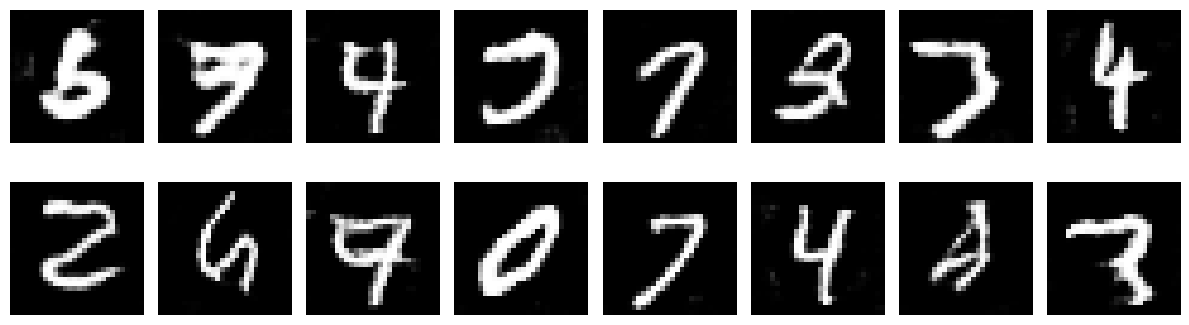

Epoch 36/100
Step 0/938 [D loss: 0.6817, acc.: 67.97%] [G loss: 0.9713]
Step 100/938 [D loss: 0.6529, acc.: 74.22%] [G loss: 0.9809]
Step 200/938 [D loss: 0.6297, acc.: 71.09%] [G loss: 0.9724]
Step 300/938 [D loss: 0.6477, acc.: 71.88%] [G loss: 0.9702]
Step 400/938 [D loss: 0.6660, acc.: 70.31%] [G loss: 0.9610]
Step 500/938 [D loss: 0.6426, acc.: 71.09%] [G loss: 0.9772]
Step 600/938 [D loss: 0.6532, acc.: 66.41%] [G loss: 0.9969]
Step 700/938 [D loss: 0.6643, acc.: 75.78%] [G loss: 0.9317]
Step 800/938 [D loss: 0.6653, acc.: 71.09%] [G loss: 1.0112]
Step 900/938 [D loss: 0.6308, acc.: 70.31%] [G loss: 0.9160]
1/1 [==============================] - 0s 26ms/step


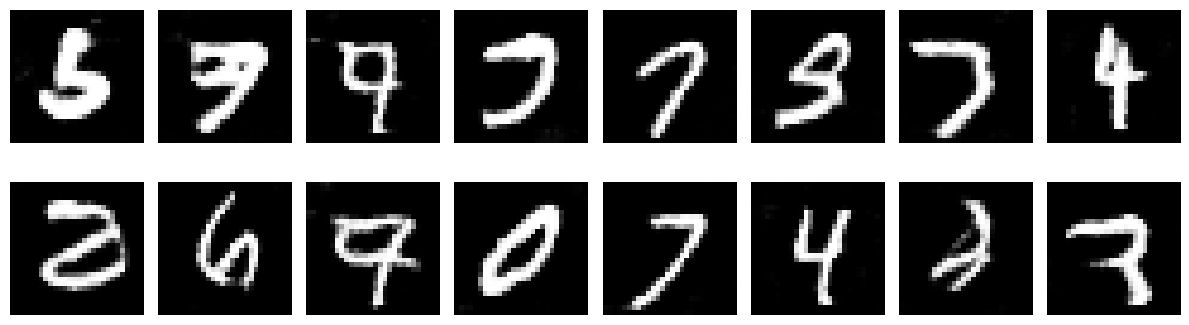

Epoch 37/100
Step 0/938 [D loss: 0.6473, acc.: 70.31%] [G loss: 0.9600]
Step 100/938 [D loss: 0.6580, acc.: 73.44%] [G loss: 1.0476]
Step 200/938 [D loss: 0.6700, acc.: 67.19%] [G loss: 0.9724]
Step 300/938 [D loss: 0.6499, acc.: 68.75%] [G loss: 0.9488]
Step 400/938 [D loss: 0.6553, acc.: 65.62%] [G loss: 1.0097]
Step 500/938 [D loss: 0.6597, acc.: 68.75%] [G loss: 1.0279]
Step 600/938 [D loss: 0.6685, acc.: 63.28%] [G loss: 0.9952]
Step 700/938 [D loss: 0.6511, acc.: 64.06%] [G loss: 1.0182]
Step 800/938 [D loss: 0.6462, acc.: 71.09%] [G loss: 0.9679]
Step 900/938 [D loss: 0.6494, acc.: 72.66%] [G loss: 0.9523]
1/1 [==============================] - 0s 35ms/step


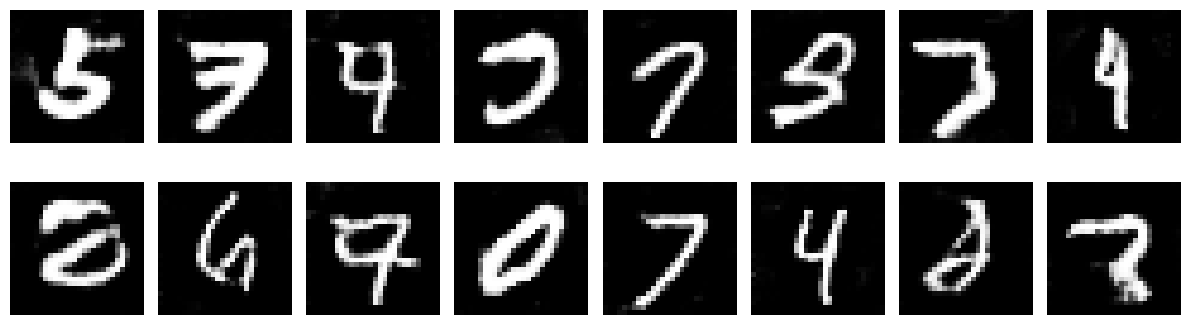

Epoch 38/100
Step 0/938 [D loss: 0.6377, acc.: 73.44%] [G loss: 0.9493]
Step 100/938 [D loss: 0.6599, acc.: 67.97%] [G loss: 1.0060]
Step 200/938 [D loss: 0.6776, acc.: 64.84%] [G loss: 0.8990]
Step 300/938 [D loss: 0.6816, acc.: 70.31%] [G loss: 0.9837]
Step 400/938 [D loss: 0.6507, acc.: 66.41%] [G loss: 1.0128]
Step 500/938 [D loss: 0.6136, acc.: 67.97%] [G loss: 0.9874]
Step 600/938 [D loss: 0.6306, acc.: 69.53%] [G loss: 1.0103]
Step 700/938 [D loss: 0.6083, acc.: 71.88%] [G loss: 0.9992]
Step 800/938 [D loss: 0.6817, acc.: 65.62%] [G loss: 0.9809]
Step 900/938 [D loss: 0.6778, acc.: 64.84%] [G loss: 1.0079]
1/1 [==============================] - 0s 28ms/step


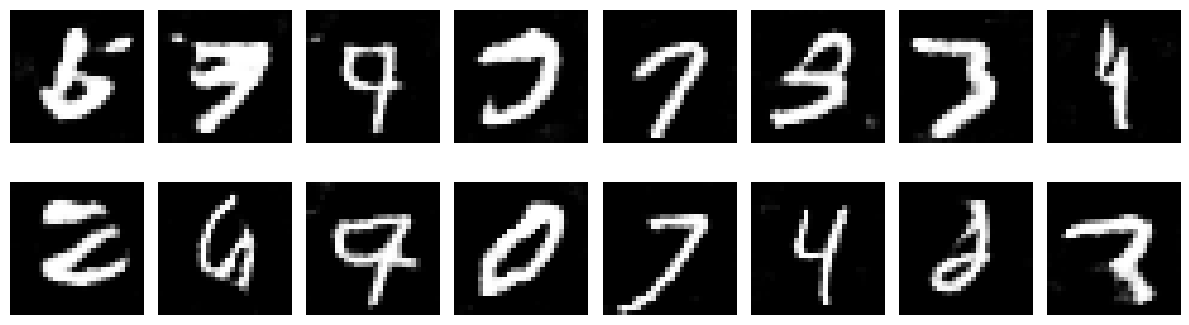

Epoch 39/100
Step 0/938 [D loss: 0.6989, acc.: 63.28%] [G loss: 1.0143]
Step 100/938 [D loss: 0.6423, acc.: 72.66%] [G loss: 1.0530]
Step 200/938 [D loss: 0.6583, acc.: 67.97%] [G loss: 0.9773]
Step 300/938 [D loss: 0.6683, acc.: 69.53%] [G loss: 1.0173]
Step 400/938 [D loss: 0.6635, acc.: 74.22%] [G loss: 1.0176]
Step 500/938 [D loss: 0.6690, acc.: 64.06%] [G loss: 1.0230]
Step 600/938 [D loss: 0.6516, acc.: 67.97%] [G loss: 0.9278]
Step 700/938 [D loss: 0.6476, acc.: 69.53%] [G loss: 1.0172]
Step 800/938 [D loss: 0.6358, acc.: 75.00%] [G loss: 1.0159]
Step 900/938 [D loss: 0.6205, acc.: 70.31%] [G loss: 0.9667]
1/1 [==============================] - 0s 24ms/step


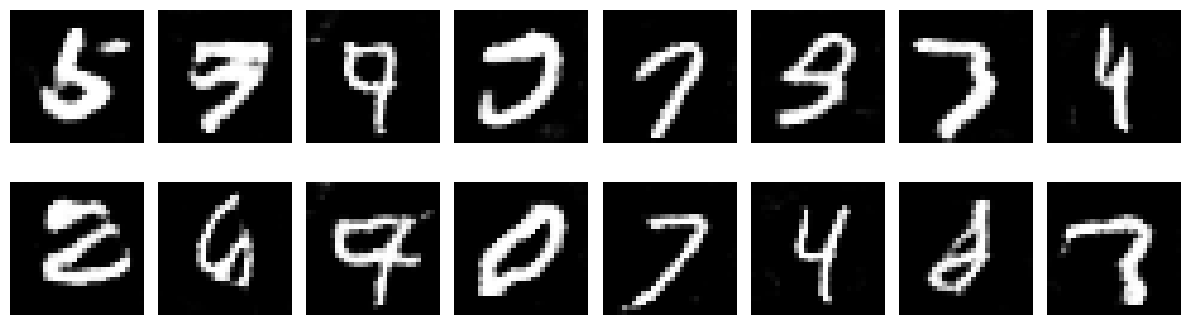

Epoch 40/100
Step 0/938 [D loss: 0.6539, acc.: 66.41%] [G loss: 1.0221]
Step 100/938 [D loss: 0.6416, acc.: 71.88%] [G loss: 1.0115]
Step 200/938 [D loss: 0.6307, acc.: 68.75%] [G loss: 1.0666]
Step 300/938 [D loss: 0.6537, acc.: 71.88%] [G loss: 1.0661]
Step 400/938 [D loss: 0.6670, acc.: 69.53%] [G loss: 0.9953]
Step 500/938 [D loss: 0.6696, acc.: 67.97%] [G loss: 1.0270]
Step 600/938 [D loss: 0.6522, acc.: 68.75%] [G loss: 1.0437]
Step 700/938 [D loss: 0.6707, acc.: 67.19%] [G loss: 0.9517]
Step 800/938 [D loss: 0.6446, acc.: 74.22%] [G loss: 0.9548]
Step 900/938 [D loss: 0.6731, acc.: 66.41%] [G loss: 1.0002]
1/1 [==============================] - 0s 25ms/step


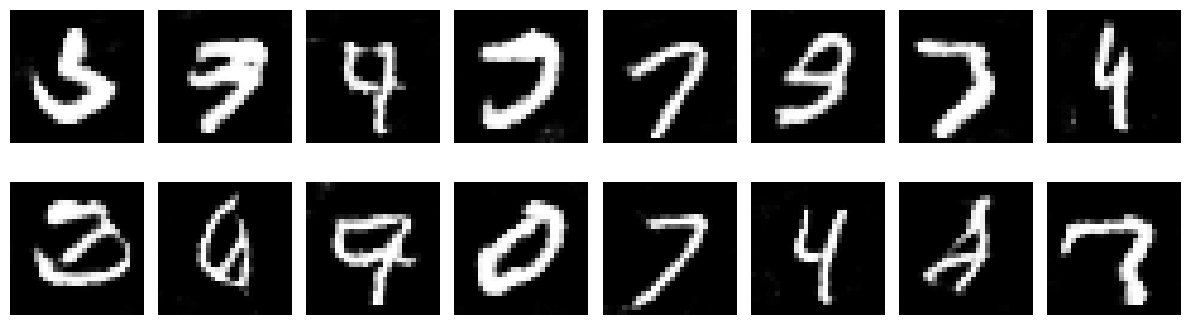

Epoch 41/100
Step 0/938 [D loss: 0.6983, acc.: 68.75%] [G loss: 1.0191]
Step 100/938 [D loss: 0.6494, acc.: 71.09%] [G loss: 1.0305]
Step 200/938 [D loss: 0.6449, acc.: 70.31%] [G loss: 0.9689]
Step 300/938 [D loss: 0.6546, acc.: 73.44%] [G loss: 0.9554]
Step 400/938 [D loss: 0.6586, acc.: 67.19%] [G loss: 1.0416]
Step 500/938 [D loss: 0.6581, acc.: 66.41%] [G loss: 0.9763]
Step 600/938 [D loss: 0.6345, acc.: 70.31%] [G loss: 0.9990]
Step 700/938 [D loss: 0.6525, acc.: 72.66%] [G loss: 0.9858]
Step 800/938 [D loss: 0.6264, acc.: 74.22%] [G loss: 1.0351]
Step 900/938 [D loss: 0.6796, acc.: 71.09%] [G loss: 1.0186]
1/1 [==============================] - 0s 22ms/step


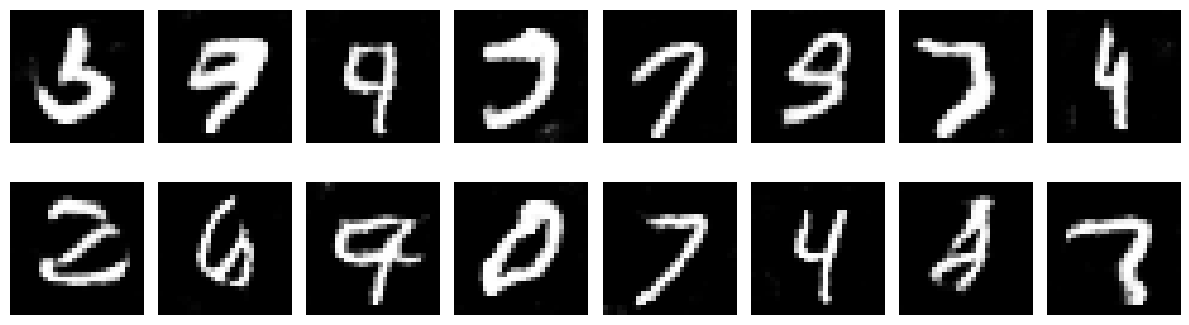

Epoch 42/100
Step 0/938 [D loss: 0.6314, acc.: 65.62%] [G loss: 1.0271]
Step 100/938 [D loss: 0.6552, acc.: 70.31%] [G loss: 0.9738]
Step 200/938 [D loss: 0.6344, acc.: 71.09%] [G loss: 0.9934]
Step 300/938 [D loss: 0.6487, acc.: 72.66%] [G loss: 0.9889]
Step 400/938 [D loss: 0.6325, acc.: 67.97%] [G loss: 1.0848]
Step 500/938 [D loss: 0.6961, acc.: 68.75%] [G loss: 1.0150]
Step 600/938 [D loss: 0.6760, acc.: 71.88%] [G loss: 1.0774]
Step 700/938 [D loss: 0.6411, acc.: 71.88%] [G loss: 0.9317]
Step 800/938 [D loss: 0.6662, acc.: 65.62%] [G loss: 0.9989]
Step 900/938 [D loss: 0.6730, acc.: 63.28%] [G loss: 1.0206]
1/1 [==============================] - 0s 25ms/step


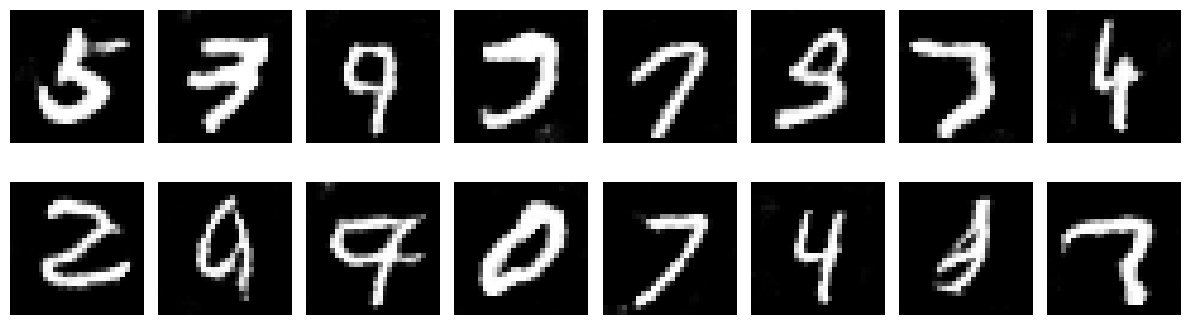

Epoch 43/100
Step 0/938 [D loss: 0.6704, acc.: 64.84%] [G loss: 1.0509]
Step 100/938 [D loss: 0.6368, acc.: 68.75%] [G loss: 0.9824]
Step 200/938 [D loss: 0.6776, acc.: 66.41%] [G loss: 1.0365]
Step 300/938 [D loss: 0.6469, acc.: 64.06%] [G loss: 1.0190]
Step 400/938 [D loss: 0.7059, acc.: 61.72%] [G loss: 0.9808]
Step 500/938 [D loss: 0.6583, acc.: 68.75%] [G loss: 1.0087]
Step 600/938 [D loss: 0.6465, acc.: 69.53%] [G loss: 0.9617]
Step 700/938 [D loss: 0.6163, acc.: 74.22%] [G loss: 0.9791]
Step 800/938 [D loss: 0.6510, acc.: 72.66%] [G loss: 0.9731]
Step 900/938 [D loss: 0.6660, acc.: 70.31%] [G loss: 1.0449]
1/1 [==============================] - 0s 31ms/step


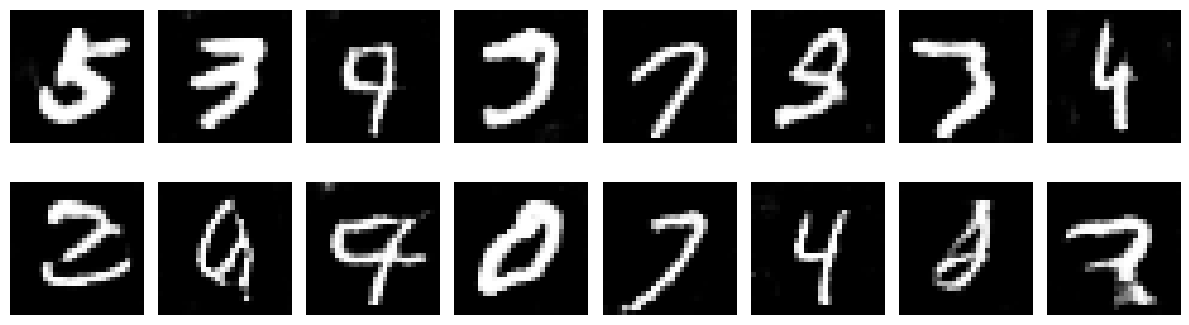

Epoch 44/100
Step 0/938 [D loss: 0.6675, acc.: 62.50%] [G loss: 1.0483]
Step 100/938 [D loss: 0.6255, acc.: 72.66%] [G loss: 0.9896]
Step 200/938 [D loss: 0.6756, acc.: 67.97%] [G loss: 1.0186]
Step 300/938 [D loss: 0.6591, acc.: 71.88%] [G loss: 0.9110]
Step 400/938 [D loss: 0.6657, acc.: 70.31%] [G loss: 1.0252]
Step 500/938 [D loss: 0.6458, acc.: 68.75%] [G loss: 1.0581]
Step 600/938 [D loss: 0.6377, acc.: 73.44%] [G loss: 0.9268]
Step 700/938 [D loss: 0.6360, acc.: 66.41%] [G loss: 1.0376]
Step 800/938 [D loss: 0.6352, acc.: 73.44%] [G loss: 0.9619]
Step 900/938 [D loss: 0.6665, acc.: 66.41%] [G loss: 0.9967]
1/1 [==============================] - 0s 26ms/step


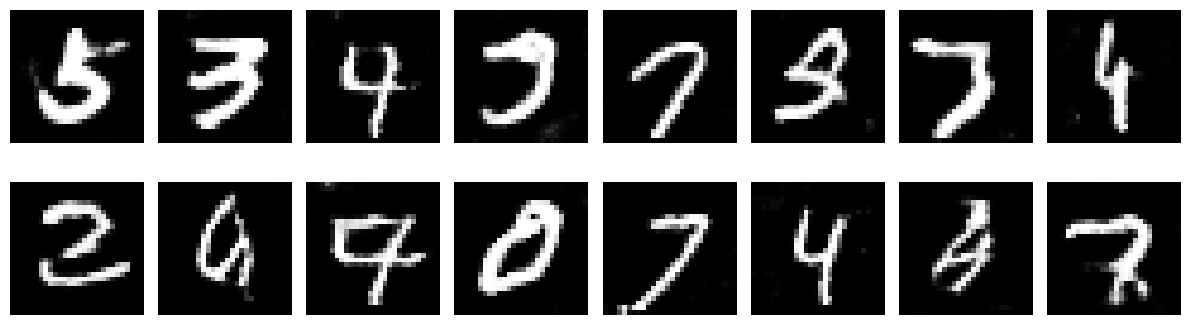

Epoch 45/100
Step 0/938 [D loss: 0.6489, acc.: 68.75%] [G loss: 0.9989]
Step 100/938 [D loss: 0.6865, acc.: 63.28%] [G loss: 1.0064]
Step 200/938 [D loss: 0.6536, acc.: 69.53%] [G loss: 1.0248]
Step 300/938 [D loss: 0.6791, acc.: 67.97%] [G loss: 0.9949]
Step 400/938 [D loss: 0.6399, acc.: 71.09%] [G loss: 1.1120]
Step 500/938 [D loss: 0.6082, acc.: 74.22%] [G loss: 1.0155]
Step 600/938 [D loss: 0.6599, acc.: 74.22%] [G loss: 1.0035]
Step 700/938 [D loss: 0.6806, acc.: 62.50%] [G loss: 1.0403]
Step 800/938 [D loss: 0.6510, acc.: 70.31%] [G loss: 0.9741]
Step 900/938 [D loss: 0.6404, acc.: 71.09%] [G loss: 1.0490]
1/1 [==============================] - 0s 25ms/step


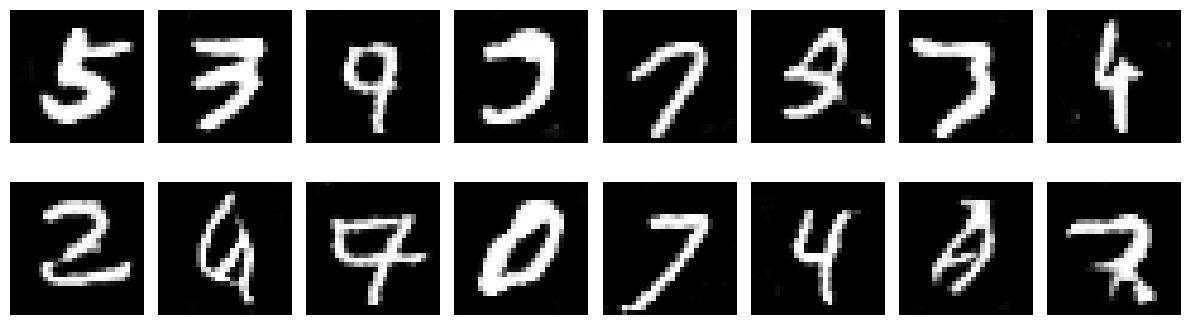

Epoch 46/100
Step 0/938 [D loss: 0.6255, acc.: 68.75%] [G loss: 1.0538]
Step 100/938 [D loss: 0.6591, acc.: 67.97%] [G loss: 1.0841]
Step 200/938 [D loss: 0.6489, acc.: 66.41%] [G loss: 1.0032]
Step 300/938 [D loss: 0.6340, acc.: 68.75%] [G loss: 1.1185]
Step 400/938 [D loss: 0.6735, acc.: 68.75%] [G loss: 0.9703]
Step 500/938 [D loss: 0.6075, acc.: 73.44%] [G loss: 1.1002]
Step 600/938 [D loss: 0.6384, acc.: 75.78%] [G loss: 1.0372]
Step 700/938 [D loss: 0.6509, acc.: 71.88%] [G loss: 0.9329]
Step 800/938 [D loss: 0.6655, acc.: 69.53%] [G loss: 0.9775]
Step 900/938 [D loss: 0.6543, acc.: 70.31%] [G loss: 1.0655]
1/1 [==============================] - 0s 29ms/step


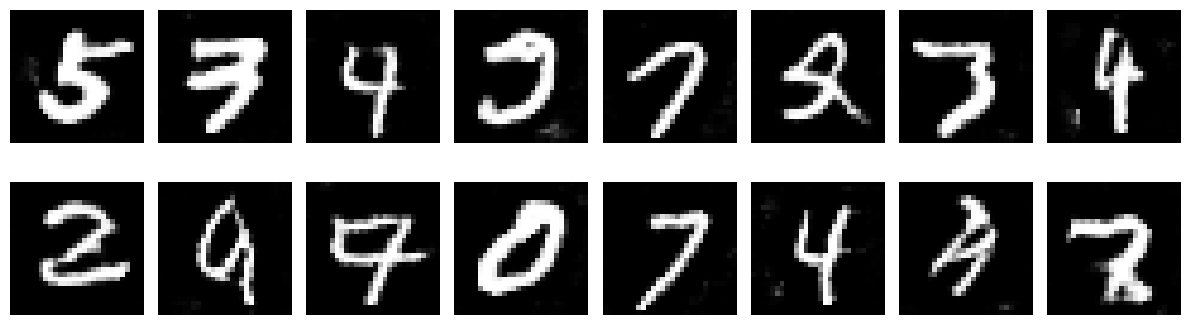

Epoch 47/100
Step 0/938 [D loss: 0.6752, acc.: 65.62%] [G loss: 1.0159]
Step 100/938 [D loss: 0.6953, acc.: 67.97%] [G loss: 0.9488]
Step 200/938 [D loss: 0.6500, acc.: 67.19%] [G loss: 1.0261]
Step 300/938 [D loss: 0.7030, acc.: 67.97%] [G loss: 1.0401]
Step 400/938 [D loss: 0.6668, acc.: 73.44%] [G loss: 1.0443]
Step 500/938 [D loss: 0.6890, acc.: 62.50%] [G loss: 1.0172]
Step 600/938 [D loss: 0.6672, acc.: 67.19%] [G loss: 0.9816]
Step 700/938 [D loss: 0.6952, acc.: 72.66%] [G loss: 1.0605]
Step 800/938 [D loss: 0.6335, acc.: 77.34%] [G loss: 1.0862]
Step 900/938 [D loss: 0.6476, acc.: 76.56%] [G loss: 1.0754]
1/1 [==============================] - 0s 26ms/step


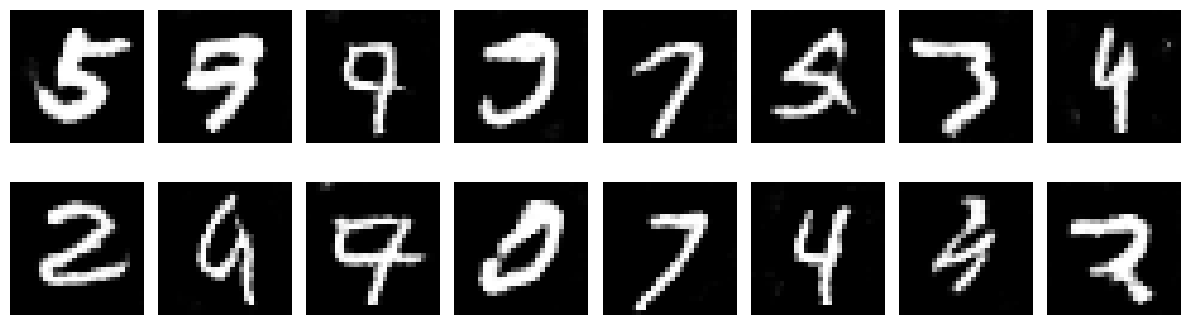

Epoch 48/100
Step 0/938 [D loss: 0.6506, acc.: 69.53%] [G loss: 1.1259]
Step 100/938 [D loss: 0.6662, acc.: 71.09%] [G loss: 0.9858]
Step 200/938 [D loss: 0.6439, acc.: 67.97%] [G loss: 1.0258]
Step 300/938 [D loss: 0.6511, acc.: 66.41%] [G loss: 1.0390]
Step 400/938 [D loss: 0.6749, acc.: 75.00%] [G loss: 0.9639]
Step 500/938 [D loss: 0.6617, acc.: 68.75%] [G loss: 1.0307]
Step 600/938 [D loss: 0.6946, acc.: 71.09%] [G loss: 0.9680]
Step 700/938 [D loss: 0.6185, acc.: 70.31%] [G loss: 1.0155]
Step 800/938 [D loss: 0.6460, acc.: 71.88%] [G loss: 1.0333]
Step 900/938 [D loss: 0.6299, acc.: 71.88%] [G loss: 0.9530]
1/1 [==============================] - 0s 29ms/step


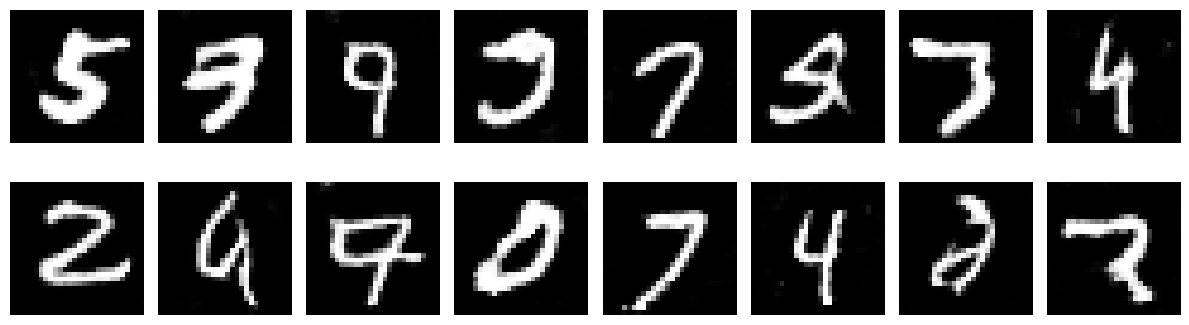

Epoch 49/100
Step 0/938 [D loss: 0.6659, acc.: 72.66%] [G loss: 0.9852]
Step 100/938 [D loss: 0.6295, acc.: 68.75%] [G loss: 0.9844]
Step 200/938 [D loss: 0.6638, acc.: 71.09%] [G loss: 1.0775]
Step 300/938 [D loss: 0.6521, acc.: 70.31%] [G loss: 1.0455]
Step 400/938 [D loss: 0.6617, acc.: 63.28%] [G loss: 0.9917]
Step 500/938 [D loss: 0.6533, acc.: 71.09%] [G loss: 1.0596]
Step 600/938 [D loss: 0.6596, acc.: 71.09%] [G loss: 0.9498]
Step 700/938 [D loss: 0.6788, acc.: 68.75%] [G loss: 1.0591]
Step 800/938 [D loss: 0.6610, acc.: 70.31%] [G loss: 1.0133]
Step 900/938 [D loss: 0.6512, acc.: 70.31%] [G loss: 0.9941]
1/1 [==============================] - 0s 27ms/step


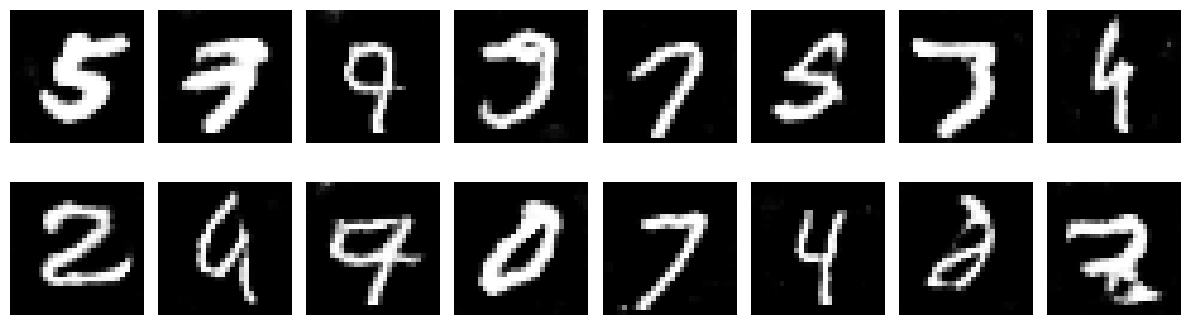

Epoch 50/100
Step 0/938 [D loss: 0.6853, acc.: 71.09%] [G loss: 1.0103]
Step 100/938 [D loss: 0.6451, acc.: 69.53%] [G loss: 0.9368]
Step 200/938 [D loss: 0.6432, acc.: 75.78%] [G loss: 1.0398]
Step 300/938 [D loss: 0.6445, acc.: 67.97%] [G loss: 1.0012]
Step 400/938 [D loss: 0.6512, acc.: 67.97%] [G loss: 1.0873]
Step 500/938 [D loss: 0.6739, acc.: 69.53%] [G loss: 1.0087]
Step 600/938 [D loss: 0.6346, acc.: 70.31%] [G loss: 1.0306]
Step 700/938 [D loss: 0.6775, acc.: 68.75%] [G loss: 0.9659]
Step 800/938 [D loss: 0.6449, acc.: 69.53%] [G loss: 1.0331]
Step 900/938 [D loss: 0.6406, acc.: 72.66%] [G loss: 1.0159]
1/1 [==============================] - 0s 23ms/step


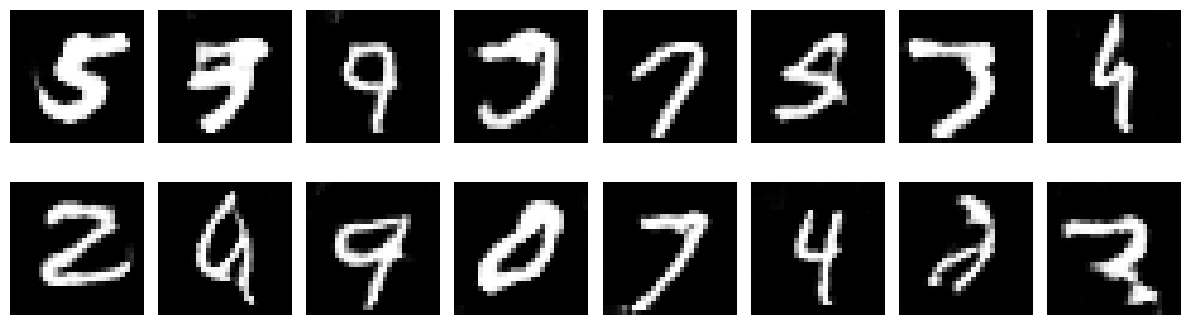

Epoch 51/100
Step 0/938 [D loss: 0.6634, acc.: 74.22%] [G loss: 1.0968]
Step 100/938 [D loss: 0.6331, acc.: 69.53%] [G loss: 1.0963]
Step 200/938 [D loss: 0.6481, acc.: 69.53%] [G loss: 0.9876]
Step 300/938 [D loss: 0.6754, acc.: 72.66%] [G loss: 0.9972]
Step 400/938 [D loss: 0.6880, acc.: 71.09%] [G loss: 0.9552]
Step 500/938 [D loss: 0.6646, acc.: 65.62%] [G loss: 1.0767]
Step 600/938 [D loss: 0.6766, acc.: 66.41%] [G loss: 1.0054]
Step 700/938 [D loss: 0.6429, acc.: 70.31%] [G loss: 1.0090]
Step 800/938 [D loss: 0.6165, acc.: 69.53%] [G loss: 1.0536]
Step 900/938 [D loss: 0.6567, acc.: 72.66%] [G loss: 1.0084]
1/1 [==============================] - 0s 25ms/step


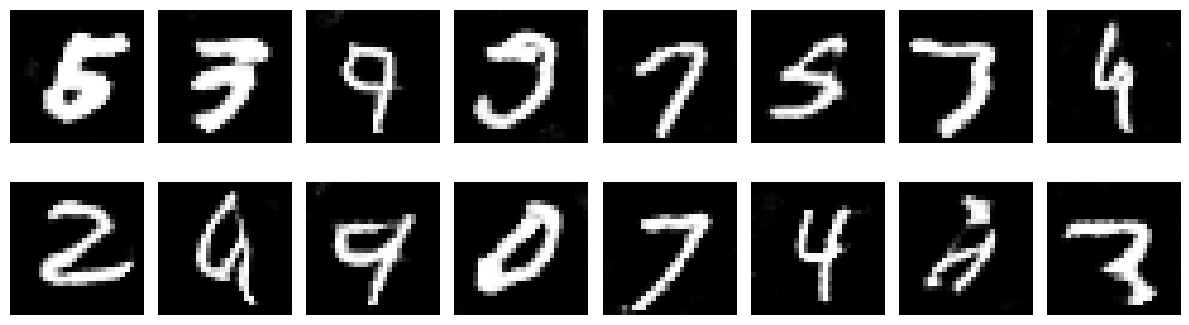

Epoch 52/100
Step 0/938 [D loss: 0.6268, acc.: 72.66%] [G loss: 1.0959]
Step 100/938 [D loss: 0.6631, acc.: 71.09%] [G loss: 0.9869]
Step 200/938 [D loss: 0.6105, acc.: 78.12%] [G loss: 1.1010]
Step 300/938 [D loss: 0.6387, acc.: 71.09%] [G loss: 1.0553]
Step 400/938 [D loss: 0.6363, acc.: 72.66%] [G loss: 1.0581]
Step 500/938 [D loss: 0.6611, acc.: 73.44%] [G loss: 0.9805]
Step 600/938 [D loss: 0.6826, acc.: 68.75%] [G loss: 1.0352]
Step 700/938 [D loss: 0.6570, acc.: 70.31%] [G loss: 1.0450]
Step 800/938 [D loss: 0.6581, acc.: 71.09%] [G loss: 1.0356]
Step 900/938 [D loss: 0.6727, acc.: 68.75%] [G loss: 1.0014]
1/1 [==============================] - 0s 25ms/step


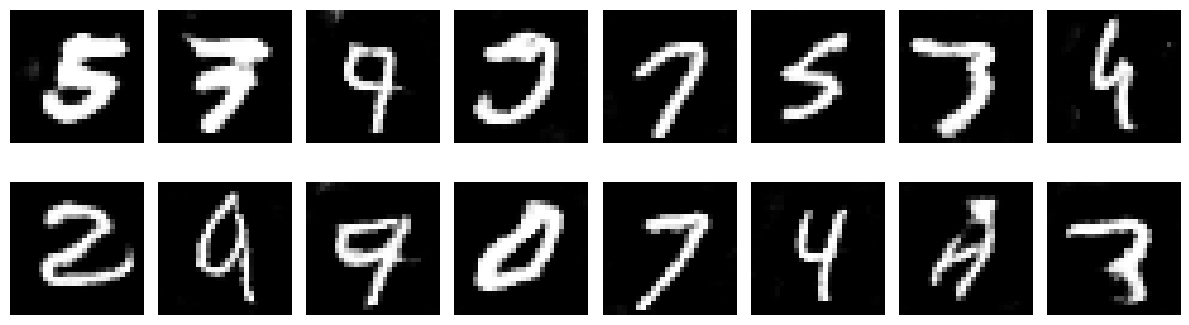

Epoch 53/100
Step 0/938 [D loss: 0.6878, acc.: 71.09%] [G loss: 1.0097]
Step 100/938 [D loss: 0.6425, acc.: 69.53%] [G loss: 1.0841]
Step 200/938 [D loss: 0.6421, acc.: 76.56%] [G loss: 1.0569]
Step 300/938 [D loss: 0.6721, acc.: 68.75%] [G loss: 1.0184]
Step 400/938 [D loss: 0.6391, acc.: 72.66%] [G loss: 1.0511]
Step 500/938 [D loss: 0.6445, acc.: 67.19%] [G loss: 0.9710]
Step 600/938 [D loss: 0.6840, acc.: 70.31%] [G loss: 0.9906]
Step 700/938 [D loss: 0.6905, acc.: 59.38%] [G loss: 0.9934]
Step 800/938 [D loss: 0.6616, acc.: 74.22%] [G loss: 1.0546]
Step 900/938 [D loss: 0.6809, acc.: 65.62%] [G loss: 0.9940]
1/1 [==============================] - 0s 26ms/step


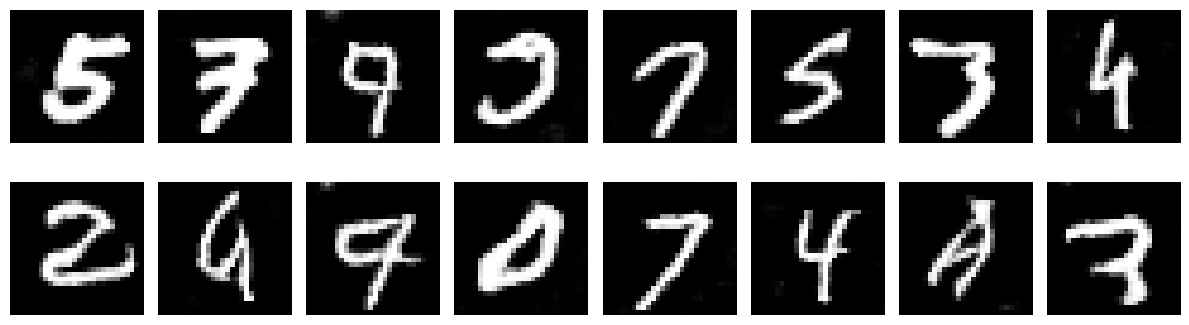

Epoch 54/100
Step 0/938 [D loss: 0.6657, acc.: 71.88%] [G loss: 1.0718]
Step 100/938 [D loss: 0.6778, acc.: 68.75%] [G loss: 0.9989]
Step 200/938 [D loss: 0.6533, acc.: 67.19%] [G loss: 0.9927]
Step 300/938 [D loss: 0.6779, acc.: 69.53%] [G loss: 0.9952]
Step 400/938 [D loss: 0.6414, acc.: 73.44%] [G loss: 1.0411]
Step 500/938 [D loss: 0.6630, acc.: 75.00%] [G loss: 1.0083]
Step 600/938 [D loss: 0.6370, acc.: 71.88%] [G loss: 0.9732]
Step 700/938 [D loss: 0.6660, acc.: 71.09%] [G loss: 0.9843]
Step 800/938 [D loss: 0.6288, acc.: 69.53%] [G loss: 1.0185]
Step 900/938 [D loss: 0.6531, acc.: 70.31%] [G loss: 1.0285]
1/1 [==============================] - 0s 33ms/step


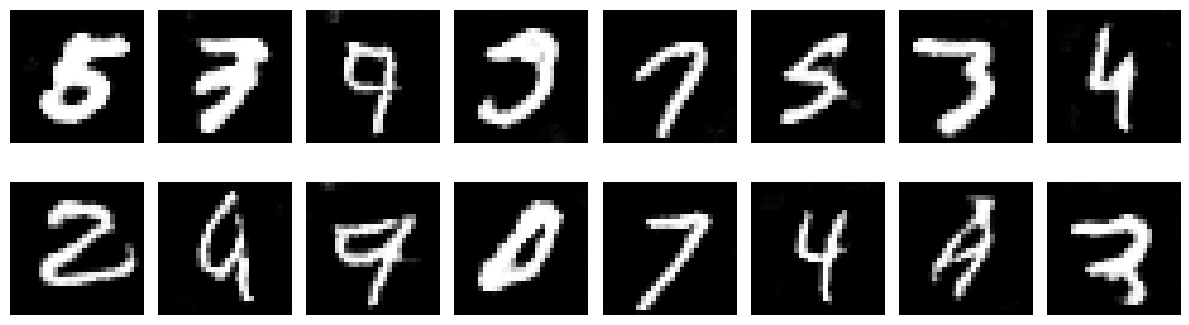

Epoch 55/100
Step 0/938 [D loss: 0.6447, acc.: 68.75%] [G loss: 1.0825]
Step 100/938 [D loss: 0.6448, acc.: 78.12%] [G loss: 1.0447]
Step 200/938 [D loss: 0.6578, acc.: 74.22%] [G loss: 1.0448]
Step 300/938 [D loss: 0.6545, acc.: 71.88%] [G loss: 1.0832]
Step 400/938 [D loss: 0.6357, acc.: 74.22%] [G loss: 0.9603]
Step 500/938 [D loss: 0.6165, acc.: 81.25%] [G loss: 1.0180]
Step 600/938 [D loss: 0.6730, acc.: 68.75%] [G loss: 1.0142]
Step 700/938 [D loss: 0.6317, acc.: 70.31%] [G loss: 0.9740]
Step 800/938 [D loss: 0.6324, acc.: 69.53%] [G loss: 1.0494]
Step 900/938 [D loss: 0.6778, acc.: 68.75%] [G loss: 0.9273]
1/1 [==============================] - 0s 31ms/step


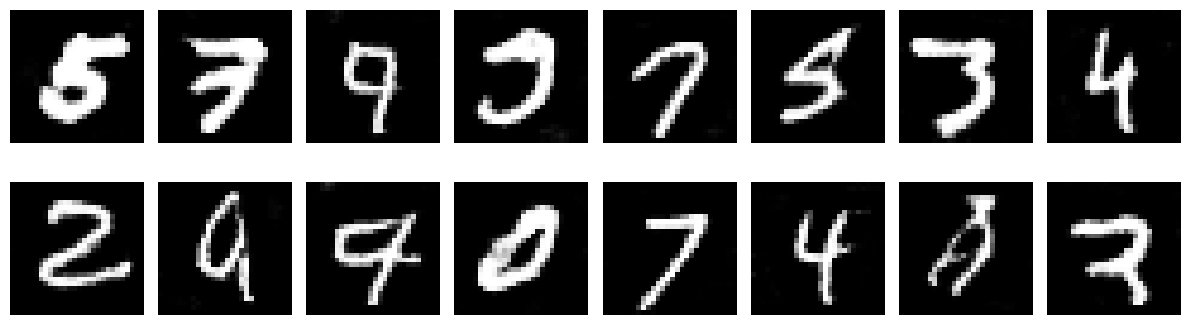

Epoch 56/100
Step 0/938 [D loss: 0.6795, acc.: 72.66%] [G loss: 1.0286]
Step 100/938 [D loss: 0.6696, acc.: 71.88%] [G loss: 0.9764]
Step 200/938 [D loss: 0.6218, acc.: 73.44%] [G loss: 1.0905]
Step 300/938 [D loss: 0.6426, acc.: 71.09%] [G loss: 0.9891]
Step 400/938 [D loss: 0.6600, acc.: 67.97%] [G loss: 1.0029]
Step 500/938 [D loss: 0.6292, acc.: 70.31%] [G loss: 1.0357]
Step 600/938 [D loss: 0.6898, acc.: 65.62%] [G loss: 0.9553]
Step 700/938 [D loss: 0.6129, acc.: 73.44%] [G loss: 1.0990]
Step 800/938 [D loss: 0.6664, acc.: 64.06%] [G loss: 1.0296]
Step 900/938 [D loss: 0.6316, acc.: 72.66%] [G loss: 1.0190]
1/1 [==============================] - 0s 24ms/step


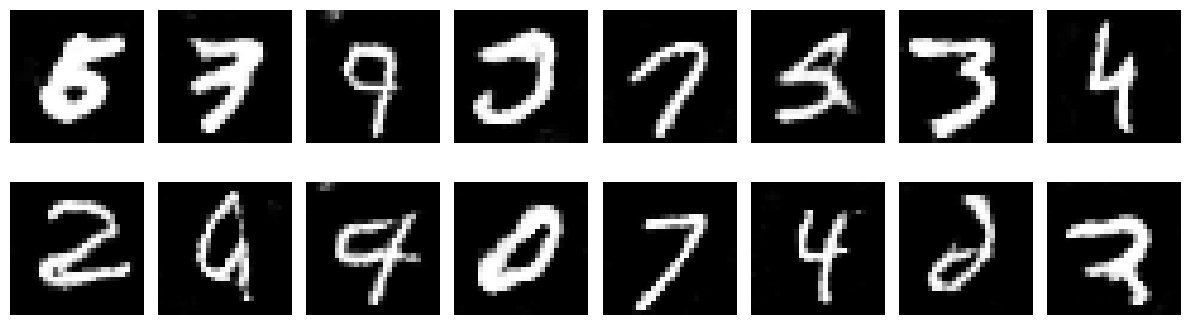

Epoch 57/100
Step 0/938 [D loss: 0.6369, acc.: 64.84%] [G loss: 0.9585]
Step 100/938 [D loss: 0.6696, acc.: 70.31%] [G loss: 0.9549]
Step 200/938 [D loss: 0.6626, acc.: 71.88%] [G loss: 1.0248]
Step 300/938 [D loss: 0.6416, acc.: 71.88%] [G loss: 1.1471]
Step 400/938 [D loss: 0.6431, acc.: 73.44%] [G loss: 1.0321]
Step 500/938 [D loss: 0.6535, acc.: 67.19%] [G loss: 1.0303]
Step 600/938 [D loss: 0.6461, acc.: 68.75%] [G loss: 0.9943]
Step 700/938 [D loss: 0.6463, acc.: 69.53%] [G loss: 1.0510]
Step 800/938 [D loss: 0.6483, acc.: 73.44%] [G loss: 1.0095]
Step 900/938 [D loss: 0.6190, acc.: 70.31%] [G loss: 1.0538]
1/1 [==============================] - 0s 27ms/step


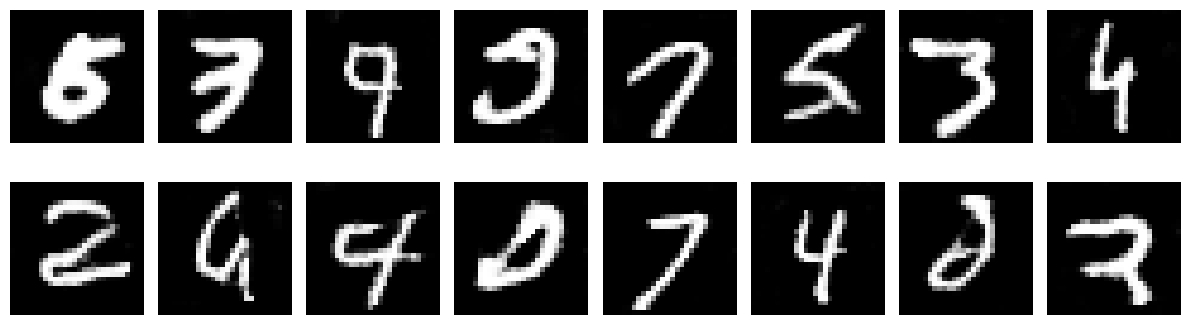

Epoch 58/100
Step 0/938 [D loss: 0.6520, acc.: 66.41%] [G loss: 0.9701]
Step 100/938 [D loss: 0.6957, acc.: 68.75%] [G loss: 1.0331]
Step 200/938 [D loss: 0.6484, acc.: 68.75%] [G loss: 1.0115]
Step 300/938 [D loss: 0.6622, acc.: 67.97%] [G loss: 0.9922]
Step 400/938 [D loss: 0.6189, acc.: 76.56%] [G loss: 1.0337]
Step 500/938 [D loss: 0.6665, acc.: 74.22%] [G loss: 1.0494]
Step 600/938 [D loss: 0.6480, acc.: 71.88%] [G loss: 1.0339]
Step 700/938 [D loss: 0.6269, acc.: 72.66%] [G loss: 1.0948]
Step 800/938 [D loss: 0.6923, acc.: 66.41%] [G loss: 1.1429]
Step 900/938 [D loss: 0.6488, acc.: 65.62%] [G loss: 1.0115]
1/1 [==============================] - 0s 25ms/step


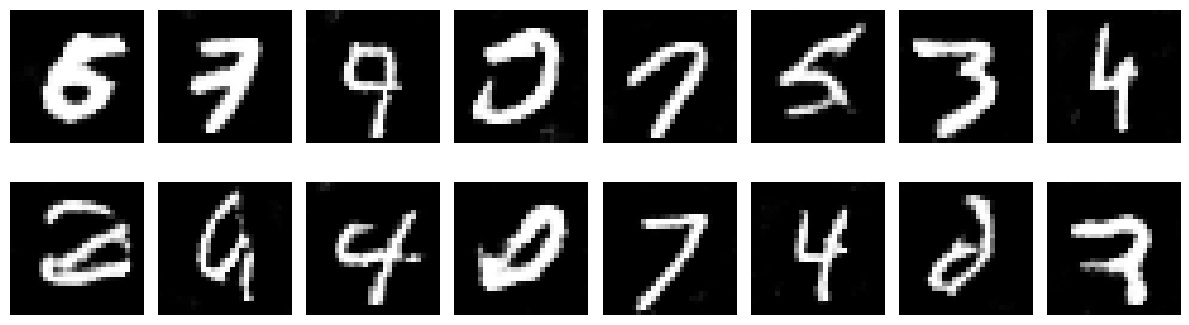

Epoch 59/100
Step 0/938 [D loss: 0.6617, acc.: 71.88%] [G loss: 1.0531]
Step 100/938 [D loss: 0.6497, acc.: 73.44%] [G loss: 1.0194]
Step 200/938 [D loss: 0.6981, acc.: 63.28%] [G loss: 0.9729]
Step 300/938 [D loss: 0.6264, acc.: 67.97%] [G loss: 1.0687]
Step 400/938 [D loss: 0.6295, acc.: 75.78%] [G loss: 1.0827]
Step 500/938 [D loss: 0.6169, acc.: 75.78%] [G loss: 1.0068]
Step 600/938 [D loss: 0.6572, acc.: 63.28%] [G loss: 1.0288]
Step 700/938 [D loss: 0.6672, acc.: 67.97%] [G loss: 1.0302]
Step 800/938 [D loss: 0.6250, acc.: 73.44%] [G loss: 1.0419]
Step 900/938 [D loss: 0.6595, acc.: 74.22%] [G loss: 0.9824]
1/1 [==============================] - 0s 24ms/step


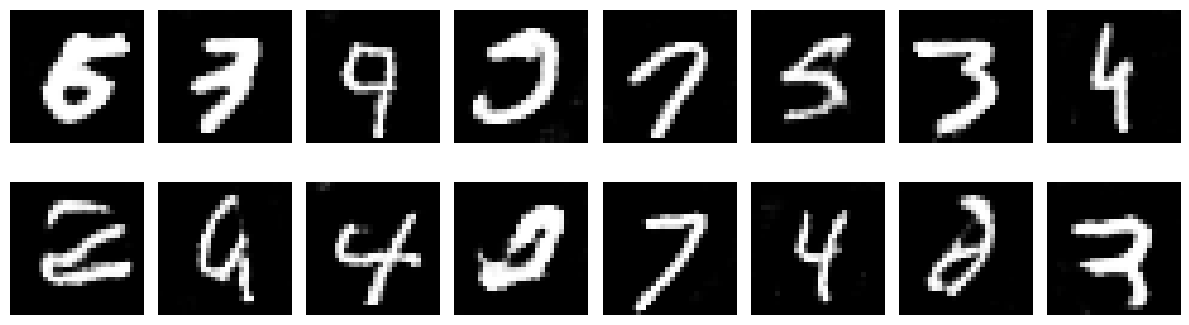

Epoch 60/100
Step 0/938 [D loss: 0.6678, acc.: 71.88%] [G loss: 0.9964]
Step 100/938 [D loss: 0.6440, acc.: 70.31%] [G loss: 1.0115]
Step 200/938 [D loss: 0.6856, acc.: 68.75%] [G loss: 0.9788]
Step 300/938 [D loss: 0.6337, acc.: 70.31%] [G loss: 1.0079]
Step 400/938 [D loss: 0.6519, acc.: 75.00%] [G loss: 1.0411]
Step 500/938 [D loss: 0.6988, acc.: 66.41%] [G loss: 1.0222]
Step 600/938 [D loss: 0.6543, acc.: 71.09%] [G loss: 1.0267]
Step 700/938 [D loss: 0.6408, acc.: 67.19%] [G loss: 0.9330]
Step 800/938 [D loss: 0.6844, acc.: 71.09%] [G loss: 0.9606]
Step 900/938 [D loss: 0.6148, acc.: 71.88%] [G loss: 0.9775]
1/1 [==============================] - 0s 24ms/step


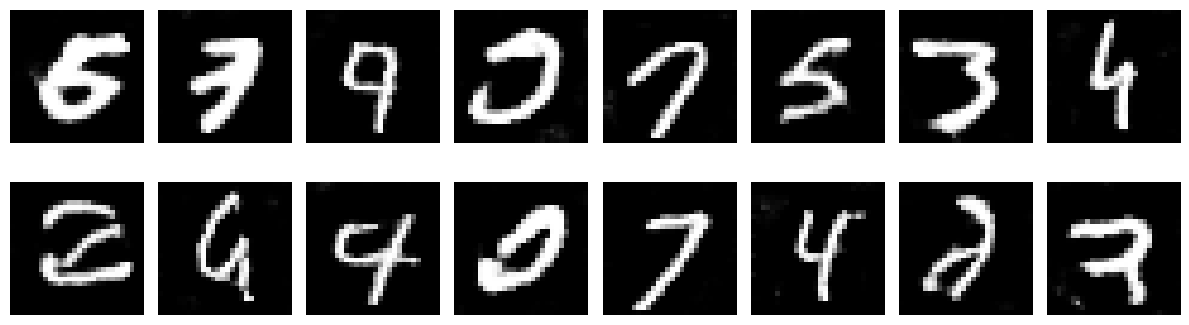

Epoch 61/100
Step 0/938 [D loss: 0.6579, acc.: 71.88%] [G loss: 1.0750]
Step 100/938 [D loss: 0.6507, acc.: 72.66%] [G loss: 1.0847]
Step 200/938 [D loss: 0.6750, acc.: 70.31%] [G loss: 0.9746]
Step 300/938 [D loss: 0.6864, acc.: 69.53%] [G loss: 1.0554]
Step 400/938 [D loss: 0.6156, acc.: 77.34%] [G loss: 1.0463]
Step 500/938 [D loss: 0.6625, acc.: 64.06%] [G loss: 1.0030]
Step 600/938 [D loss: 0.6692, acc.: 68.75%] [G loss: 0.9522]
Step 700/938 [D loss: 0.6524, acc.: 69.53%] [G loss: 0.9963]
Step 800/938 [D loss: 0.6468, acc.: 64.84%] [G loss: 1.1416]
Step 900/938 [D loss: 0.6339, acc.: 69.53%] [G loss: 1.0451]
1/1 [==============================] - 0s 31ms/step


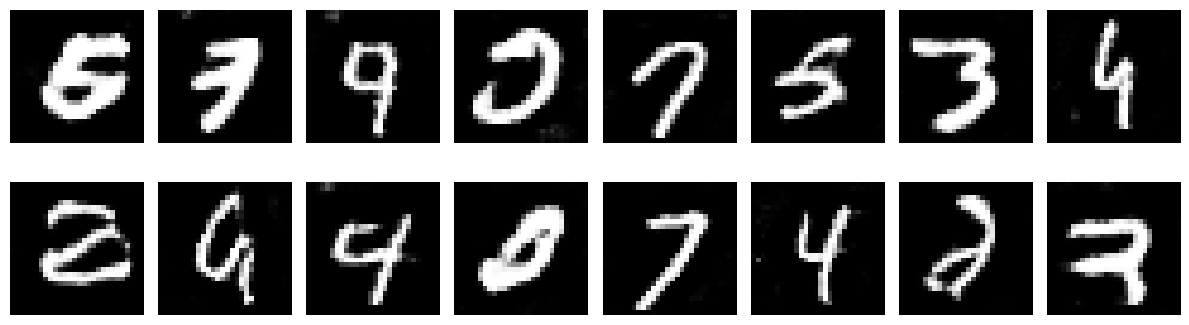

Epoch 62/100
Step 0/938 [D loss: 0.6630, acc.: 73.44%] [G loss: 1.0496]
Step 100/938 [D loss: 0.6774, acc.: 65.62%] [G loss: 0.9588]
Step 200/938 [D loss: 0.5915, acc.: 71.09%] [G loss: 1.0539]
Step 300/938 [D loss: 0.6262, acc.: 71.09%] [G loss: 1.0892]
Step 400/938 [D loss: 0.6164, acc.: 70.31%] [G loss: 0.9930]
Step 500/938 [D loss: 0.6788, acc.: 71.88%] [G loss: 1.0255]
Step 600/938 [D loss: 0.6848, acc.: 71.09%] [G loss: 1.0297]
Step 700/938 [D loss: 0.6583, acc.: 70.31%] [G loss: 1.0365]
Step 800/938 [D loss: 0.6560, acc.: 72.66%] [G loss: 1.0197]
Step 900/938 [D loss: 0.6404, acc.: 74.22%] [G loss: 0.9823]
1/1 [==============================] - 0s 36ms/step


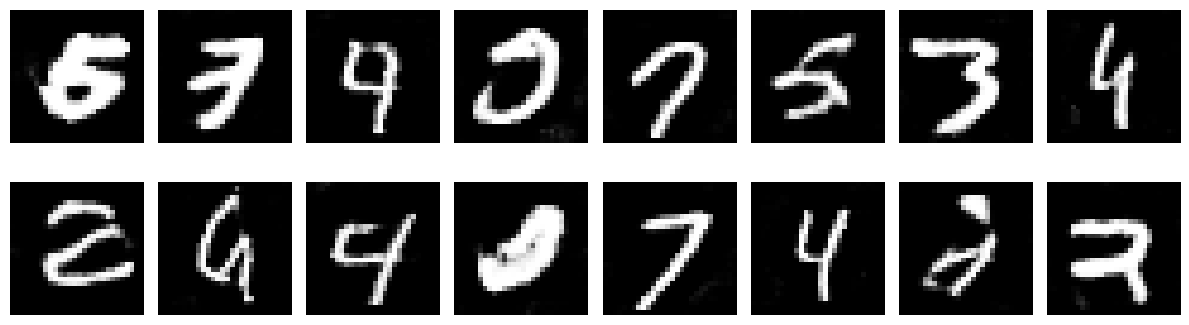

Epoch 63/100
Step 0/938 [D loss: 0.6203, acc.: 78.12%] [G loss: 0.9687]
Step 100/938 [D loss: 0.6350, acc.: 72.66%] [G loss: 1.0268]
Step 200/938 [D loss: 0.6033, acc.: 69.53%] [G loss: 1.1420]
Step 300/938 [D loss: 0.6622, acc.: 67.97%] [G loss: 1.0217]
Step 400/938 [D loss: 0.6482, acc.: 70.31%] [G loss: 1.0128]
Step 500/938 [D loss: 0.6734, acc.: 71.09%] [G loss: 1.0519]
Step 600/938 [D loss: 0.6814, acc.: 68.75%] [G loss: 0.9593]
Step 700/938 [D loss: 0.6081, acc.: 74.22%] [G loss: 0.9533]
Step 800/938 [D loss: 0.6318, acc.: 67.97%] [G loss: 1.0445]
Step 900/938 [D loss: 0.6176, acc.: 70.31%] [G loss: 1.1230]
1/1 [==============================] - 0s 23ms/step


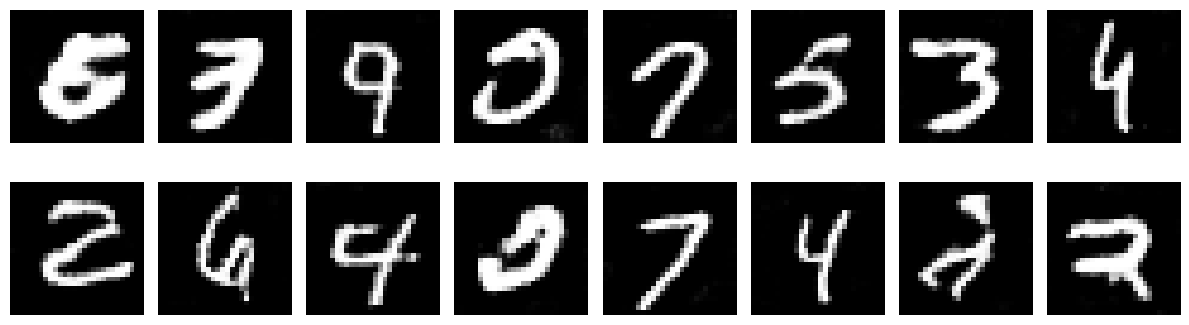

Epoch 64/100
Step 0/938 [D loss: 0.6627, acc.: 69.53%] [G loss: 1.0267]
Step 100/938 [D loss: 0.6798, acc.: 73.44%] [G loss: 0.9988]
Step 200/938 [D loss: 0.6272, acc.: 71.09%] [G loss: 0.9918]
Step 300/938 [D loss: 0.6494, acc.: 77.34%] [G loss: 1.0394]
Step 400/938 [D loss: 0.6279, acc.: 75.00%] [G loss: 1.0145]
Step 500/938 [D loss: 0.6352, acc.: 73.44%] [G loss: 1.0505]
Step 600/938 [D loss: 0.6525, acc.: 71.09%] [G loss: 0.9885]
Step 700/938 [D loss: 0.7104, acc.: 64.84%] [G loss: 1.0046]
Step 800/938 [D loss: 0.6350, acc.: 74.22%] [G loss: 1.0108]
Step 900/938 [D loss: 0.6304, acc.: 69.53%] [G loss: 1.0748]
1/1 [==============================] - 0s 38ms/step


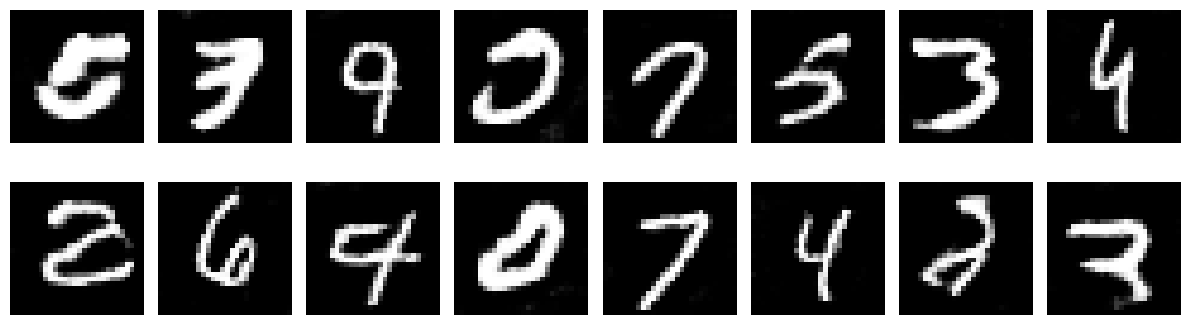

Epoch 65/100
Step 0/938 [D loss: 0.6394, acc.: 68.75%] [G loss: 1.0044]
Step 100/938 [D loss: 0.6674, acc.: 69.53%] [G loss: 1.0591]
Step 200/938 [D loss: 0.6588, acc.: 71.88%] [G loss: 0.9686]
Step 300/938 [D loss: 0.6429, acc.: 67.19%] [G loss: 0.9820]
Step 400/938 [D loss: 0.6492, acc.: 74.22%] [G loss: 1.0021]
Step 500/938 [D loss: 0.6154, acc.: 74.22%] [G loss: 1.0863]
Step 600/938 [D loss: 0.6476, acc.: 68.75%] [G loss: 1.0167]
Step 700/938 [D loss: 0.6354, acc.: 74.22%] [G loss: 0.9821]
Step 800/938 [D loss: 0.6687, acc.: 70.31%] [G loss: 0.9289]
Step 900/938 [D loss: 0.6352, acc.: 73.44%] [G loss: 0.9942]
1/1 [==============================] - 0s 26ms/step


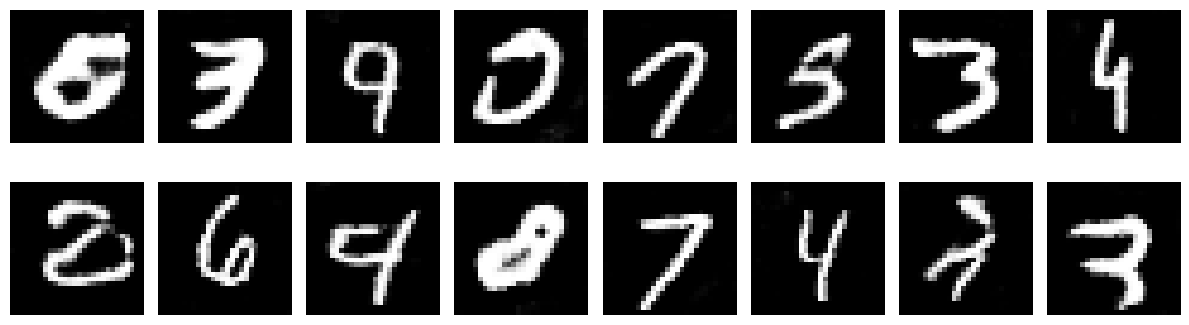

Epoch 66/100
Step 0/938 [D loss: 0.6523, acc.: 74.22%] [G loss: 1.0437]
Step 100/938 [D loss: 0.6581, acc.: 71.88%] [G loss: 1.0407]
Step 200/938 [D loss: 0.6478, acc.: 71.88%] [G loss: 1.0669]
Step 300/938 [D loss: 0.6551, acc.: 68.75%] [G loss: 1.0343]
Step 400/938 [D loss: 0.6805, acc.: 73.44%] [G loss: 1.1016]
Step 500/938 [D loss: 0.6276, acc.: 72.66%] [G loss: 0.9184]
Step 600/938 [D loss: 0.6533, acc.: 70.31%] [G loss: 1.1104]
Step 700/938 [D loss: 0.6577, acc.: 67.19%] [G loss: 0.9927]
Step 800/938 [D loss: 0.6397, acc.: 74.22%] [G loss: 1.1026]
Step 900/938 [D loss: 0.6478, acc.: 65.62%] [G loss: 1.0635]
1/1 [==============================] - 0s 37ms/step


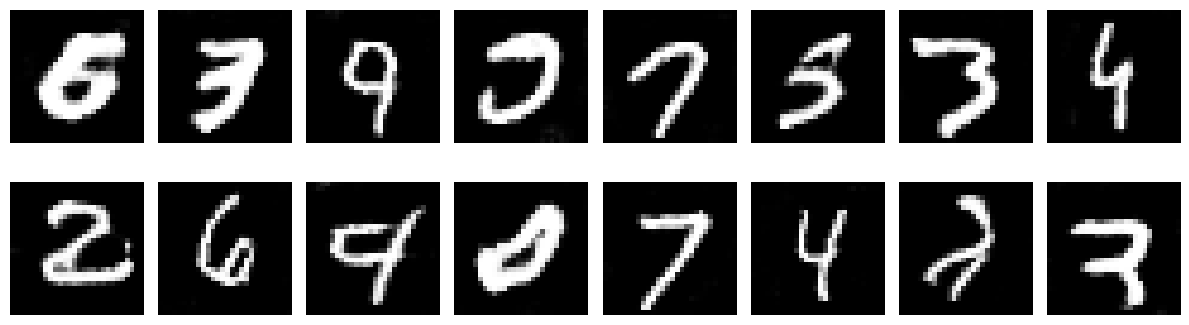

Epoch 67/100
Step 0/938 [D loss: 0.6695, acc.: 74.22%] [G loss: 1.0321]
Step 100/938 [D loss: 0.6272, acc.: 72.66%] [G loss: 1.0598]
Step 200/938 [D loss: 0.6543, acc.: 71.09%] [G loss: 1.0454]
Step 300/938 [D loss: 0.6157, acc.: 75.78%] [G loss: 1.0510]
Step 400/938 [D loss: 0.6784, acc.: 64.84%] [G loss: 0.9701]
Step 500/938 [D loss: 0.6154, acc.: 74.22%] [G loss: 0.9836]
Step 600/938 [D loss: 0.5987, acc.: 75.78%] [G loss: 0.9848]
Step 700/938 [D loss: 0.6618, acc.: 72.66%] [G loss: 0.9997]
Step 800/938 [D loss: 0.6120, acc.: 75.00%] [G loss: 0.9466]
Step 900/938 [D loss: 0.6606, acc.: 70.31%] [G loss: 0.9826]
1/1 [==============================] - 0s 25ms/step


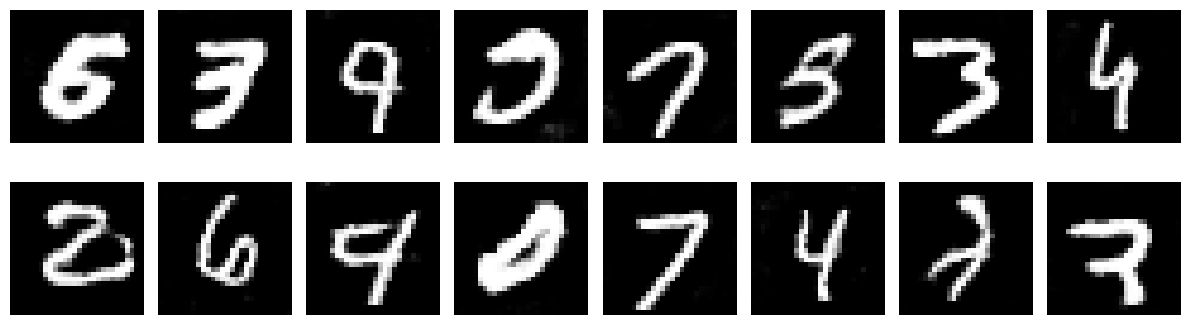

Epoch 68/100
Step 0/938 [D loss: 0.6414, acc.: 71.88%] [G loss: 0.9900]
Step 100/938 [D loss: 0.6499, acc.: 64.84%] [G loss: 1.0029]
Step 200/938 [D loss: 0.6379, acc.: 72.66%] [G loss: 1.0245]
Step 300/938 [D loss: 0.6995, acc.: 67.97%] [G loss: 1.0216]
Step 400/938 [D loss: 0.6308, acc.: 70.31%] [G loss: 1.0320]
Step 500/938 [D loss: 0.6309, acc.: 71.88%] [G loss: 0.9929]
Step 600/938 [D loss: 0.6550, acc.: 72.66%] [G loss: 1.0379]
Step 700/938 [D loss: 0.6349, acc.: 75.78%] [G loss: 1.0655]
Step 800/938 [D loss: 0.6624, acc.: 68.75%] [G loss: 1.0045]
Step 900/938 [D loss: 0.6894, acc.: 67.19%] [G loss: 1.0671]
1/1 [==============================] - 0s 27ms/step


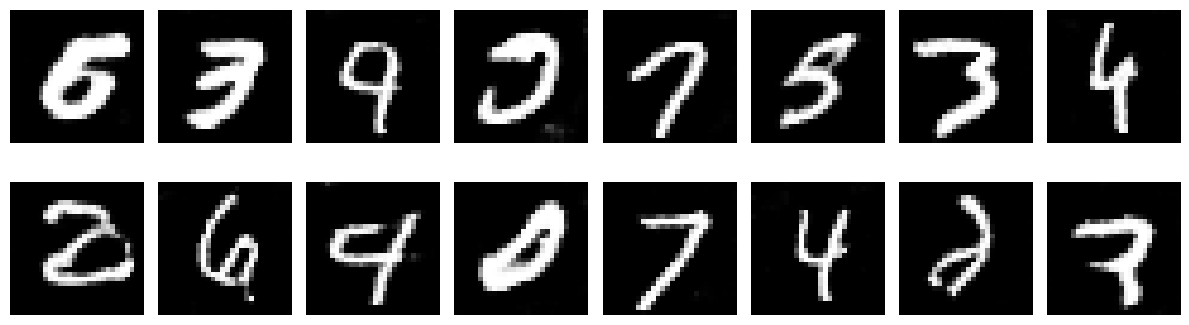

Epoch 69/100
Step 0/938 [D loss: 0.6355, acc.: 68.75%] [G loss: 1.0009]
Step 100/938 [D loss: 0.6782, acc.: 69.53%] [G loss: 0.9942]
Step 200/938 [D loss: 0.6510, acc.: 73.44%] [G loss: 0.9770]
Step 300/938 [D loss: 0.6372, acc.: 78.12%] [G loss: 1.0458]
Step 400/938 [D loss: 0.6582, acc.: 69.53%] [G loss: 1.0360]
Step 500/938 [D loss: 0.6620, acc.: 71.88%] [G loss: 1.0122]
Step 600/938 [D loss: 0.6874, acc.: 67.19%] [G loss: 1.0255]
Step 700/938 [D loss: 0.6623, acc.: 71.09%] [G loss: 1.0039]
Step 800/938 [D loss: 0.6243, acc.: 76.56%] [G loss: 0.9980]
Step 900/938 [D loss: 0.6566, acc.: 67.19%] [G loss: 1.0523]
1/1 [==============================] - 0s 26ms/step


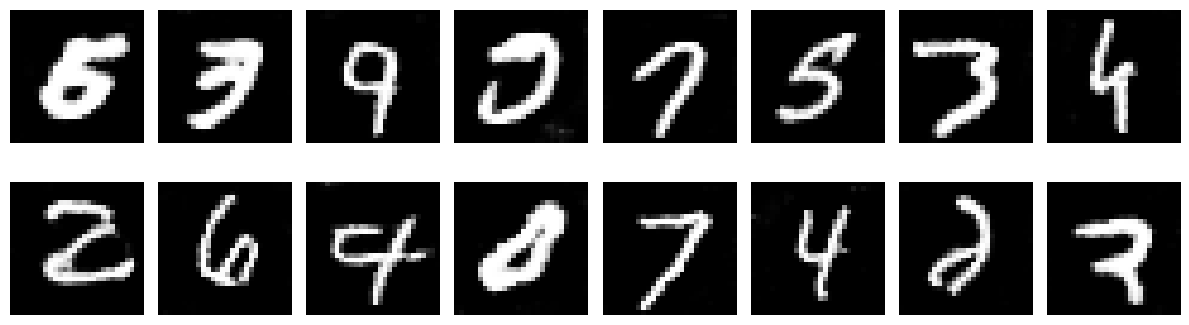

Epoch 70/100
Step 0/938 [D loss: 0.6533, acc.: 75.00%] [G loss: 0.9560]
Step 100/938 [D loss: 0.6322, acc.: 72.66%] [G loss: 0.9901]
Step 200/938 [D loss: 0.6275, acc.: 71.09%] [G loss: 1.0556]
Step 300/938 [D loss: 0.6183, acc.: 72.66%] [G loss: 1.0025]
Step 400/938 [D loss: 0.6597, acc.: 66.41%] [G loss: 1.0129]
Step 500/938 [D loss: 0.6432, acc.: 71.09%] [G loss: 1.1270]
Step 600/938 [D loss: 0.6465, acc.: 78.12%] [G loss: 1.0282]
Step 700/938 [D loss: 0.6842, acc.: 64.84%] [G loss: 0.9974]
Step 800/938 [D loss: 0.6229, acc.: 70.31%] [G loss: 1.0057]
Step 900/938 [D loss: 0.6407, acc.: 69.53%] [G loss: 0.9647]
1/1 [==============================] - 0s 25ms/step


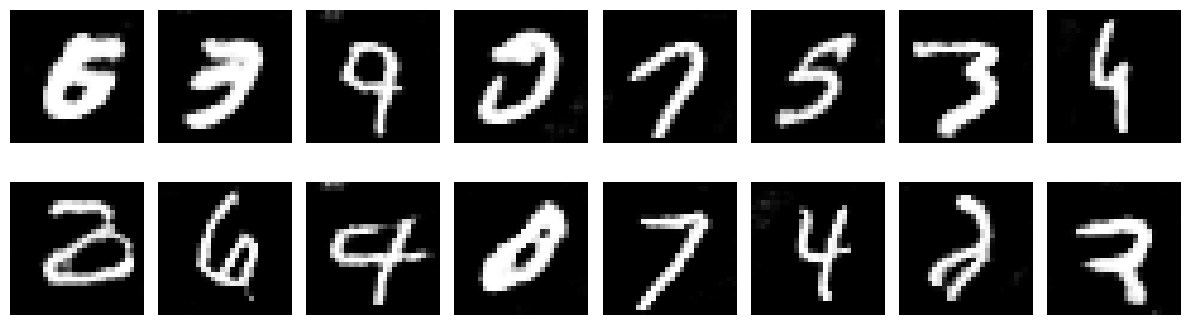

Epoch 71/100
Step 0/938 [D loss: 0.6481, acc.: 70.31%] [G loss: 0.9928]
Step 100/938 [D loss: 0.6549, acc.: 71.09%] [G loss: 0.9966]
Step 200/938 [D loss: 0.6595, acc.: 75.00%] [G loss: 1.1001]
Step 300/938 [D loss: 0.6432, acc.: 69.53%] [G loss: 1.0340]
Step 400/938 [D loss: 0.6334, acc.: 65.62%] [G loss: 1.0698]
Step 500/938 [D loss: 0.6340, acc.: 73.44%] [G loss: 1.0462]
Step 600/938 [D loss: 0.6655, acc.: 73.44%] [G loss: 0.9911]
Step 700/938 [D loss: 0.6472, acc.: 66.41%] [G loss: 1.1299]
Step 800/938 [D loss: 0.6555, acc.: 73.44%] [G loss: 0.9359]
Step 900/938 [D loss: 0.6427, acc.: 67.97%] [G loss: 1.0072]
1/1 [==============================] - 0s 25ms/step


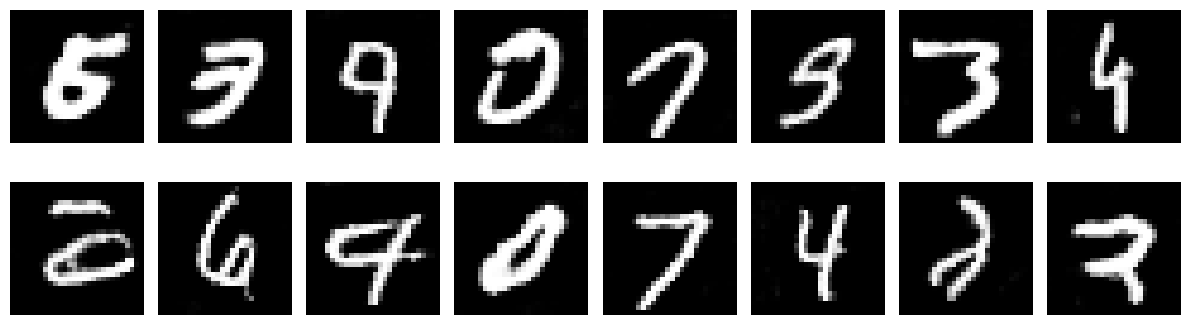

Epoch 72/100
Step 0/938 [D loss: 0.6500, acc.: 69.53%] [G loss: 1.0482]
Step 100/938 [D loss: 0.6661, acc.: 75.78%] [G loss: 0.9973]
Step 200/938 [D loss: 0.6692, acc.: 67.19%] [G loss: 1.0411]
Step 300/938 [D loss: 0.6569, acc.: 65.62%] [G loss: 0.9815]
Step 400/938 [D loss: 0.6520, acc.: 69.53%] [G loss: 0.9802]
Step 500/938 [D loss: 0.6632, acc.: 67.19%] [G loss: 1.0960]
Step 600/938 [D loss: 0.6492, acc.: 70.31%] [G loss: 0.9854]
Step 700/938 [D loss: 0.6639, acc.: 70.31%] [G loss: 1.0415]
Step 800/938 [D loss: 0.6183, acc.: 71.88%] [G loss: 1.0411]
Step 900/938 [D loss: 0.6607, acc.: 72.66%] [G loss: 0.9796]
1/1 [==============================] - 0s 27ms/step


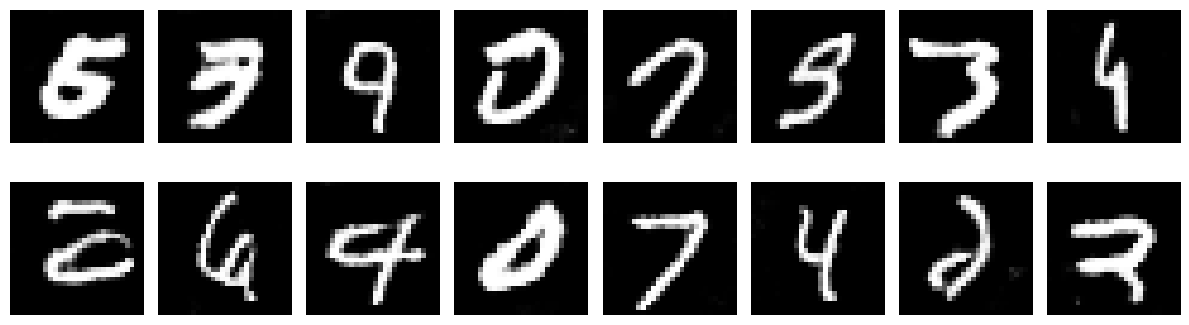

Epoch 73/100
Step 0/938 [D loss: 0.6779, acc.: 66.41%] [G loss: 0.9807]
Step 100/938 [D loss: 0.6630, acc.: 65.62%] [G loss: 1.0980]
Step 200/938 [D loss: 0.6529, acc.: 69.53%] [G loss: 0.9996]
Step 300/938 [D loss: 0.6784, acc.: 64.84%] [G loss: 1.0364]
Step 400/938 [D loss: 0.6665, acc.: 66.41%] [G loss: 1.0229]
Step 500/938 [D loss: 0.6885, acc.: 71.09%] [G loss: 1.0267]
Step 600/938 [D loss: 0.6586, acc.: 67.97%] [G loss: 1.0335]
Step 700/938 [D loss: 0.6531, acc.: 76.56%] [G loss: 1.0376]
Step 800/938 [D loss: 0.6359, acc.: 67.97%] [G loss: 1.0197]
Step 900/938 [D loss: 0.7247, acc.: 67.97%] [G loss: 1.0330]
1/1 [==============================] - 0s 26ms/step


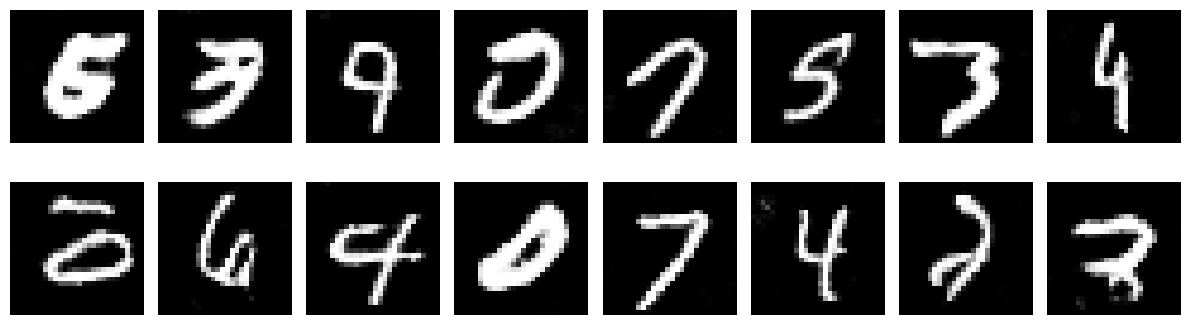

Epoch 74/100
Step 0/938 [D loss: 0.6738, acc.: 67.97%] [G loss: 0.9888]
Step 100/938 [D loss: 0.6237, acc.: 75.00%] [G loss: 1.0405]
Step 200/938 [D loss: 0.6403, acc.: 65.62%] [G loss: 1.0562]
Step 300/938 [D loss: 0.6644, acc.: 72.66%] [G loss: 1.0366]
Step 400/938 [D loss: 0.6320, acc.: 76.56%] [G loss: 0.9678]
Step 500/938 [D loss: 0.6613, acc.: 68.75%] [G loss: 0.9472]
Step 600/938 [D loss: 0.6587, acc.: 70.31%] [G loss: 1.0084]
Step 700/938 [D loss: 0.6643, acc.: 70.31%] [G loss: 0.9957]
Step 800/938 [D loss: 0.6517, acc.: 68.75%] [G loss: 1.0607]
Step 900/938 [D loss: 0.6315, acc.: 76.56%] [G loss: 1.0549]
1/1 [==============================] - 0s 36ms/step


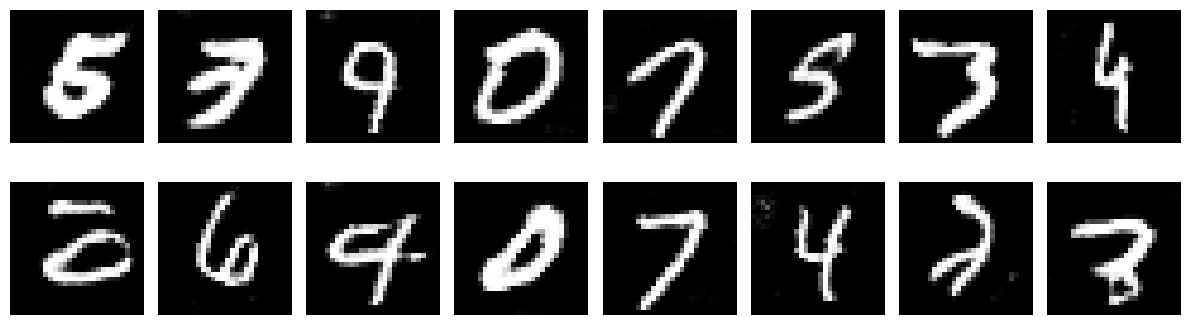

Epoch 75/100
Step 0/938 [D loss: 0.6372, acc.: 71.09%] [G loss: 1.0716]
Step 100/938 [D loss: 0.6661, acc.: 65.62%] [G loss: 1.0424]
Step 200/938 [D loss: 0.6684, acc.: 65.62%] [G loss: 1.0264]
Step 300/938 [D loss: 0.6528, acc.: 70.31%] [G loss: 1.0971]
Step 400/938 [D loss: 0.6613, acc.: 64.84%] [G loss: 1.1276]
Step 500/938 [D loss: 0.6274, acc.: 74.22%] [G loss: 1.0301]
Step 600/938 [D loss: 0.6683, acc.: 67.97%] [G loss: 1.0362]
Step 700/938 [D loss: 0.6436, acc.: 71.88%] [G loss: 1.0153]
Step 800/938 [D loss: 0.6543, acc.: 74.22%] [G loss: 1.0098]
Step 900/938 [D loss: 0.6697, acc.: 75.00%] [G loss: 1.0235]
1/1 [==============================] - 0s 25ms/step


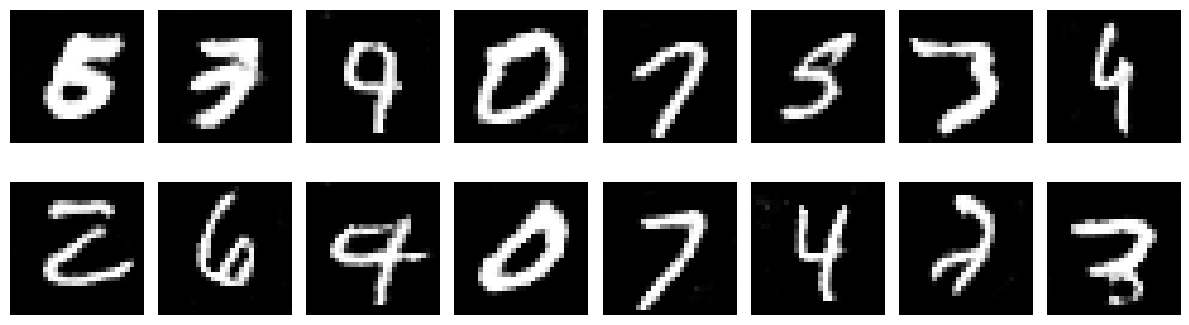

Epoch 76/100
Step 0/938 [D loss: 0.6816, acc.: 71.09%] [G loss: 1.0309]
Step 100/938 [D loss: 0.6894, acc.: 65.62%] [G loss: 0.9405]
Step 200/938 [D loss: 0.6538, acc.: 66.41%] [G loss: 1.0292]
Step 300/938 [D loss: 0.6619, acc.: 67.19%] [G loss: 1.0303]
Step 400/938 [D loss: 0.6559, acc.: 71.09%] [G loss: 1.0196]
Step 500/938 [D loss: 0.6539, acc.: 72.66%] [G loss: 0.9855]
Step 600/938 [D loss: 0.6683, acc.: 71.09%] [G loss: 1.1221]
Step 700/938 [D loss: 0.6189, acc.: 70.31%] [G loss: 0.9619]
Step 800/938 [D loss: 0.6993, acc.: 68.75%] [G loss: 0.9664]
Step 900/938 [D loss: 0.6906, acc.: 65.62%] [G loss: 1.0124]
1/1 [==============================] - 0s 24ms/step


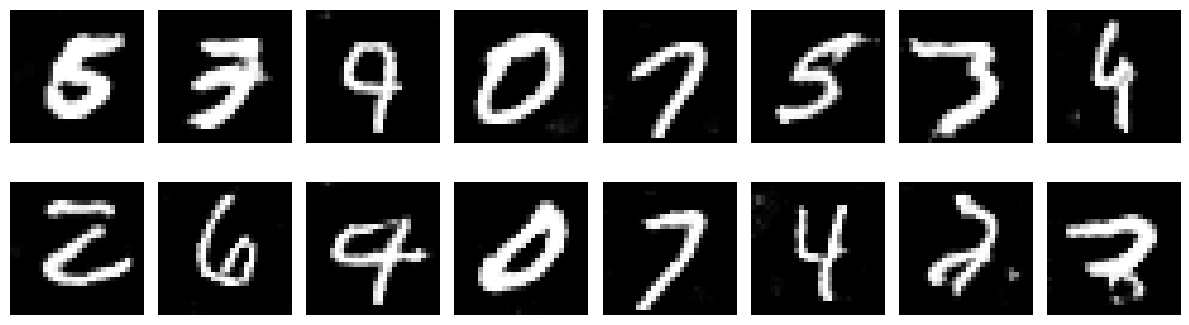

Epoch 77/100
Step 0/938 [D loss: 0.6281, acc.: 67.97%] [G loss: 1.0377]
Step 100/938 [D loss: 0.6556, acc.: 67.97%] [G loss: 1.0360]
Step 200/938 [D loss: 0.6763, acc.: 72.66%] [G loss: 1.0120]
Step 300/938 [D loss: 0.6705, acc.: 70.31%] [G loss: 1.0418]
Step 400/938 [D loss: 0.6546, acc.: 67.19%] [G loss: 1.0399]
Step 500/938 [D loss: 0.6594, acc.: 78.91%] [G loss: 1.0213]
Step 600/938 [D loss: 0.6843, acc.: 72.66%] [G loss: 1.0235]
Step 700/938 [D loss: 0.6474, acc.: 69.53%] [G loss: 1.0257]
Step 800/938 [D loss: 0.6368, acc.: 69.53%] [G loss: 0.9525]
Step 900/938 [D loss: 0.6743, acc.: 65.62%] [G loss: 1.0189]
1/1 [==============================] - 0s 27ms/step


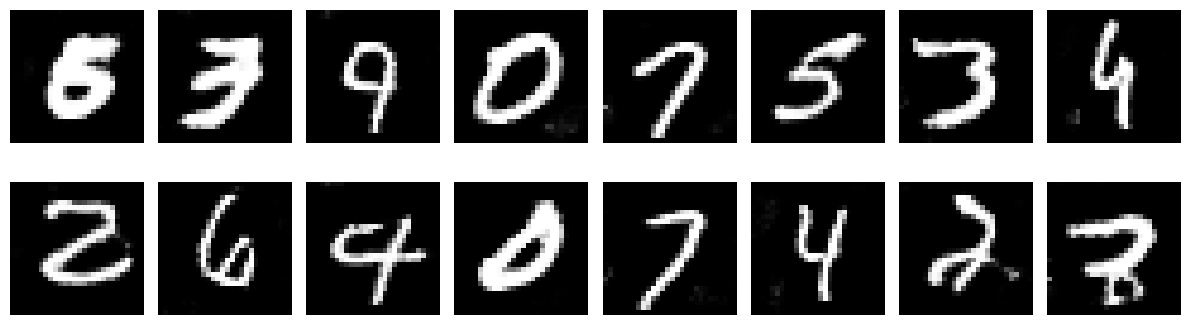

Epoch 78/100
Step 0/938 [D loss: 0.6484, acc.: 67.97%] [G loss: 1.0176]
Step 100/938 [D loss: 0.6606, acc.: 67.19%] [G loss: 0.9853]
Step 200/938 [D loss: 0.6419, acc.: 67.97%] [G loss: 1.0198]
Step 300/938 [D loss: 0.6521, acc.: 76.56%] [G loss: 1.0334]
Step 400/938 [D loss: 0.6204, acc.: 68.75%] [G loss: 1.0905]
Step 500/938 [D loss: 0.6544, acc.: 74.22%] [G loss: 0.9605]
Step 600/938 [D loss: 0.6692, acc.: 74.22%] [G loss: 1.0211]
Step 700/938 [D loss: 0.6418, acc.: 68.75%] [G loss: 1.0923]
Step 800/938 [D loss: 0.6600, acc.: 67.19%] [G loss: 0.9984]
Step 900/938 [D loss: 0.6868, acc.: 72.66%] [G loss: 1.0239]
1/1 [==============================] - 0s 26ms/step


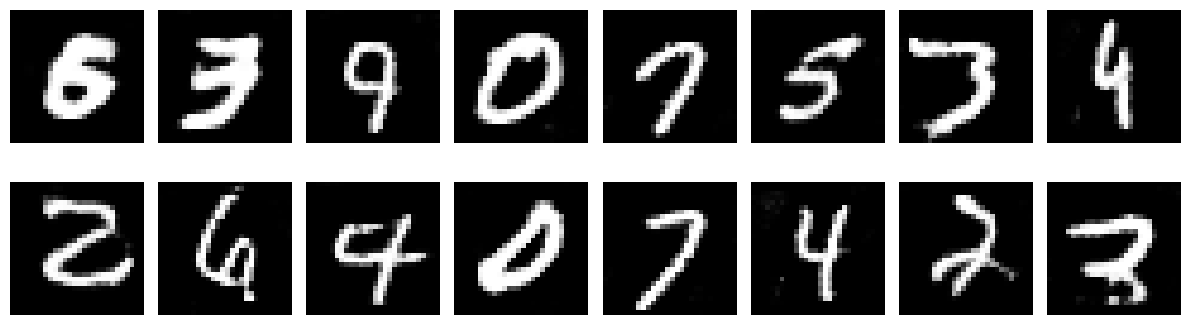

Epoch 79/100
Step 0/938 [D loss: 0.6553, acc.: 71.09%] [G loss: 1.0254]
Step 100/938 [D loss: 0.6579, acc.: 67.97%] [G loss: 1.0147]
Step 200/938 [D loss: 0.6530, acc.: 68.75%] [G loss: 0.9569]
Step 300/938 [D loss: 0.6669, acc.: 66.41%] [G loss: 0.9750]
Step 400/938 [D loss: 0.7092, acc.: 67.19%] [G loss: 1.1011]
Step 500/938 [D loss: 0.6741, acc.: 67.19%] [G loss: 1.0302]
Step 600/938 [D loss: 0.6733, acc.: 69.53%] [G loss: 1.0580]
Step 700/938 [D loss: 0.6361, acc.: 71.88%] [G loss: 0.9854]
Step 800/938 [D loss: 0.6198, acc.: 78.12%] [G loss: 1.0215]
Step 900/938 [D loss: 0.6123, acc.: 72.66%] [G loss: 1.0460]
1/1 [==============================] - 0s 28ms/step


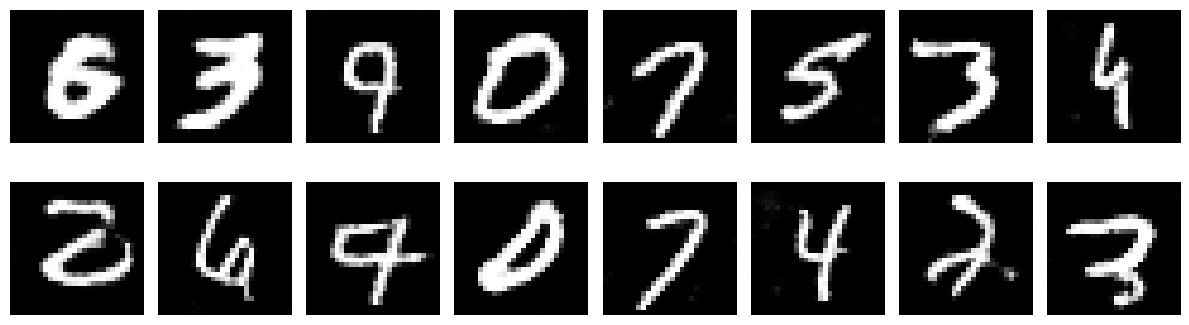

Epoch 80/100
Step 0/938 [D loss: 0.6699, acc.: 78.12%] [G loss: 0.9306]
Step 100/938 [D loss: 0.6529, acc.: 70.31%] [G loss: 1.0006]
Step 200/938 [D loss: 0.7023, acc.: 63.28%] [G loss: 1.0052]
Step 300/938 [D loss: 0.6564, acc.: 72.66%] [G loss: 0.9726]
Step 400/938 [D loss: 0.6596, acc.: 66.41%] [G loss: 0.9929]
Step 500/938 [D loss: 0.6572, acc.: 71.88%] [G loss: 0.9910]
Step 600/938 [D loss: 0.6227, acc.: 71.88%] [G loss: 1.0048]
Step 700/938 [D loss: 0.6313, acc.: 75.00%] [G loss: 1.0213]
Step 800/938 [D loss: 0.6901, acc.: 67.19%] [G loss: 1.0929]
Step 900/938 [D loss: 0.6677, acc.: 67.97%] [G loss: 1.0038]
1/1 [==============================] - 0s 26ms/step


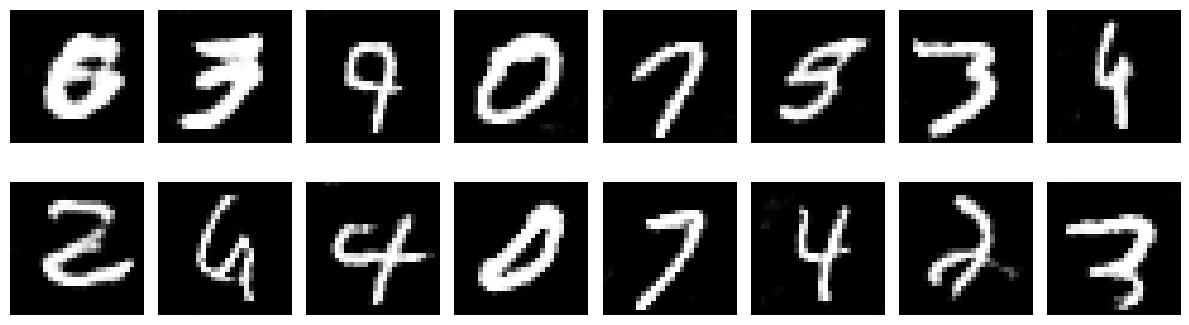

Epoch 81/100
Step 0/938 [D loss: 0.6328, acc.: 72.66%] [G loss: 1.0542]
Step 100/938 [D loss: 0.6389, acc.: 71.88%] [G loss: 1.0907]
Step 200/938 [D loss: 0.6615, acc.: 73.44%] [G loss: 0.9676]
Step 300/938 [D loss: 0.6326, acc.: 71.09%] [G loss: 0.9643]
Step 400/938 [D loss: 0.6622, acc.: 67.19%] [G loss: 1.0374]
Step 500/938 [D loss: 0.6855, acc.: 69.53%] [G loss: 1.0661]
Step 600/938 [D loss: 0.6519, acc.: 72.66%] [G loss: 0.9944]
Step 700/938 [D loss: 0.6918, acc.: 64.06%] [G loss: 1.0420]
Step 800/938 [D loss: 0.6440, acc.: 73.44%] [G loss: 0.9230]
Step 900/938 [D loss: 0.6594, acc.: 67.19%] [G loss: 0.9686]
1/1 [==============================] - 0s 23ms/step


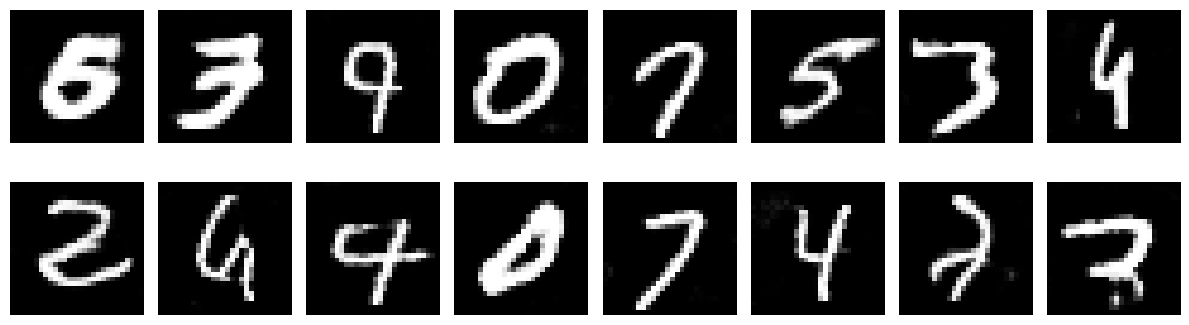

Epoch 82/100
Step 0/938 [D loss: 0.6169, acc.: 72.66%] [G loss: 1.0416]
Step 100/938 [D loss: 0.6654, acc.: 67.19%] [G loss: 1.1388]
Step 200/938 [D loss: 0.6873, acc.: 60.94%] [G loss: 1.0295]
Step 300/938 [D loss: 0.6509, acc.: 68.75%] [G loss: 0.9337]
Step 400/938 [D loss: 0.6276, acc.: 75.00%] [G loss: 1.0421]
Step 500/938 [D loss: 0.6108, acc.: 78.12%] [G loss: 1.0083]
Step 600/938 [D loss: 0.6813, acc.: 70.31%] [G loss: 0.9704]
Step 700/938 [D loss: 0.6430, acc.: 72.66%] [G loss: 0.9995]
Step 800/938 [D loss: 0.6467, acc.: 68.75%] [G loss: 1.0764]
Step 900/938 [D loss: 0.6471, acc.: 72.66%] [G loss: 1.0481]
1/1 [==============================] - 0s 25ms/step


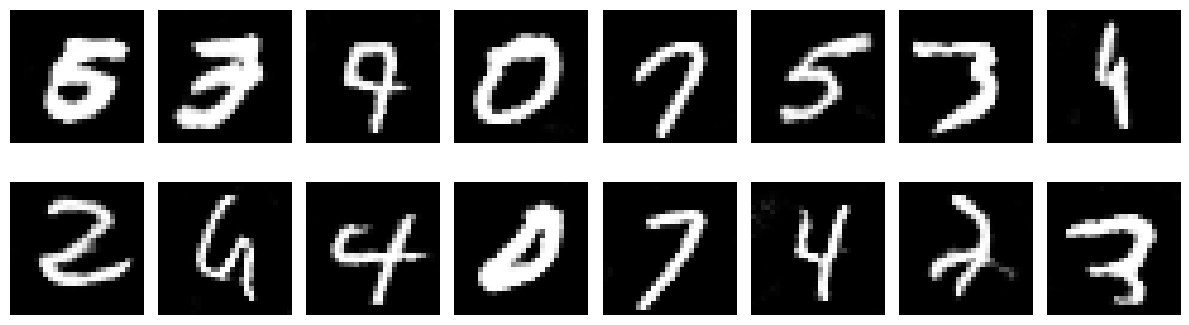

Epoch 83/100
Step 0/938 [D loss: 0.6596, acc.: 64.06%] [G loss: 1.1423]
Step 100/938 [D loss: 0.6549, acc.: 67.97%] [G loss: 0.9869]
Step 200/938 [D loss: 0.6563, acc.: 73.44%] [G loss: 0.9565]
Step 300/938 [D loss: 0.6720, acc.: 68.75%] [G loss: 0.9888]
Step 400/938 [D loss: 0.6550, acc.: 68.75%] [G loss: 1.0602]
Step 500/938 [D loss: 0.6658, acc.: 67.97%] [G loss: 0.9873]
Step 600/938 [D loss: 0.6285, acc.: 74.22%] [G loss: 1.0388]
Step 700/938 [D loss: 0.6367, acc.: 71.09%] [G loss: 1.0496]
Step 800/938 [D loss: 0.6761, acc.: 67.97%] [G loss: 1.0408]
Step 900/938 [D loss: 0.6441, acc.: 72.66%] [G loss: 1.0428]
1/1 [==============================] - 0s 26ms/step


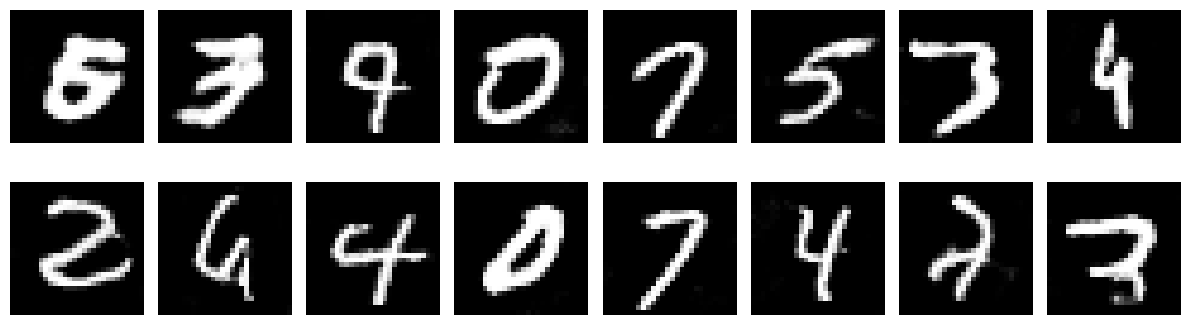

Epoch 84/100
Step 0/938 [D loss: 0.6256, acc.: 71.88%] [G loss: 1.0547]
Step 100/938 [D loss: 0.6477, acc.: 70.31%] [G loss: 1.0309]
Step 200/938 [D loss: 0.5981, acc.: 72.66%] [G loss: 1.0240]
Step 300/938 [D loss: 0.6310, acc.: 67.19%] [G loss: 0.9699]
Step 400/938 [D loss: 0.6546, acc.: 66.41%] [G loss: 0.9465]
Step 500/938 [D loss: 0.6547, acc.: 66.41%] [G loss: 1.0252]
Step 600/938 [D loss: 0.6480, acc.: 68.75%] [G loss: 0.9742]
Step 700/938 [D loss: 0.6829, acc.: 70.31%] [G loss: 0.9877]
Step 800/938 [D loss: 0.6531, acc.: 74.22%] [G loss: 0.9712]
Step 900/938 [D loss: 0.6607, acc.: 70.31%] [G loss: 1.0105]
1/1 [==============================] - 0s 25ms/step


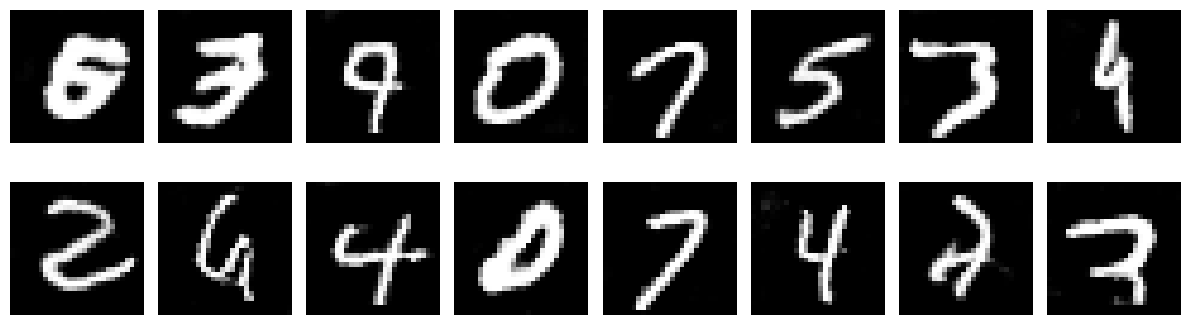

Epoch 85/100
Step 0/938 [D loss: 0.6537, acc.: 72.66%] [G loss: 1.0191]
Step 100/938 [D loss: 0.6448, acc.: 69.53%] [G loss: 1.0495]
Step 200/938 [D loss: 0.6815, acc.: 64.84%] [G loss: 0.9969]
Step 300/938 [D loss: 0.6494, acc.: 75.78%] [G loss: 0.9814]
Step 400/938 [D loss: 0.6504, acc.: 73.44%] [G loss: 1.0686]
Step 500/938 [D loss: 0.6940, acc.: 73.44%] [G loss: 1.0308]
Step 600/938 [D loss: 0.6410, acc.: 78.91%] [G loss: 1.0681]
Step 700/938 [D loss: 0.6313, acc.: 78.12%] [G loss: 1.0099]
Step 800/938 [D loss: 0.6708, acc.: 70.31%] [G loss: 1.0212]
Step 900/938 [D loss: 0.6853, acc.: 67.19%] [G loss: 1.0155]
1/1 [==============================] - 0s 27ms/step


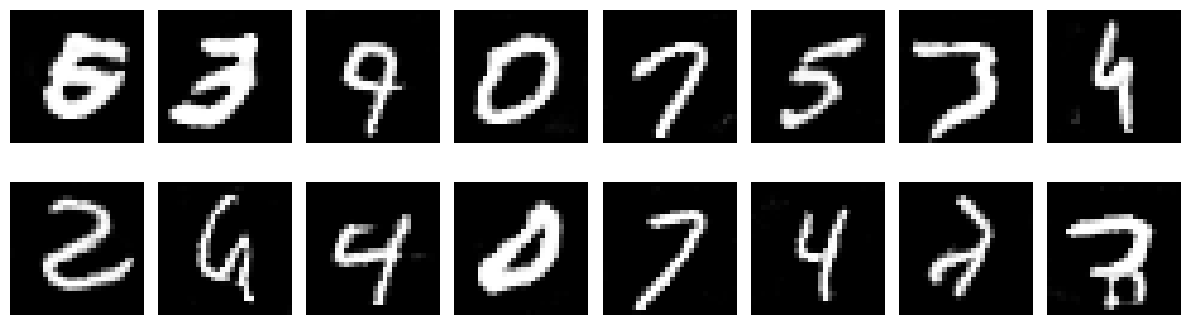

Epoch 86/100
Step 0/938 [D loss: 0.6823, acc.: 67.97%] [G loss: 1.0164]
Step 100/938 [D loss: 0.6461, acc.: 66.41%] [G loss: 1.0405]
Step 200/938 [D loss: 0.6703, acc.: 67.19%] [G loss: 0.9890]
Step 300/938 [D loss: 0.6923, acc.: 62.50%] [G loss: 0.9810]
Step 400/938 [D loss: 0.6780, acc.: 68.75%] [G loss: 1.0042]
Step 500/938 [D loss: 0.6252, acc.: 70.31%] [G loss: 1.0318]
Step 600/938 [D loss: 0.6278, acc.: 74.22%] [G loss: 1.0271]
Step 700/938 [D loss: 0.6479, acc.: 65.62%] [G loss: 1.0386]
Step 800/938 [D loss: 0.6303, acc.: 69.53%] [G loss: 0.9942]
Step 900/938 [D loss: 0.6156, acc.: 71.09%] [G loss: 1.0336]
1/1 [==============================] - 0s 25ms/step


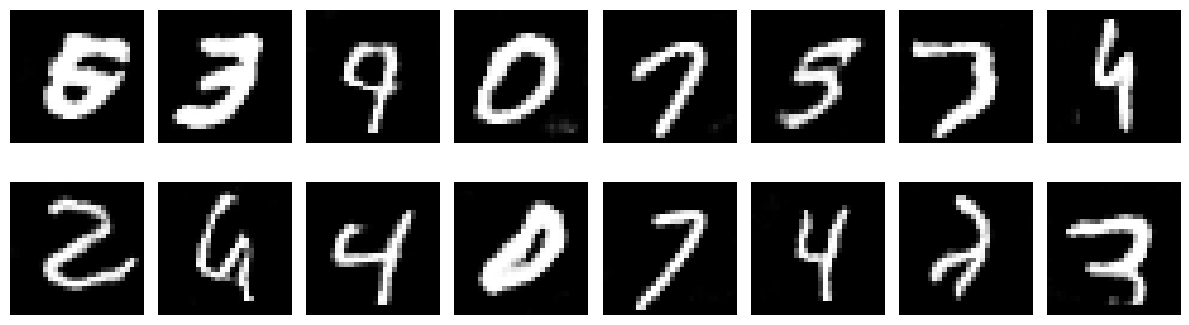

Epoch 87/100
Step 0/938 [D loss: 0.6264, acc.: 70.31%] [G loss: 1.0387]
Step 100/938 [D loss: 0.6566, acc.: 69.53%] [G loss: 1.0170]
Step 200/938 [D loss: 0.6912, acc.: 61.72%] [G loss: 1.0503]
Step 300/938 [D loss: 0.6553, acc.: 69.53%] [G loss: 0.9980]
Step 400/938 [D loss: 0.6717, acc.: 66.41%] [G loss: 1.0435]
Step 500/938 [D loss: 0.6411, acc.: 69.53%] [G loss: 1.0393]
Step 600/938 [D loss: 0.6794, acc.: 65.62%] [G loss: 1.1064]
Step 700/938 [D loss: 0.6756, acc.: 66.41%] [G loss: 1.0634]
Step 800/938 [D loss: 0.6878, acc.: 66.41%] [G loss: 1.0070]
Step 900/938 [D loss: 0.6943, acc.: 67.19%] [G loss: 0.9596]
1/1 [==============================] - 0s 25ms/step


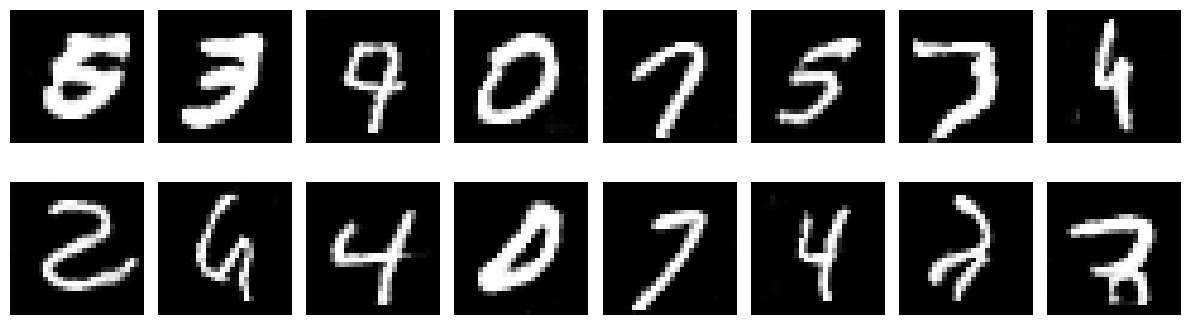

Epoch 88/100
Step 0/938 [D loss: 0.6911, acc.: 66.41%] [G loss: 0.9887]
Step 100/938 [D loss: 0.6550, acc.: 71.88%] [G loss: 1.0538]
Step 200/938 [D loss: 0.7089, acc.: 71.09%] [G loss: 1.0564]
Step 300/938 [D loss: 0.6554, acc.: 76.56%] [G loss: 0.9708]
Step 400/938 [D loss: 0.6368, acc.: 74.22%] [G loss: 1.0420]
Step 500/938 [D loss: 0.6693, acc.: 64.06%] [G loss: 1.0504]
Step 600/938 [D loss: 0.6383, acc.: 70.31%] [G loss: 1.0457]
Step 700/938 [D loss: 0.6530, acc.: 68.75%] [G loss: 1.0129]
Step 800/938 [D loss: 0.6767, acc.: 67.19%] [G loss: 1.0481]
Step 900/938 [D loss: 0.6454, acc.: 65.62%] [G loss: 0.9505]
1/1 [==============================] - 0s 25ms/step


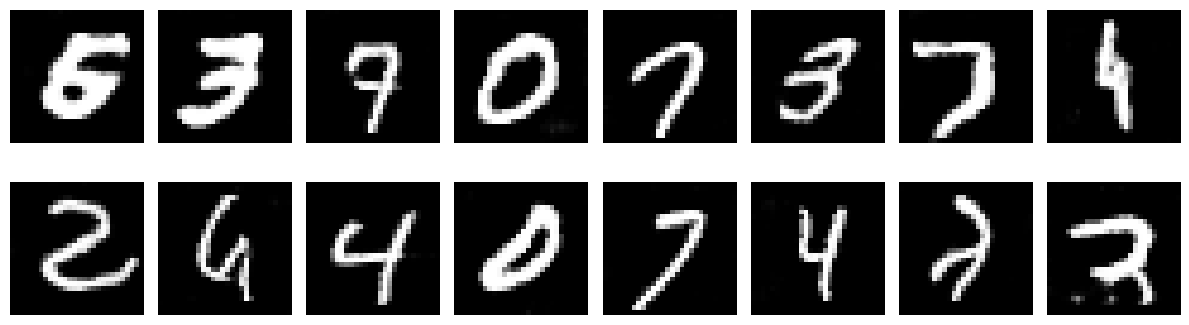

Epoch 89/100
Step 0/938 [D loss: 0.6632, acc.: 71.88%] [G loss: 1.0235]
Step 100/938 [D loss: 0.6410, acc.: 73.44%] [G loss: 1.0314]
Step 200/938 [D loss: 0.6232, acc.: 71.09%] [G loss: 1.1249]
Step 300/938 [D loss: 0.6382, acc.: 71.09%] [G loss: 1.0160]
Step 400/938 [D loss: 0.6771, acc.: 69.53%] [G loss: 0.9376]
Step 500/938 [D loss: 0.6968, acc.: 67.97%] [G loss: 0.9531]
Step 600/938 [D loss: 0.6493, acc.: 66.41%] [G loss: 1.0604]
Step 700/938 [D loss: 0.6133, acc.: 75.00%] [G loss: 1.0759]
Step 800/938 [D loss: 0.6548, acc.: 70.31%] [G loss: 1.0621]
Step 900/938 [D loss: 0.6675, acc.: 71.88%] [G loss: 1.0913]
1/1 [==============================] - 0s 27ms/step


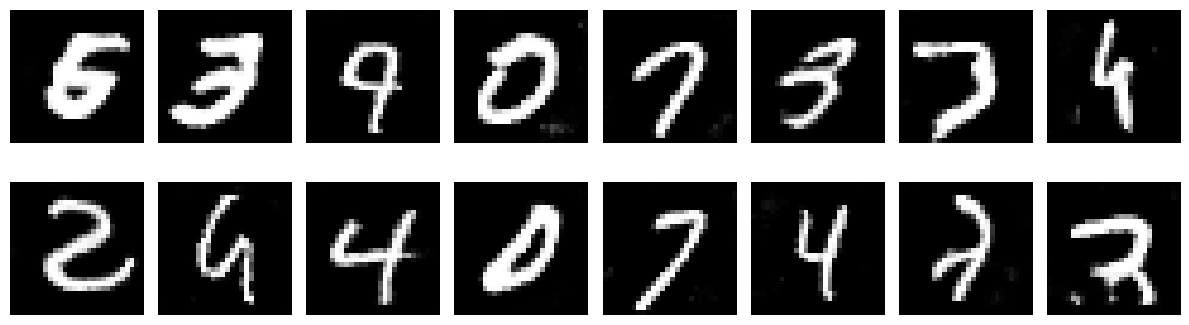

Epoch 90/100
Step 0/938 [D loss: 0.6413, acc.: 75.00%] [G loss: 1.0538]
Step 100/938 [D loss: 0.6709, acc.: 69.53%] [G loss: 1.0272]
Step 200/938 [D loss: 0.6630, acc.: 64.84%] [G loss: 0.9576]
Step 300/938 [D loss: 0.6352, acc.: 72.66%] [G loss: 0.9804]
Step 400/938 [D loss: 0.6390, acc.: 68.75%] [G loss: 0.9441]
Step 500/938 [D loss: 0.6662, acc.: 69.53%] [G loss: 0.9932]
Step 600/938 [D loss: 0.6182, acc.: 71.88%] [G loss: 0.9306]
Step 700/938 [D loss: 0.6701, acc.: 71.09%] [G loss: 1.0290]
Step 800/938 [D loss: 0.6621, acc.: 68.75%] [G loss: 1.0253]
Step 900/938 [D loss: 0.6680, acc.: 71.09%] [G loss: 1.0163]
1/1 [==============================] - 0s 30ms/step


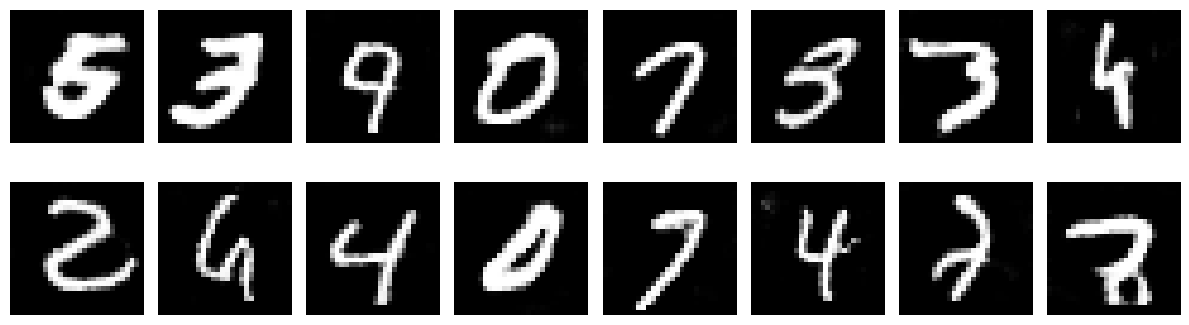

Epoch 91/100
Step 0/938 [D loss: 0.6402, acc.: 71.88%] [G loss: 1.0039]
Step 100/938 [D loss: 0.6650, acc.: 71.88%] [G loss: 0.9883]
Step 200/938 [D loss: 0.6583, acc.: 74.22%] [G loss: 1.0255]
Step 300/938 [D loss: 0.6393, acc.: 71.88%] [G loss: 1.0449]
Step 400/938 [D loss: 0.6500, acc.: 73.44%] [G loss: 0.9484]
Step 500/938 [D loss: 0.6449, acc.: 68.75%] [G loss: 1.0344]
Step 600/938 [D loss: 0.6335, acc.: 77.34%] [G loss: 0.9500]
Step 700/938 [D loss: 0.6346, acc.: 71.88%] [G loss: 1.1723]
Step 800/938 [D loss: 0.6431, acc.: 72.66%] [G loss: 0.9363]
Step 900/938 [D loss: 0.6852, acc.: 71.88%] [G loss: 1.0041]
1/1 [==============================] - 0s 26ms/step


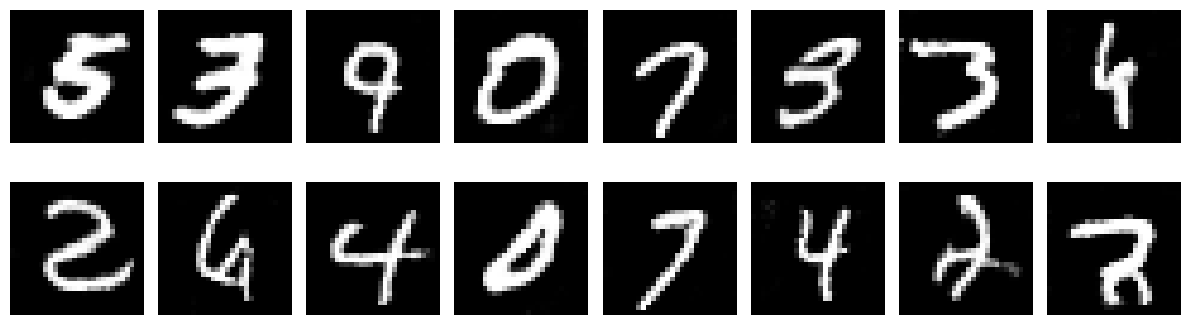

Epoch 92/100
Step 0/938 [D loss: 0.6864, acc.: 64.06%] [G loss: 1.0800]
Step 100/938 [D loss: 0.6378, acc.: 70.31%] [G loss: 1.0180]
Step 200/938 [D loss: 0.6662, acc.: 64.84%] [G loss: 1.0097]
Step 300/938 [D loss: 0.6526, acc.: 74.22%] [G loss: 0.9818]
Step 400/938 [D loss: 0.6642, acc.: 70.31%] [G loss: 0.9990]
Step 500/938 [D loss: 0.6585, acc.: 69.53%] [G loss: 0.9724]
Step 600/938 [D loss: 0.7058, acc.: 65.62%] [G loss: 1.0051]
Step 700/938 [D loss: 0.6744, acc.: 71.09%] [G loss: 0.9742]
Step 800/938 [D loss: 0.6740, acc.: 66.41%] [G loss: 1.0515]
Step 900/938 [D loss: 0.6314, acc.: 74.22%] [G loss: 1.0104]
1/1 [==============================] - 0s 28ms/step


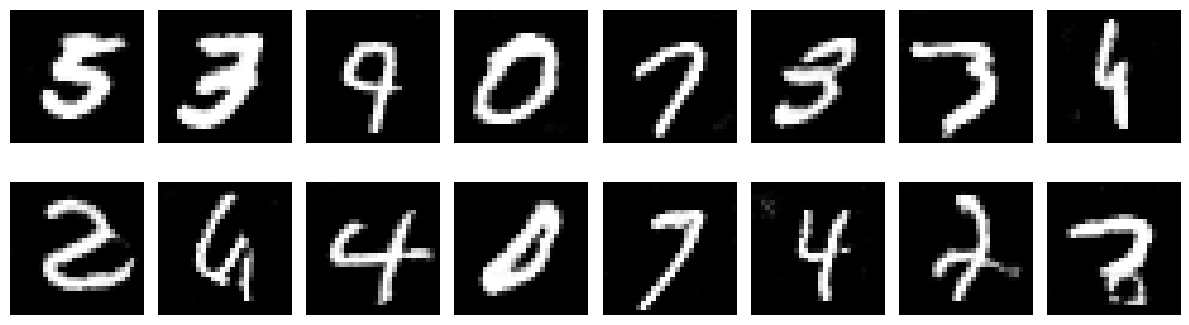

Epoch 93/100
Step 0/938 [D loss: 0.6351, acc.: 77.34%] [G loss: 1.0232]
Step 100/938 [D loss: 0.6421, acc.: 68.75%] [G loss: 1.0154]
Step 200/938 [D loss: 0.6857, acc.: 65.62%] [G loss: 0.9920]
Step 300/938 [D loss: 0.6623, acc.: 72.66%] [G loss: 0.9975]
Step 400/938 [D loss: 0.6901, acc.: 67.97%] [G loss: 1.0110]
Step 500/938 [D loss: 0.6397, acc.: 78.91%] [G loss: 0.9457]
Step 600/938 [D loss: 0.6746, acc.: 71.88%] [G loss: 1.0476]
Step 700/938 [D loss: 0.6555, acc.: 76.56%] [G loss: 0.9974]
Step 800/938 [D loss: 0.6362, acc.: 67.97%] [G loss: 1.0215]
Step 900/938 [D loss: 0.6338, acc.: 71.09%] [G loss: 0.9919]
1/1 [==============================] - 0s 34ms/step


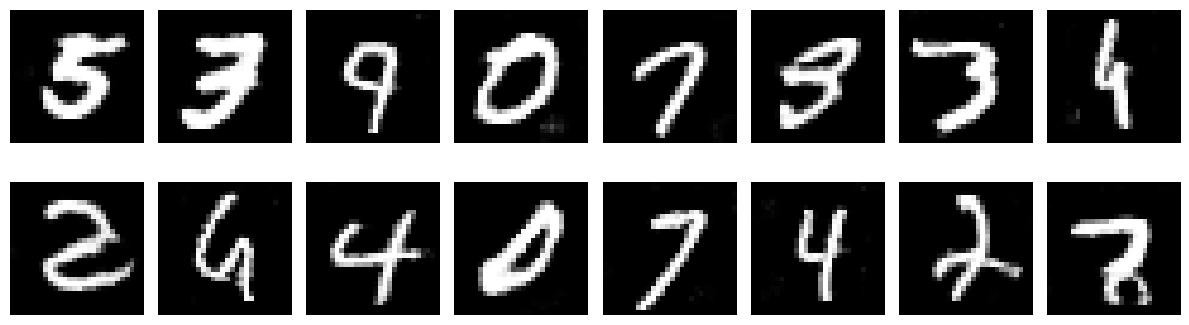

Epoch 94/100
Step 0/938 [D loss: 0.6676, acc.: 70.31%] [G loss: 0.9723]
Step 100/938 [D loss: 0.6673, acc.: 67.19%] [G loss: 1.0642]
Step 200/938 [D loss: 0.6419, acc.: 71.88%] [G loss: 1.0444]
Step 300/938 [D loss: 0.6387, acc.: 73.44%] [G loss: 0.9882]
Step 400/938 [D loss: 0.6754, acc.: 64.84%] [G loss: 0.9953]
Step 500/938 [D loss: 0.6590, acc.: 70.31%] [G loss: 1.1032]
Step 600/938 [D loss: 0.6486, acc.: 67.97%] [G loss: 0.9639]
Step 700/938 [D loss: 0.6599, acc.: 67.97%] [G loss: 1.0668]
Step 800/938 [D loss: 0.6784, acc.: 71.09%] [G loss: 1.0012]
Step 900/938 [D loss: 0.6309, acc.: 70.31%] [G loss: 1.0261]
1/1 [==============================] - 0s 26ms/step


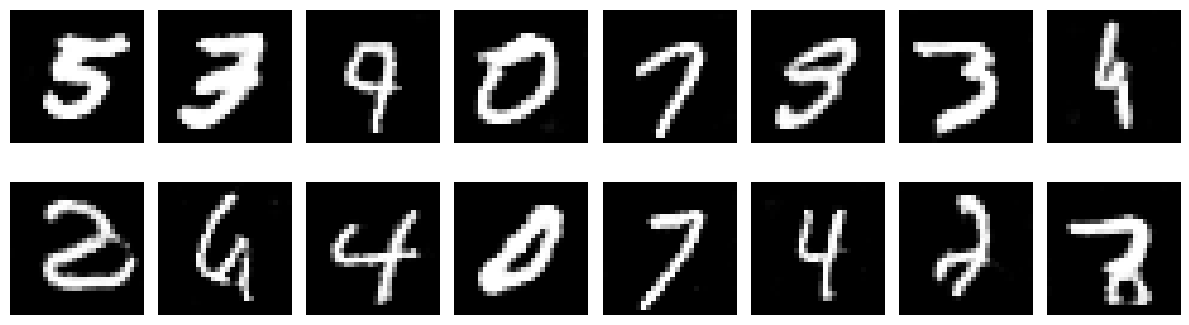

Epoch 95/100
Step 0/938 [D loss: 0.6179, acc.: 71.09%] [G loss: 1.0115]
Step 100/938 [D loss: 0.6726, acc.: 69.53%] [G loss: 0.9988]
Step 200/938 [D loss: 0.6497, acc.: 68.75%] [G loss: 1.1094]
Step 300/938 [D loss: 0.6702, acc.: 72.66%] [G loss: 1.0438]
Step 400/938 [D loss: 0.6543, acc.: 70.31%] [G loss: 0.9829]
Step 500/938 [D loss: 0.6537, acc.: 73.44%] [G loss: 1.0981]
Step 600/938 [D loss: 0.6614, acc.: 71.88%] [G loss: 1.0420]
Step 700/938 [D loss: 0.6636, acc.: 73.44%] [G loss: 1.0040]
Step 800/938 [D loss: 0.6489, acc.: 67.97%] [G loss: 0.9506]
Step 900/938 [D loss: 0.6276, acc.: 75.00%] [G loss: 1.0472]
1/1 [==============================] - 0s 28ms/step


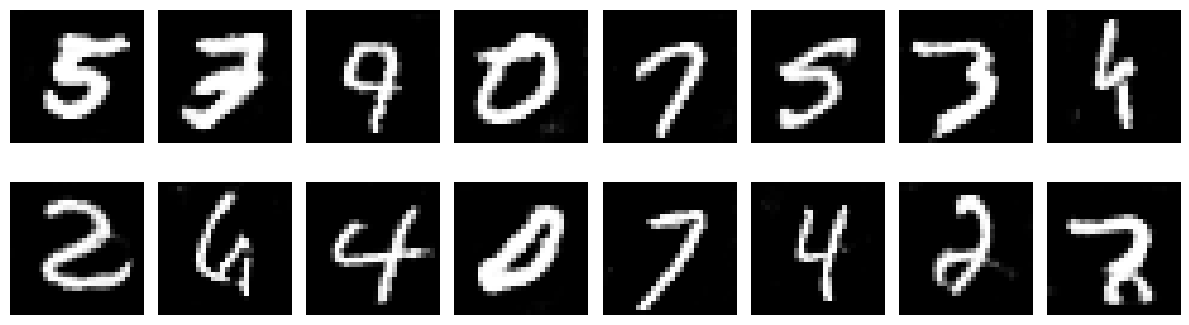

Epoch 96/100
Step 0/938 [D loss: 0.6586, acc.: 67.97%] [G loss: 0.9850]
Step 100/938 [D loss: 0.6421, acc.: 67.97%] [G loss: 1.0379]
Step 200/938 [D loss: 0.6782, acc.: 65.62%] [G loss: 0.9843]
Step 300/938 [D loss: 0.6455, acc.: 74.22%] [G loss: 1.0418]
Step 400/938 [D loss: 0.7046, acc.: 67.97%] [G loss: 1.0504]
Step 500/938 [D loss: 0.6563, acc.: 68.75%] [G loss: 0.9611]
Step 600/938 [D loss: 0.6555, acc.: 69.53%] [G loss: 1.0234]
Step 700/938 [D loss: 0.6599, acc.: 64.84%] [G loss: 0.9460]
Step 800/938 [D loss: 0.6690, acc.: 70.31%] [G loss: 1.0979]
Step 900/938 [D loss: 0.6479, acc.: 67.97%] [G loss: 0.9335]
1/1 [==============================] - 0s 26ms/step


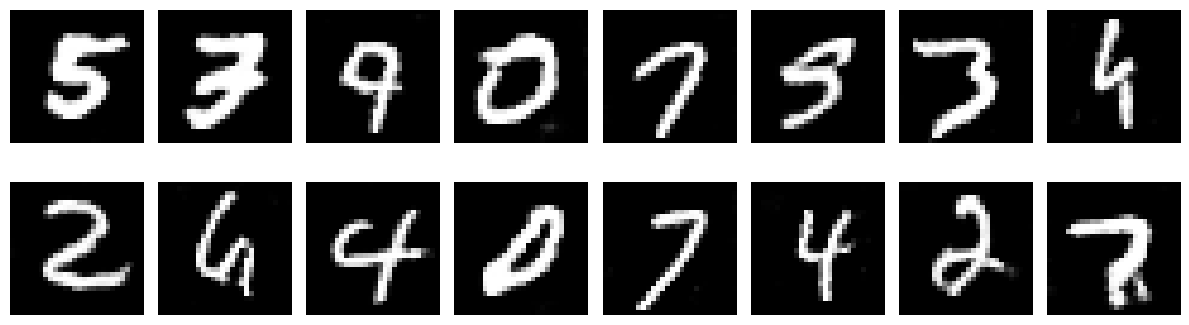

Epoch 97/100
Step 0/938 [D loss: 0.6585, acc.: 67.19%] [G loss: 0.9888]
Step 100/938 [D loss: 0.6551, acc.: 71.88%] [G loss: 0.9862]
Step 200/938 [D loss: 0.6689, acc.: 66.41%] [G loss: 0.9554]
Step 300/938 [D loss: 0.6381, acc.: 65.62%] [G loss: 1.0292]
Step 400/938 [D loss: 0.6783, acc.: 65.62%] [G loss: 1.0912]
Step 500/938 [D loss: 0.6398, acc.: 75.00%] [G loss: 1.0481]
Step 600/938 [D loss: 0.6300, acc.: 68.75%] [G loss: 0.9715]
Step 700/938 [D loss: 0.6803, acc.: 64.06%] [G loss: 0.9673]
Step 800/938 [D loss: 0.6046, acc.: 73.44%] [G loss: 1.0094]
Step 900/938 [D loss: 0.6473, acc.: 65.62%] [G loss: 1.0123]
1/1 [==============================] - 0s 27ms/step


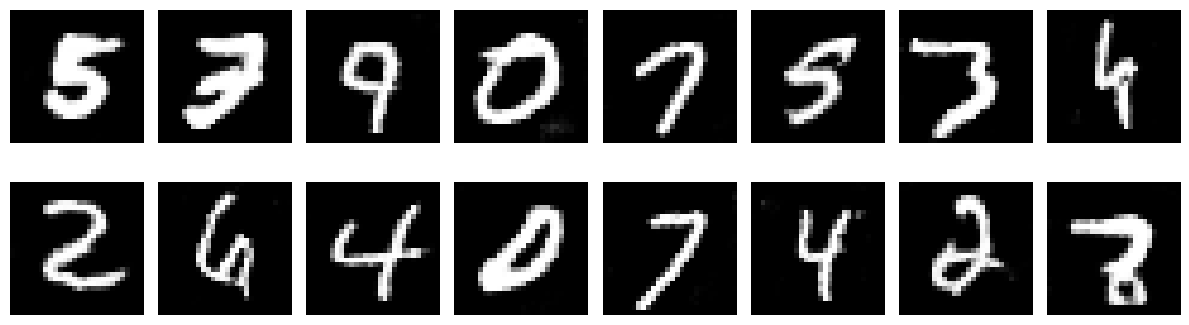

Epoch 98/100
Step 0/938 [D loss: 0.6672, acc.: 75.00%] [G loss: 1.0394]
Step 100/938 [D loss: 0.6047, acc.: 76.56%] [G loss: 0.9890]
Step 200/938 [D loss: 0.6844, acc.: 70.31%] [G loss: 1.0649]
Step 300/938 [D loss: 0.6488, acc.: 71.88%] [G loss: 1.0362]
Step 400/938 [D loss: 0.6459, acc.: 67.97%] [G loss: 0.9941]
Step 500/938 [D loss: 0.6965, acc.: 66.41%] [G loss: 1.0042]
Step 600/938 [D loss: 0.6272, acc.: 71.09%] [G loss: 1.0187]
Step 700/938 [D loss: 0.7093, acc.: 60.94%] [G loss: 1.0525]
Step 800/938 [D loss: 0.6832, acc.: 70.31%] [G loss: 1.0845]
Step 900/938 [D loss: 0.6910, acc.: 65.62%] [G loss: 1.0765]
1/1 [==============================] - 0s 28ms/step


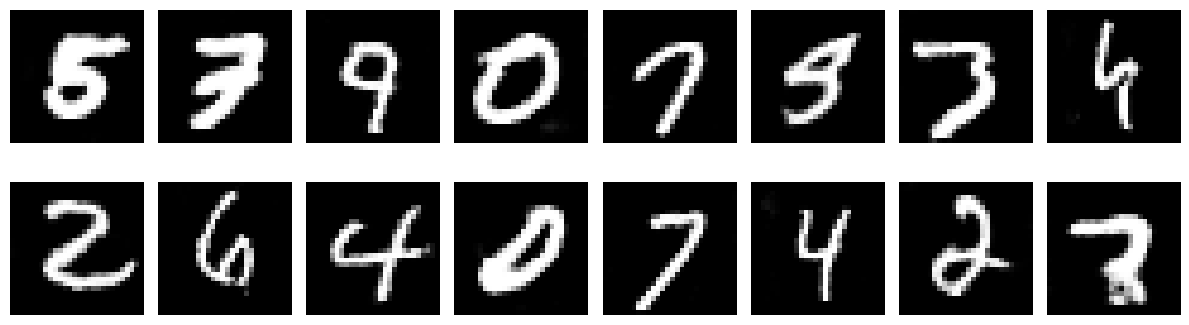

Epoch 99/100
Step 0/938 [D loss: 0.6718, acc.: 72.66%] [G loss: 1.0085]
Step 100/938 [D loss: 0.6955, acc.: 67.19%] [G loss: 1.0403]
Step 200/938 [D loss: 0.6114, acc.: 68.75%] [G loss: 1.0546]
Step 300/938 [D loss: 0.6480, acc.: 69.53%] [G loss: 1.0197]
Step 400/938 [D loss: 0.6390, acc.: 69.53%] [G loss: 0.9769]
Step 500/938 [D loss: 0.6593, acc.: 67.19%] [G loss: 1.0172]
Step 600/938 [D loss: 0.6452, acc.: 69.53%] [G loss: 0.9711]
Step 700/938 [D loss: 0.6365, acc.: 77.34%] [G loss: 1.1014]
Step 800/938 [D loss: 0.6397, acc.: 69.53%] [G loss: 1.0686]
Step 900/938 [D loss: 0.6544, acc.: 67.19%] [G loss: 1.0090]
1/1 [==============================] - 0s 31ms/step


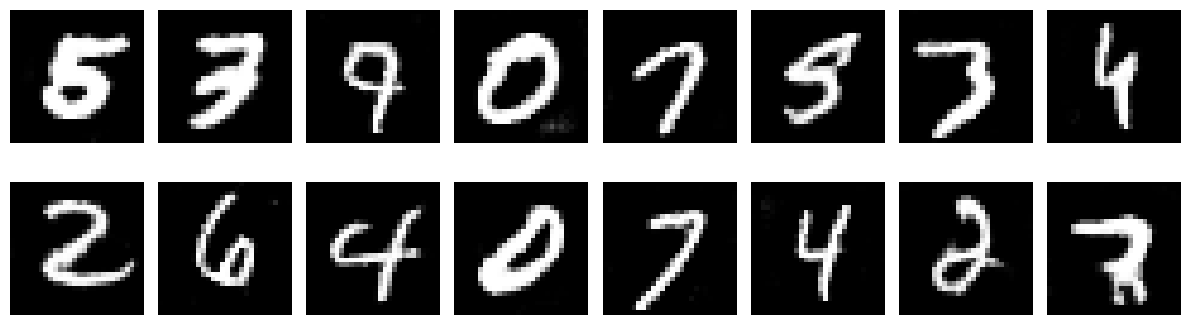

Epoch 100/100
Step 0/938 [D loss: 0.6854, acc.: 64.84%] [G loss: 0.9966]
Step 100/938 [D loss: 0.6750, acc.: 69.53%] [G loss: 1.0406]
Step 200/938 [D loss: 0.6609, acc.: 69.53%] [G loss: 1.0459]
Step 300/938 [D loss: 0.6467, acc.: 67.97%] [G loss: 1.0141]
Step 400/938 [D loss: 0.6251, acc.: 72.66%] [G loss: 0.9927]
Step 500/938 [D loss: 0.6963, acc.: 67.19%] [G loss: 1.0742]
Step 600/938 [D loss: 0.6523, acc.: 74.22%] [G loss: 1.0413]
Step 700/938 [D loss: 0.6360, acc.: 65.62%] [G loss: 1.0033]
Step 800/938 [D loss: 0.6419, acc.: 69.53%] [G loss: 1.0567]
Step 900/938 [D loss: 0.6560, acc.: 70.31%] [G loss: 0.9934]
1/1 [==============================] - 0s 30ms/step


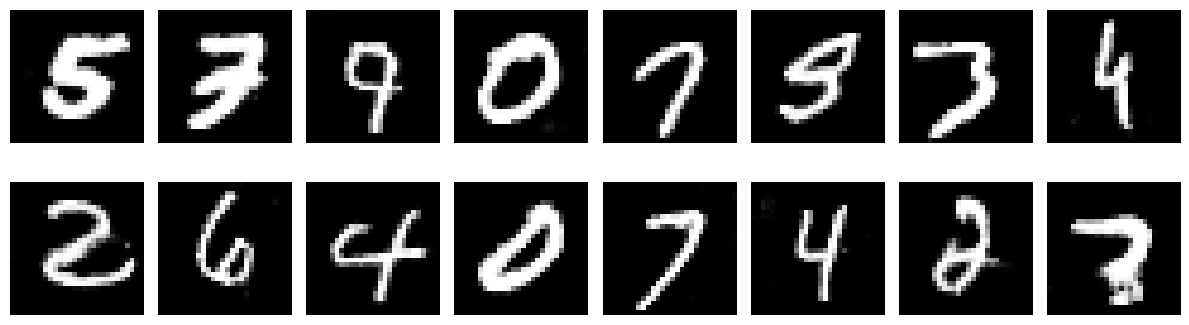

In [18]:
epochs = 100  # Increase the number of epochs
batch_size = 64
steps_per_epoch = train_images.shape[0] // batch_size + \
                  (train_images.shape[0] % batch_size != 0)
num_gen_images = 16
fixed_noise = np.random.normal(0, 1, (num_gen_images, latent_size))

for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    np.random.shuffle(train_images)

    for i in range(steps_per_epoch):
        # ---------------------
        #  Train Discriminator
        # ---------------------
        discriminator.trainable = True

        # Sample real images
        real_images = train_images[i*batch_size:(i+1)*batch_size]
        current_batch_size = real_images.shape[0]

        # Generate fake images
        noise = np.random.normal(0, 1, (current_batch_size, latent_size))
        fake_images = generator.predict(noise, verbose=0)

        # Labels for real and fake images
        real_labels = np.ones((current_batch_size, 1)) * 0.9  # Label smoothing
        fake_labels = np.zeros((current_batch_size, 1))

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)

        # ---------------------
        #  Train Generator
        # ---------------------
        discriminator.trainable = False

        # Train the generator (to have the discriminator label samples as valid)
        noise = np.random.normal(0, 1, (batch_size, latent_size))
        valid_labels = np.ones((batch_size, 1))
        g_loss = gan.train_on_batch(noise, valid_labels)

        # Print the progress
        if i % 100 == 0:
            d_loss = 0.5 * np.add(d_loss_real[0], d_loss_fake[0])

            # Compute discriminator's accuracy
            pred_real = discriminator.predict(real_images, verbose=0).flatten()
            pred_fake = discriminator.predict(fake_images, verbose=0).flatten()
            acc_real = np.mean(pred_real >= 0.5)
            acc_fake = np.mean(pred_fake < 0.5)
            d_acc = 0.5 * (acc_real + acc_fake)
            print(f"Step {i}/{steps_per_epoch} [D loss: {d_loss:.4f}, acc.: {100*d_acc:.2f}%] [G loss: {g_loss:.4f}]")

    # Generate images to monitor progress
    gen_images = generator.predict(fixed_noise)
    gen_images = 0.5 * gen_images + 0.5  # Rescale to [0,1]

    fig, axes = plt.subplots(2, 8, figsize=(12, 4))
    axes = axes.flatten()
    for img, ax in zip(gen_images, axes):
        ax.imshow(img.reshape(28, 28), cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()